In [1]:
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import os
import pandas as pd
import seaborn as sns
import pymc as pm
import pytensor.tensor as pt
import pytensor as pyt
import xarray as xr
from matplotlib.patches import Ellipse
from sklearn.utils import resample
import random
import nutpie
import numpyro
import blackjax
import requests
az.style.use("arviz-darkgrid")
pyt.config.exception_verbosity = 'low'

In [2]:
first_day_value = 1
first_trial_value = 1

In [3]:
def gamma_shra_from_modesd(m, s):
    v = s**2
    ra = (m + np.sqrt(m**2 + 4*v)) / (2*v)
    sh = 1+m*ra
    return sh,ra

In [173]:
# DOI for your dataset
doi_url = "https://doi.org/10.6084/m9.figshare.27061012.v1"

# Convert DOI to the Figshare URL
figshare_api_url = "https://api.figshare.com/v2/articles/27061012"

# Fetch the metadata of the Figshare article
response = requests.get(figshare_api_url)
article_metadata = response.json()

# Extract files from the metadata
files = article_metadata['files']

# Download only the CSV files
for file in files:
    file_name = file['name']
    file_url = file['download_url']
    
    # Check if the file is a CSV file
    if file_name.endswith('.csv'):
        print(f"Downloading {file_name}...")
        
        # Request the file
        file_response = requests.get(file_url)
        
        # Save the file to the current directory
        with open(file_name, 'wb') as f:
            f.write(file_response.content)
        
        print(f"Saved {file_name} successfully!")

print("Download of CSV files completed.")



Saved model_trial_final.csv successfully!
Saved model_session_final.csv successfully!
Download of CSV files completed.


In [5]:
df = pd.read_csv('model_trial_final.csv')
plotfolder = ('D:\modelforpaper\FOVezdismodel\plots')

## Define model

### Priors

#### μ_μ hyper priors
The mean value of the fish behavior for each day

In [6]:
# Priors for Aμμ
df_avg = df.groupby(['fish', 'stage', 'day']).agg({'distance': 'mean'}).reset_index()

mean_first_day = df_avg[df_avg['day'] == first_day_value]
max_day_indices = df_avg.groupby(['fish', 'stage'])['day'].idxmax()
mean_last_day = df_avg.loc[max_day_indices]

merged_data = pd.merge(mean_first_day, mean_last_day, on=['fish', 'stage'], suffixes=('_first', '_last'))
merged_data['difference'] = merged_data['distance_first'] - merged_data['distance_last']

μ_Aμμ = merged_data['difference'].mean()
σ_Aμμ = merged_data['difference'].std()
sh_μ_Aμμ,ra_σ_Aμμ = gamma_shra_from_modesd(μ_Aμμ, σ_Aμμ)


# Priors for τ_μμ
merged_data['halfway_distance'] = (merged_data['distance_first'] + merged_data['distance_last']) / 2
df_avg = pd.merge(df_avg, merged_data[['fish', 'stage', 'halfway_distance']], on=['fish', 'stage'])

df_avg_below_halfway = df_avg[df_avg['distance'] < df_avg['halfway_distance']].groupby(['fish', 'stage']).agg({'day': 'first'}).reset_index()

mode_τμ = df_avg_below_halfway['day'].mean()*2
σ_τμ = df_avg_below_halfway['day'].std()*2

sh_τμ,ra_τμ = gamma_shra_from_modesd(mode_τμ, σ_τμ)

# Priors for μ_μ∞
μ_μμ_inf = mean_last_day['distance'].mean()
σ_μμ_inf = mean_last_day['distance'].std()

sh_μ_μμ_inf,ra_σ_μμ_inf = gamma_shra_from_modesd(μ_μμ_inf, σ_μμ_inf)

#### σ_μ hyper priors
The standard deviation across fish for the mean behavior on each day.

In [7]:
# Priors for Aσμ
mode_Aσμ = merged_data['difference'].std()
std_Aσμ = merged_data['difference'].std()

sh_Aσμ,ra_Aσμ = gamma_shra_from_modesd(mode_Aσμ, std_Aσμ)

# Priors for σ_μ∞
mode_σμ_inf = mean_last_day['distance'].std()
std_σμ_inf = mean_last_day['distance'].std()

sh_σμ_inf,ra_σμ_inf = gamma_shra_from_modesd(mode_σμ_inf, std_σμ_inf)

#### σ priors
This is the prior for the σ which controls the likelihood.

In [8]:
# Priors for Aμσ
df_std = df.groupby(['fish', 'stage', 'day']).agg({'distance': 'std'}).reset_index()
df_std.rename(columns={'distance': 'std_distance'}, inplace=True)

std_mean = np.mean(df_std['std_distance'])
std_std = np.std(df_std['std_distance'])

mode_σ = std_mean
σ_σ = std_std

sh_σ,ra_σ = gamma_shra_from_modesd(mode_σ,σ_σ)

####  μ priors
This is the prior for the μ which controls the likelihood.

In [9]:

# mode_μ = 0
# μ_σ = 1

# sh_μ,ra_μ = gamma_shra_from_modesd(mode_μ,μ_σ)

### PyMC model code
#### Make codings for fish and stage

In [10]:
fish_list = [3, 7, 9, 10, 12, 14,21]
days = {'Baseline': 25, 'Rotation': 15, 'Washout': 10, 'ReRotation': 15, 'ReWashout': 10}
stage_list = ['Baseline', 'Rotation', 'Washout', 'ReRotation', 'ReWashout']

fish_index_map = {fish: index for index, fish in enumerate(fish_list)}
stage_index_map = {stage: index for index, stage in enumerate(stage_list)}
# Extracting just the numeric part of the 'fish' column
df['fish_id'] = df['fish'].str.extract('(\d+)').astype(int)  # \d+ matches one or more digits
fish_index_map = {fish: index for index, fish in enumerate(fish_list)}
# Replace fish numbers with their corresponding indices
df['fish_index'] = df['fish_id'].map(fish_index_map)
df['stage_index'] = df['stage'].map(stage_index_map)
df['day_index'] = df['day'] - first_day_value
num_data = df.shape[0]
coords = {
    "fish": fish_list,
    "stages": stage_list,
    "data": np.arange(num_data),
}

In [11]:
#μ_ν = 10
with pm.Model(coords=coords) as m4_dis:
    ### Constants
    fish_ = pm.ConstantData('fish_', df['fish_index'], dims='data')
    stage_ = pm.ConstantData('stage_', df['stage_index'], dims='data')
    day_ = pm.ConstantData('day_', df['day_index'], dims='data')

    ### level 4: Priors for μ_μ, μ_σ, σ_μ, σ_σ

    τ_μ = pm.Gamma('τ_μ', alpha=sh_τμ, beta=ra_τμ, dims=('fish', 'stages'))
    μ_μ_inf = pm.Gamma('μ_μ_inf', alpha=sh_μ_μμ_inf, beta=ra_σ_μμ_inf, dims=('fish', 'stages'))  
    #A_μμ = pm.Truncated("A_μμ", dist=pm.Normal.dist(mu=μ_Aμμ,sigma=σ_Aμμ), lower=-μ_μ_inf,dims=('fish', 'stages') )
    #A_μμ = pm.Normal('A_μμ', mu=μ_Aμμ, sigma=σ_Aμμ, dims=('fish', 'stages'))
    N_A_μμ =pm.Normal.dist(mu =μ_Aμμ , sigma =μ_Aμμ )
    A_μμ = pm.Truncated('A_μμ', N_A_μμ, lower= -μ_μ_inf, dims=('fish', 'stages'))

    A_σμ = pm.Gamma('A_σμ', alpha=sh_Aσμ, beta=ra_Aσμ, dims=('fish', 'stages'))
    σ_μ_inf = pm.Gamma('σ_μ_inf', alpha=sh_σμ_inf, beta=ra_σμ_inf, dims=('fish', 'stages'))

    ### level 3: Regression equations for μ
    μ_μ_neg = A_μμ[fish_,stage_]*pm.math.exp(-day_ / τ_μ[fish_,stage_]) + μ_μ_inf[fish_,stage_]
    μ_μ = pm.Deterministic('μ_μ', pm.math.maximum(μ_μ_neg,0), dims='data' )
    σ_μ = pm.Deterministic('σ_μ', A_σμ[fish_,stage_]*pm.math.exp(-day_ / τ_μ[fish_,stage_]) + σ_μ_inf[fish_,stage_], dims='data')

    sh_μ,ra_μ = gamma_shra_from_modesd(μ_μ,σ_μ)
    #  ### level 2: Priors for the likelihood
    # μ = pm.Gamma('μ', alpha=sh_μ, beta=ra_μ, dims='data')

    # # μ = pm.Deterministic('μ', μ_μ + μ_std*σ_μ)    
    # # μ = pm.Normal('μ', mu=μ_μ, sigma=σ_μ, dims='data')    
    # σ = pm.Gamma('σ', alpha=sh_σ, beta=ra_σ, dims='data')
    # #ν = pm.Exponential('ν', lam=1/μ_ν)
    
    # ### data likelihood level 1
    # sh_y,ra_y = gamma_shra_from_modesd(μ,σ)
    y = pm.Gamma('y', alpha=sh_μ, beta=ra_μ,  observed=df['distance'],dims='data')
    #y = pm.StudentT('y', mu=μ, sigma=σ, nu=ν, observed=df['yds'], dims='data')
   # y = pm.Truncated("y", dist=pm.Normal.dist(mu=μ, sigma=σ), lower=0, observed=df['distance'])
    # y = pm.StudentT('y', mu=μ, sigma=σ, nu=ν, observed=df['distance'], dims='data')



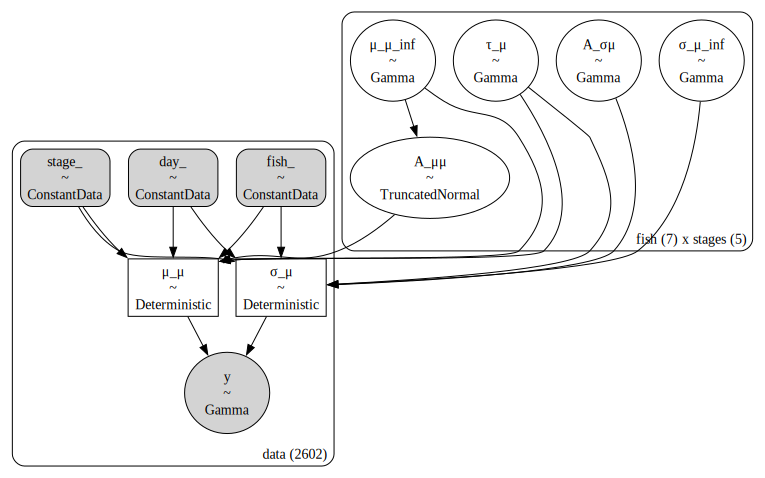

In [12]:
pm.model_to_graphviz(m4_dis)

# Priors
## Sample prior predictive

In [13]:
id_yds = pm.sample_prior_predictive(samples=200, model=m4_dis)
prior = id_yds.prior
pp = id_yds.prior_predictive
cd = id_yds.constant_data

Sampling: [A_μμ, A_σμ, y, μ_μ_inf, σ_μ_inf, τ_μ]


In [14]:
id_yds

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [15]:
start_day = -25
last_day = start_day

day_ranges = {}
for stage in stage_list:
    day_ranges[stage] = np.arange(last_day, last_day+days[stage])
    last_day = np.max(day_ranges[stage])+1

In [16]:
def plot_hyperparameter_time_course(A_param, τ_param, inf_param, param_name):
    fig, axes = plt.subplots(len(fish_list), 1, figsize=(25, 20)) # Adjust the size as needed
    num_draws_to_plot = 20

    for fish_id,fish_index in fish_index_map.items():
        draws_f = np.random.choice(prior.draw.values, size=num_draws_to_plot, replace=False)
        for stage_id,stage_index in stage_index_map.items():
            prior_fs = prior.sel({'fish': fish_id, 'stages': stage_id, 'draw': draws_f}).squeeze()
            A_fs = prior_fs[A_param]
            inf_fs = prior_fs[inf_param]
            τ_fs = prior_fs[τ_param]
            
            stage_days = xr.DataArray(np.arange(days[stage_id]), dims="days")
            param_vals = A_fs * np.exp(-stage_days / τ_fs) + inf_fs
            
            ax = axes[fish_index] # Get the specific subplot
            ax.plot(day_ranges[stage_id], param_vals.values.T, alpha=0.4, label=f"{stage_id}")
            ax.set_xlabel("Days")
            ax.set_ylabel(param_name)
            ax.set_title(f"Fish {fish_id}")


    fig.suptitle(f'Prior Predictive Checks for {param_name}', fontsize=16)  # Add a main title here
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
    plt.tight_layout(pad=4.0)
    plt.show()

C:\Users\86153\AppData\Local\Temp\ipykernel_50528\4181599608.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


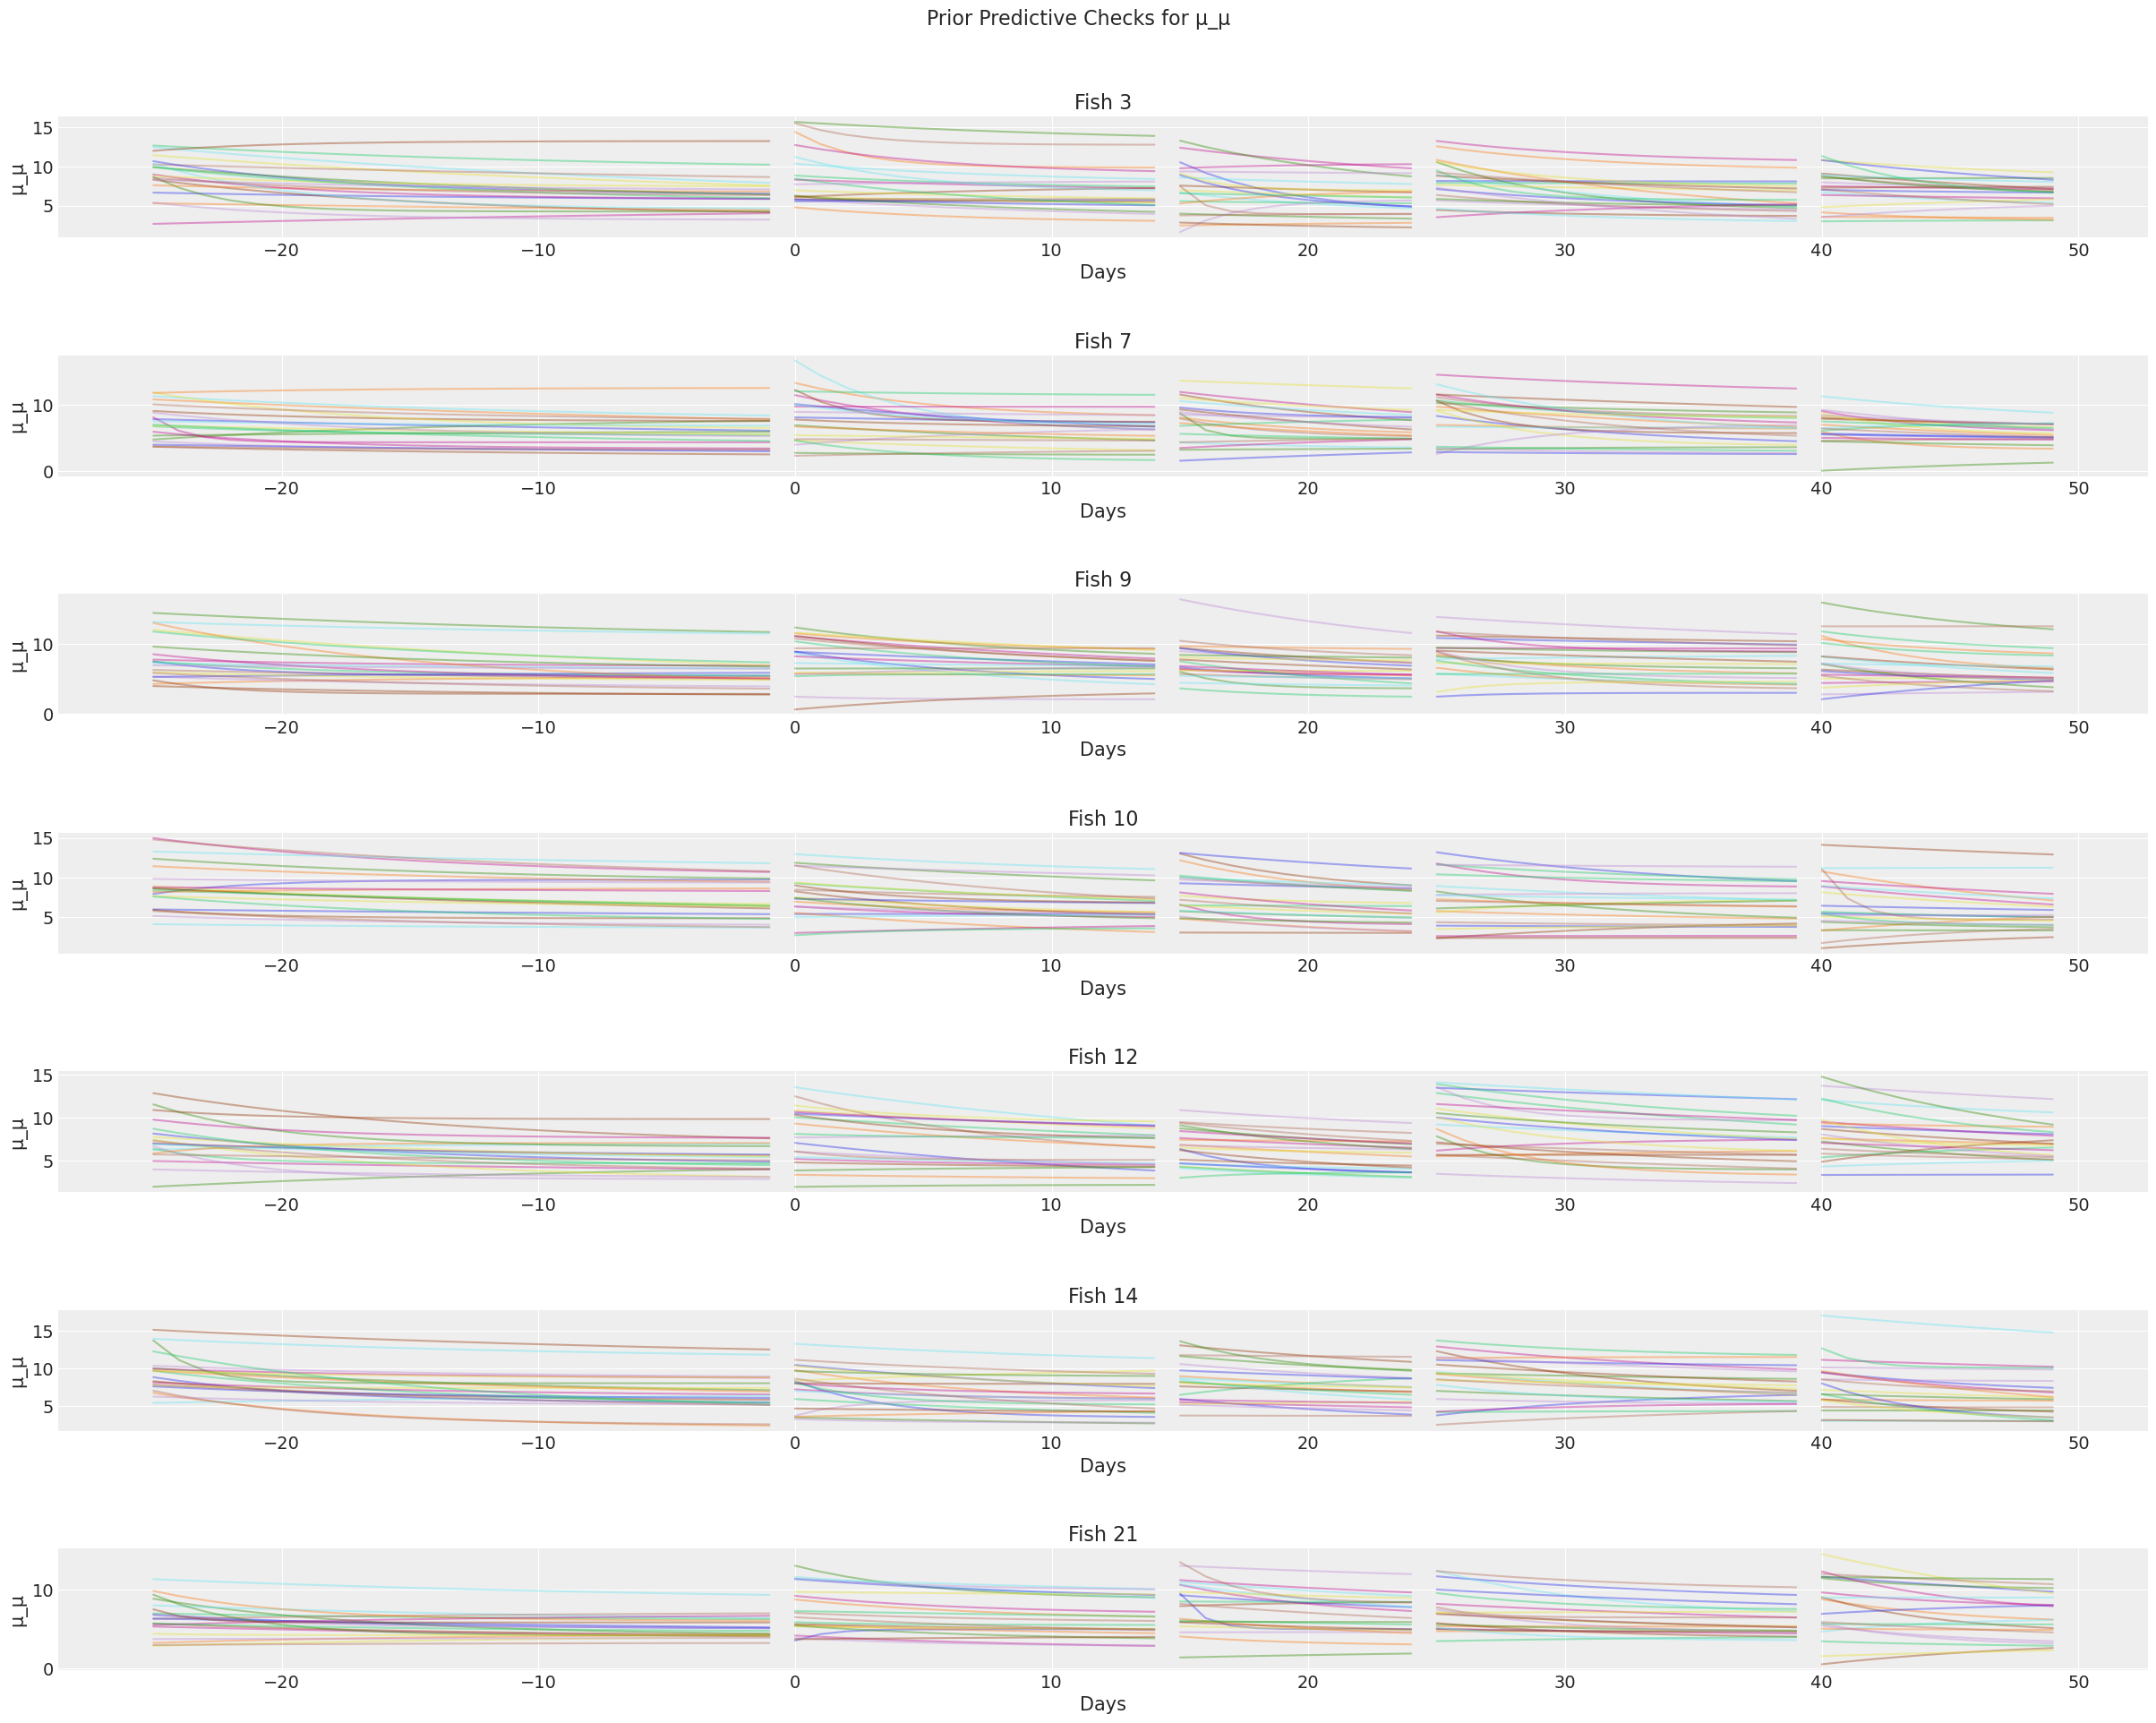

In [17]:
plot_hyperparameter_time_course("A_μμ", "τ_μ", "μ_μ_inf", "μ_μ")

C:\Users\86153\AppData\Local\Temp\ipykernel_50528\4181599608.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


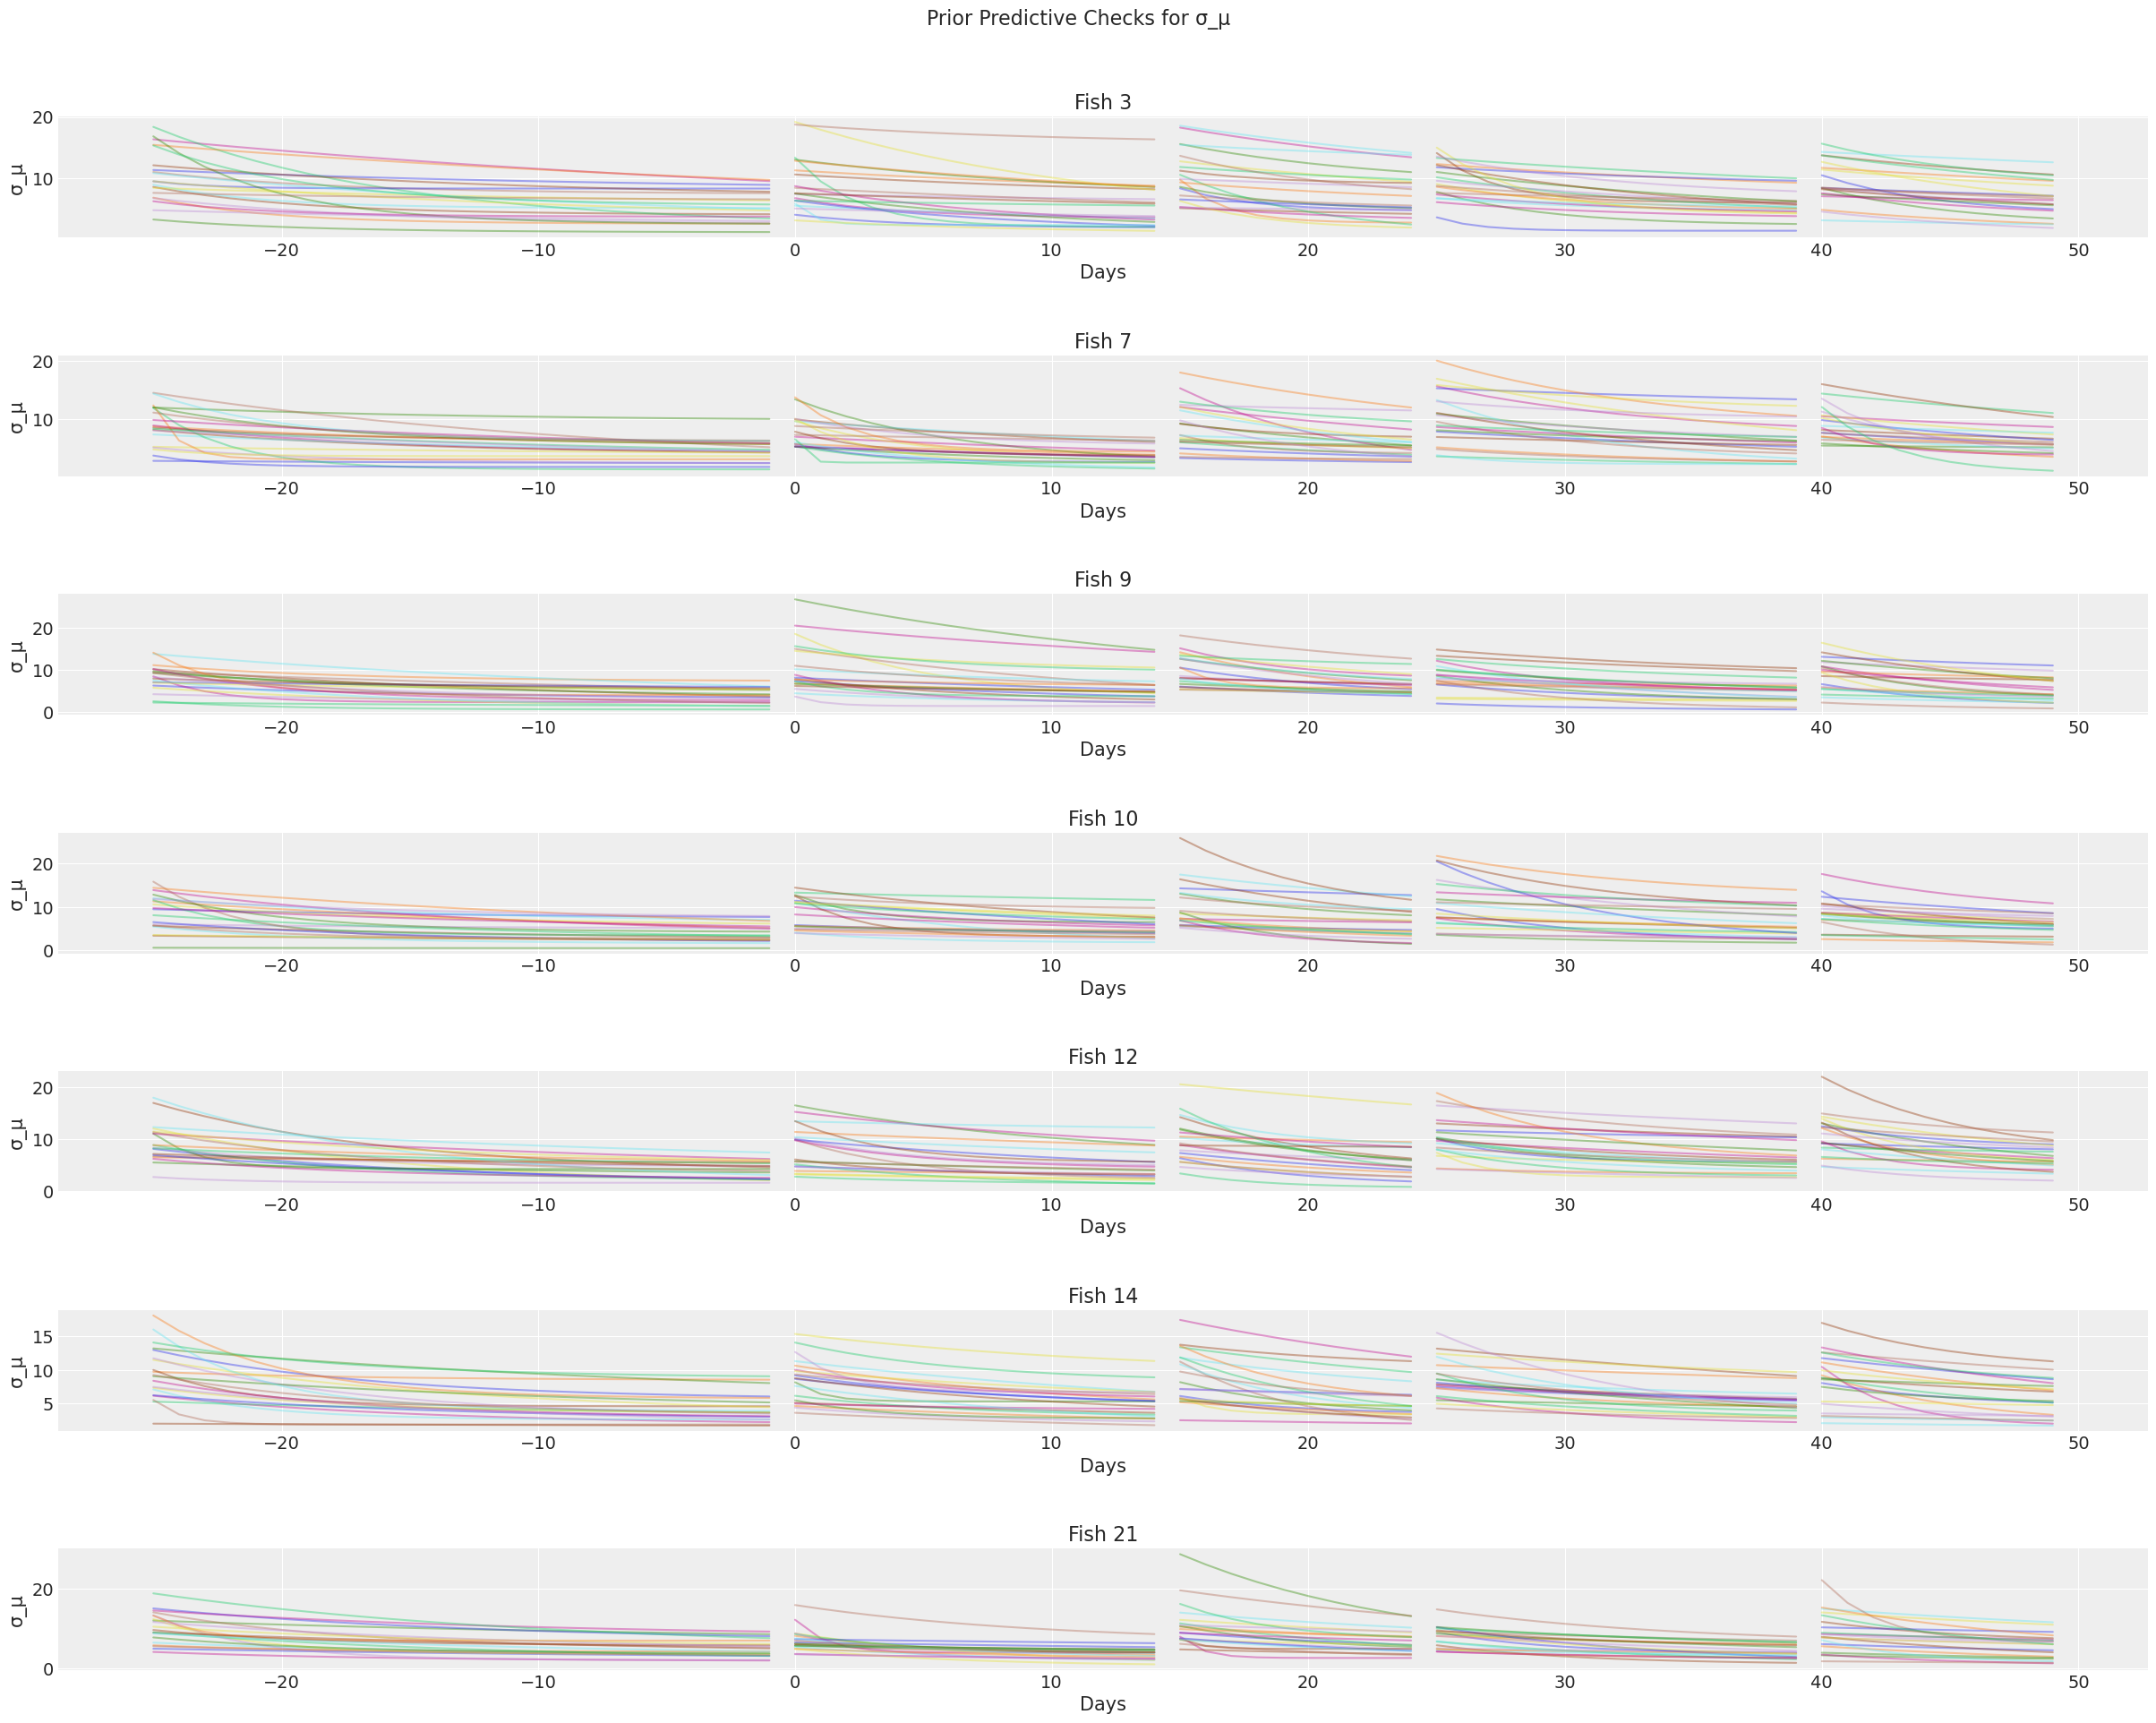

In [18]:
plot_hyperparameter_time_course("A_σμ", "τ_μ", "σ_μ_inf", "σ_μ")

In [19]:
# index_stage_map = {v: k for k, v in stage_index_map.items()}
# day_range_ = xr.ones_like(cd.day_)
# for i in day_range_['data']:
#     stage_id = index_stage_map[cd.stage_[i].item()]
#     day_range_[i] = day_ranges[stage_id][cd.day_[i].item()-1]


In [20]:
def plot_data_time_course_across_fish(day, data, data_name):
    plot_ds = xr.Dataset(data_vars={'day': day, 'data': data})

    fig, ax = plt.subplots(1, 1, figsize=(14, 3)) # Adjust the size as needed

    plot_df = plot_ds.to_dataframe().reset_index()
    plot_df['day'] = plot_df['day'].astype(int)
    sns.violinplot(data=plot_df, x='day', y='data', ax=ax, inner='quartile')
    ax.set_title(f'{data_name}')
    ax.set_xlabel('Days')
    ax.set_ylabel(f'{data_name}')

In [21]:
# plot_ds = xr.Dataset(data_vars={'day': day_range_, 'fish': cd.fish_, 'sigma_y': prior['σ']})

# fig, ax = plt.subplots(1, 1, figsize=(14, 3)) # Adjust the size as needed

# plot_df = plot_ds.to_dataframe().reset_index()
# plot_df['day'] = plot_df['day'].astype(int)
# sns.violinplot(data=plot_df, x='day', y='sigma_y', ax=ax, inner='quartile')
# ax.set_title(f'Prior sigma_y')
# ax.set_xlabel('Days')
# ax.set_ylabel('sigma_yds')

## NumPyro JAX NUTS sampler

In [22]:
with m4_dis:
    id_yds_numpyro = pm.sample(1000, tune=1000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ_μ, μ_μ_inf, A_μμ, A_σμ, σ_μ_inf]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 253 seconds.


In [23]:
az.summary(id_yds_numpyro, var_names=['A_μμ'], coords={'stages': ['Rotation']})

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
A_μμ[3, Rotation]   4.693  2.004   0.857    8.427      0.032    0.022   
A_μμ[7, Rotation]   3.488  1.323   0.972    5.882      0.016    0.011   
A_μμ[9, Rotation]   2.714  1.710  -0.400    5.977      0.021    0.018   
A_μμ[10, Rotation]  3.347  1.498   0.575    6.198      0.019    0.014   
A_μμ[12, Rotation] -0.358  1.704  -3.487    2.798      0.025    0.024   
A_μμ[14, Rotation] -0.238  1.215  -2.484    2.084      0.017    0.018   
A_μμ[21, Rotation]  2.225  1.162   0.118    4.512      0.017    0.012   

                    ess_bulk  ess_tail  r_hat  
A_μμ[3, Rotation]     4073.0    2883.0    1.0  
A_μμ[7, Rotation]     7090.0    2345.0    1.0  
A_μμ[9, Rotation]     6591.0    3026.0    1.0  
A_μμ[10, Rotation]    6118.0    2260.0    1.0  
A_μμ[12, Rotation]    4429.0    3076.0    1.0  
A_μμ[14, Rotation]    5049.0    3248.0    1.0  
A_μμ[21, Rotation]    4455.0    2898.0    1.0

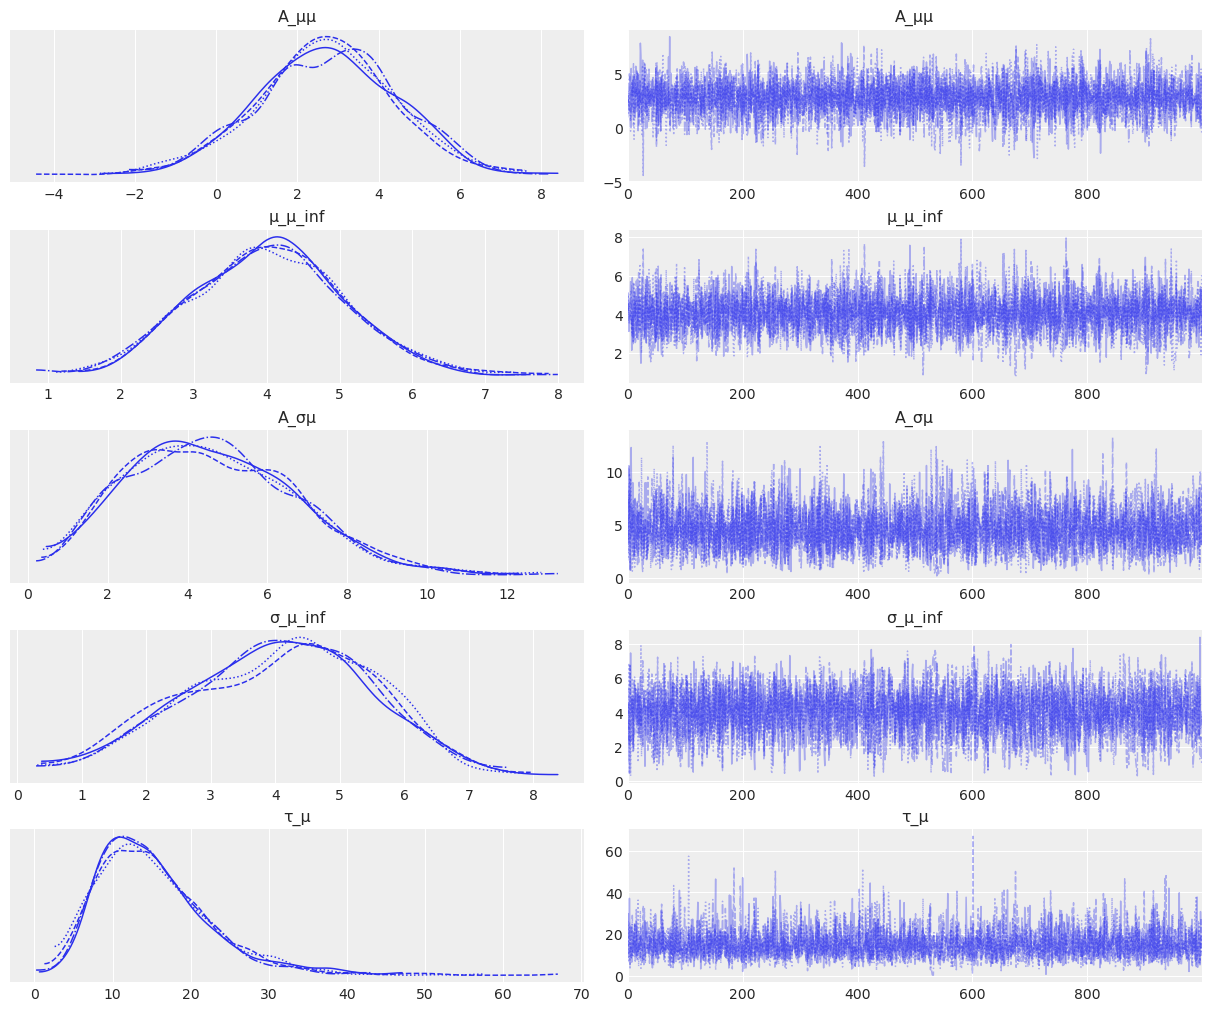

In [24]:
az.plot_trace(id_yds_numpyro, var_names=['A_μμ', 'μ_μ_inf', 'A_σμ', 'σ_μ_inf', 'τ_μ'], coords={'fish':9, 'stages': 'Rotation'});

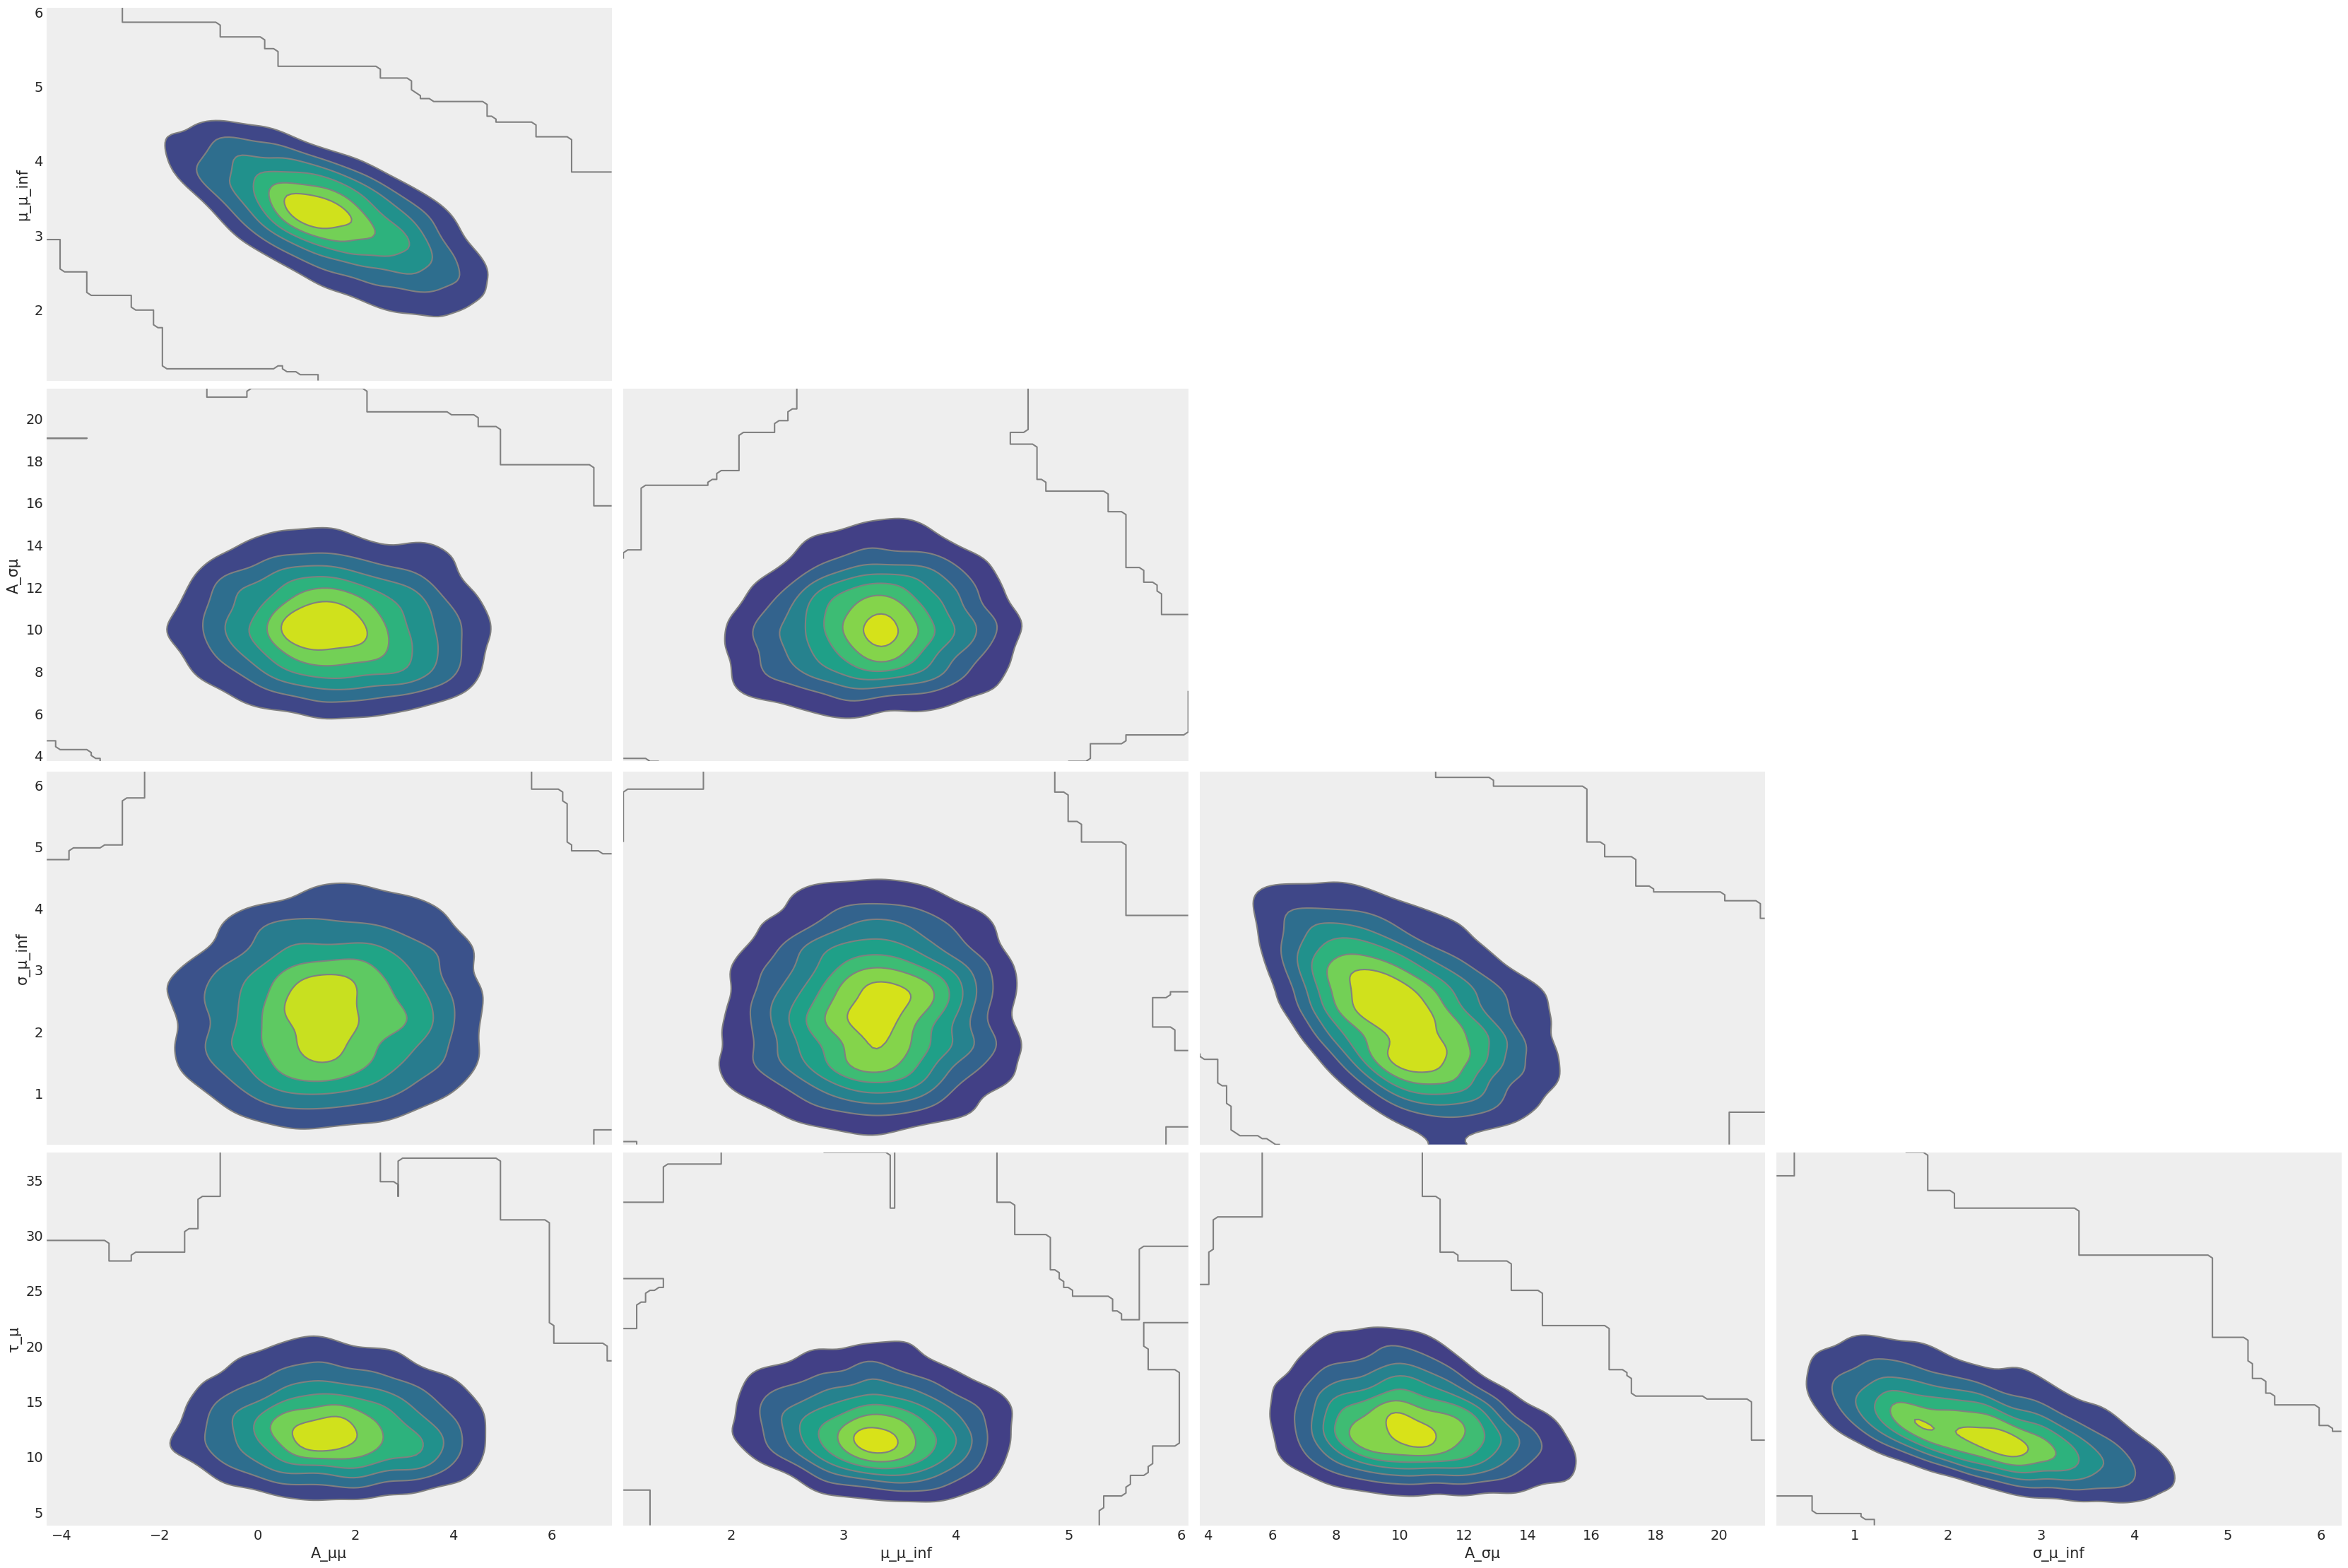

In [25]:
az.plot_pair(id_yds_numpyro, var_names=['A_μμ', 'μ_μ_inf', 'A_σμ', 'σ_μ_inf', 'τ_μ'], 
             coords={'fish':10, 'stages': 'Baseline'}, 
             divergences=True,
             kind='kde');

## Posterior preditive plots

In [26]:
with m4_dis:
    pm.sample_posterior_predictive(id_yds_numpyro, extend_inferencedata=True)

Sampling: [y]


In [27]:

posterior = id_yds_numpyro.posterior
ppc = id_yds_numpyro.posterior_predictive
cd = id_yds_numpyro.constant_data
obd = id_yds_numpyro.observed_data


In [28]:
def plot_hyperparameter_ppc_course(A_param, τ_param, inf_param, param_name):
    fig, axes = plt.subplots(len(fish_list), 1, figsize=(25, 40)) # Adjust the size as needed
    num_draws_to_plot = 20

    for fish_id,fish_index in fish_index_map.items():
        draws_f = np.random.choice(posterior.draw.values, size=num_draws_to_plot, replace=False)
        for stage_id,stage_index in stage_index_map.items():
            posterior_fs = posterior.sel({'fish': fish_id, 'stages': stage_id, 'draw': draws_f}).squeeze()
            A_fs = posterior_fs[A_param]
            inf_fs = posterior_fs[inf_param]
            τ_fs = posterior_fs[τ_param]
            
            stage_days = xr.DataArray(np.arange(days[stage_id]), dims="days")
            ppc_param_vals = A_fs * np.exp(-stage_days / τ_fs) + inf_fs
            
            ax = axes[fish_index]  # Get the specific subplot
            for draw_idx in range(num_draws_to_plot):
                ax.plot(day_ranges[stage_id], ppc_param_vals.values.T[:, draw_idx, 1], alpha=0.4, label=f"Draw {draw_idx + 1}")

            ax.set_xlabel("Days")
            ax.set_ylabel(param_name)
            ax.set_title(f"Fish {fish_id}")


    fig.suptitle(f'Posterior Predictive Checks for {param_name}', fontsize=16)  # Add a main title here
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
    plt.tight_layout(pad=4.0)
    plt.show()

C:\Users\86153\AppData\Local\Temp\ipykernel_50528\2590890671.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


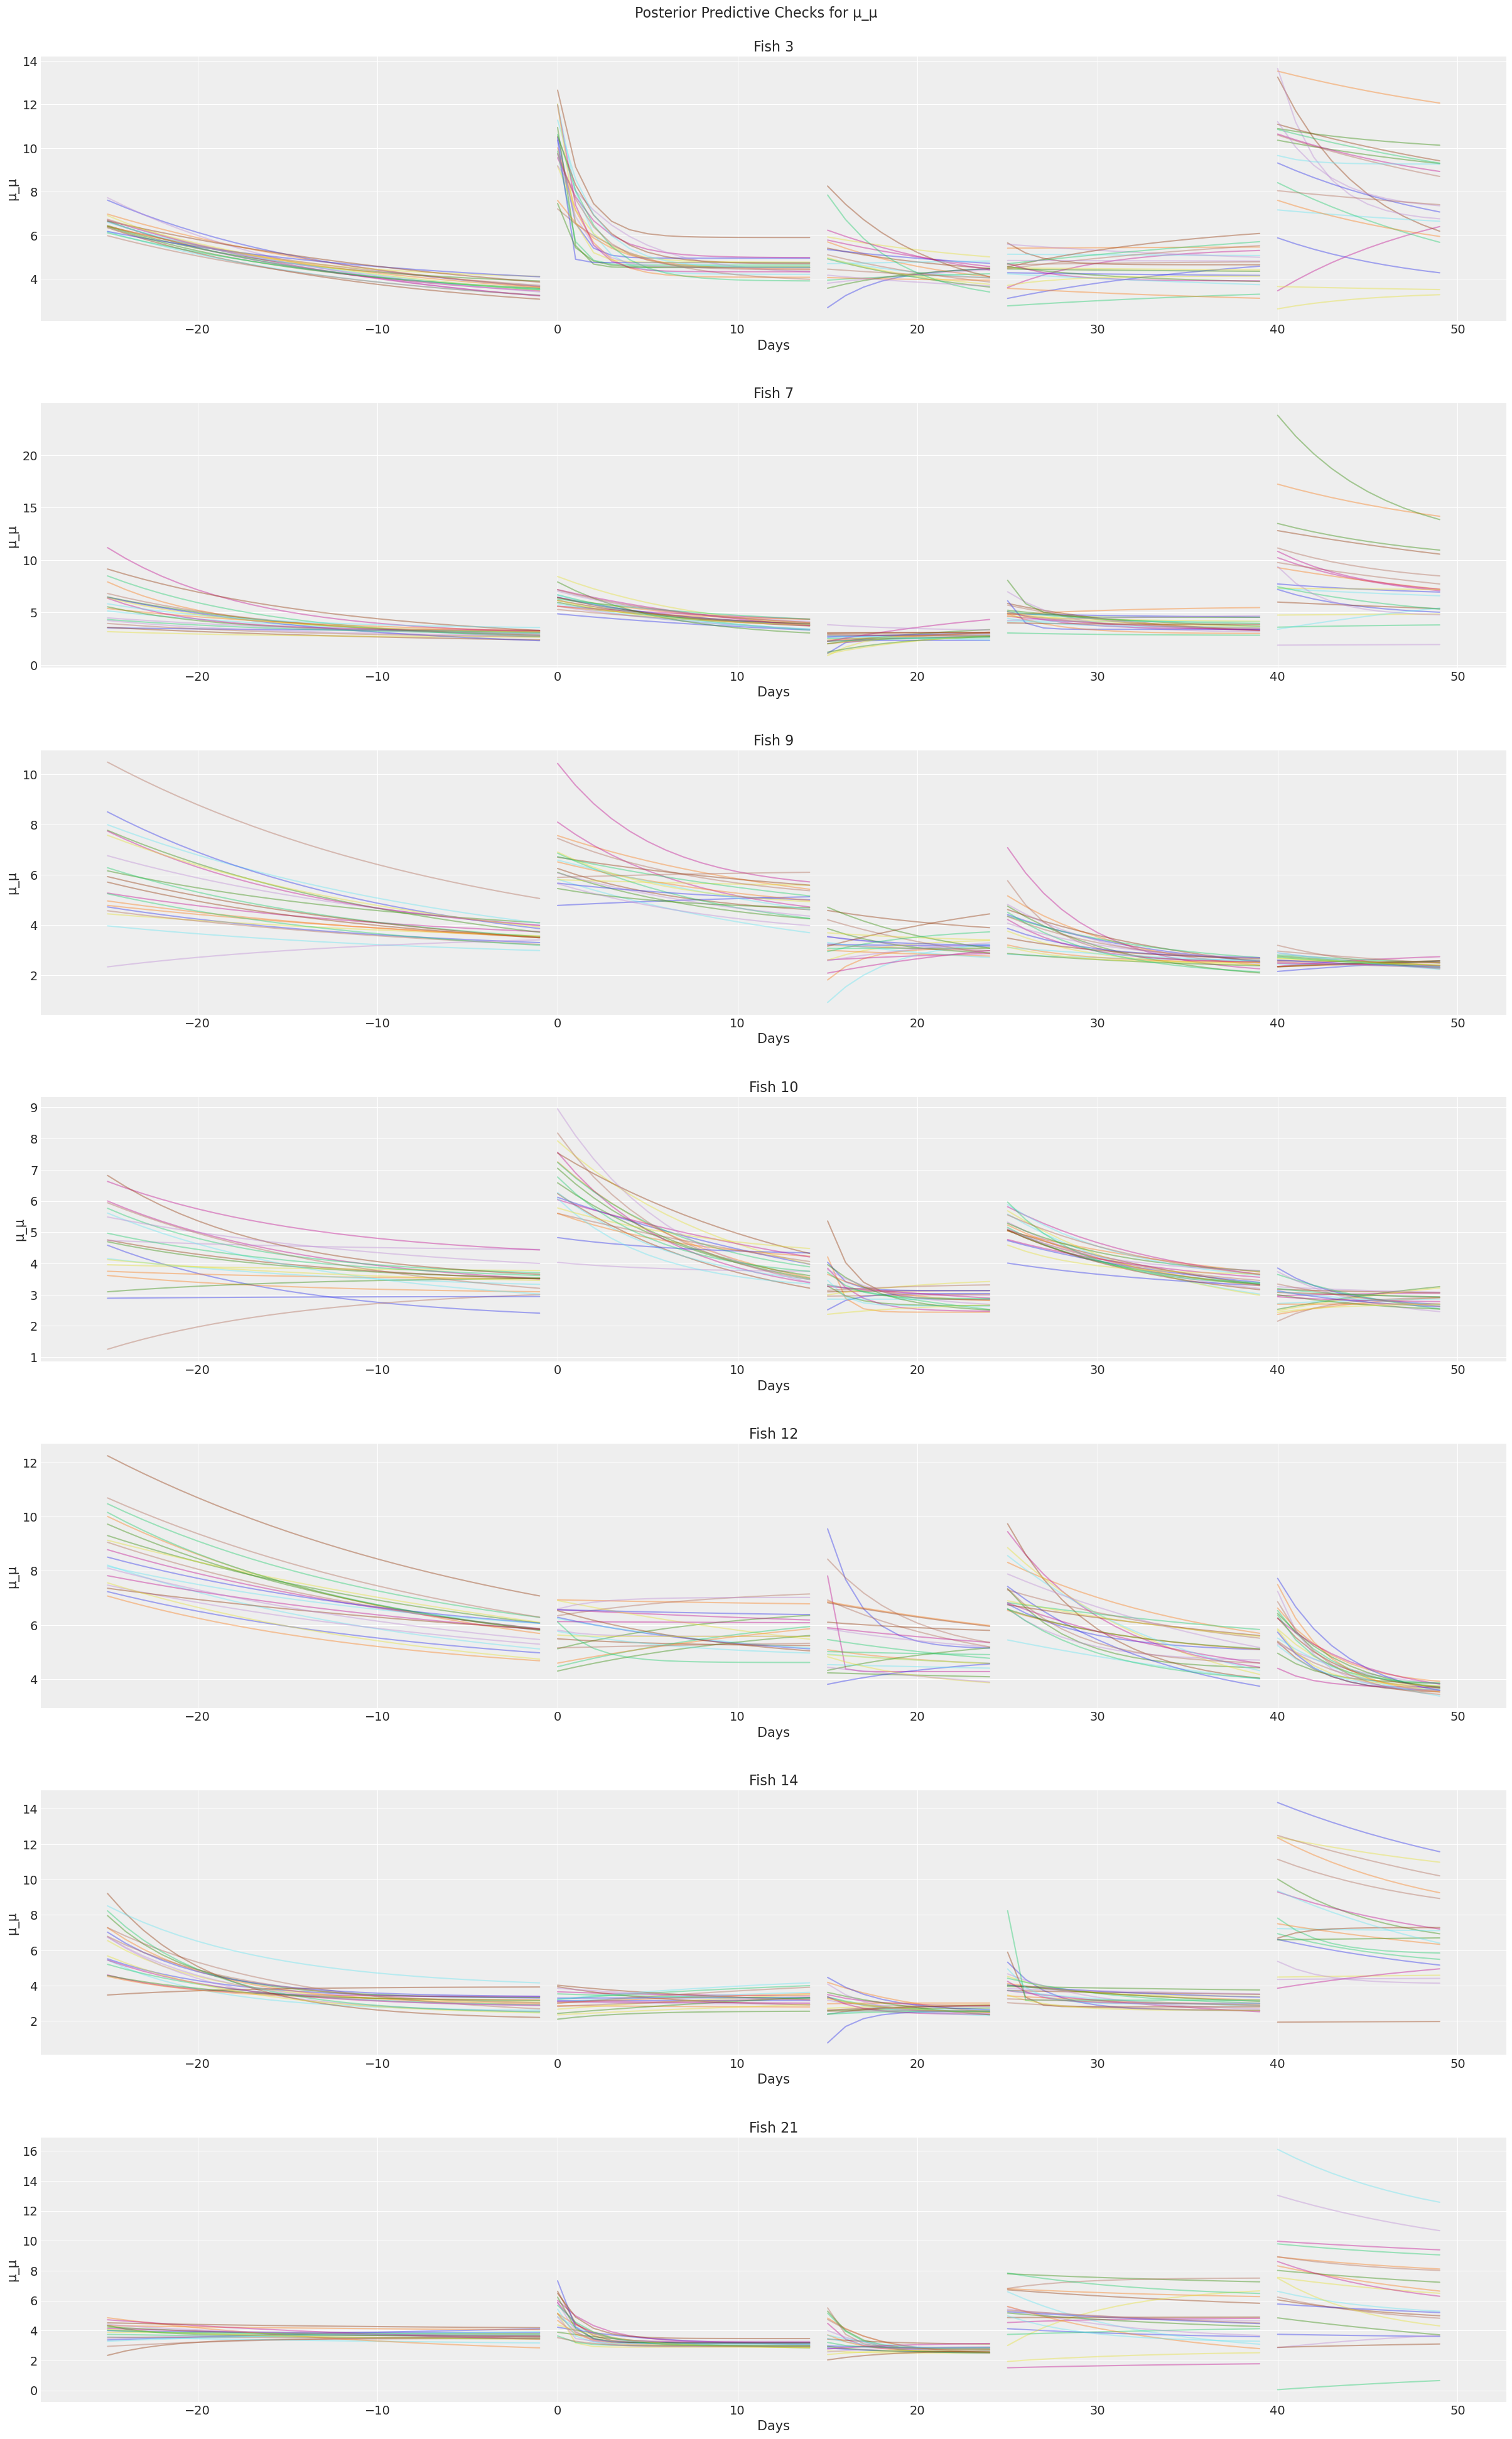

In [29]:

plot_hyperparameter_ppc_course("A_μμ", "τ_μ", "μ_μ_inf", "μ_μ")


C:\Users\86153\AppData\Local\Temp\ipykernel_50528\2590890671.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


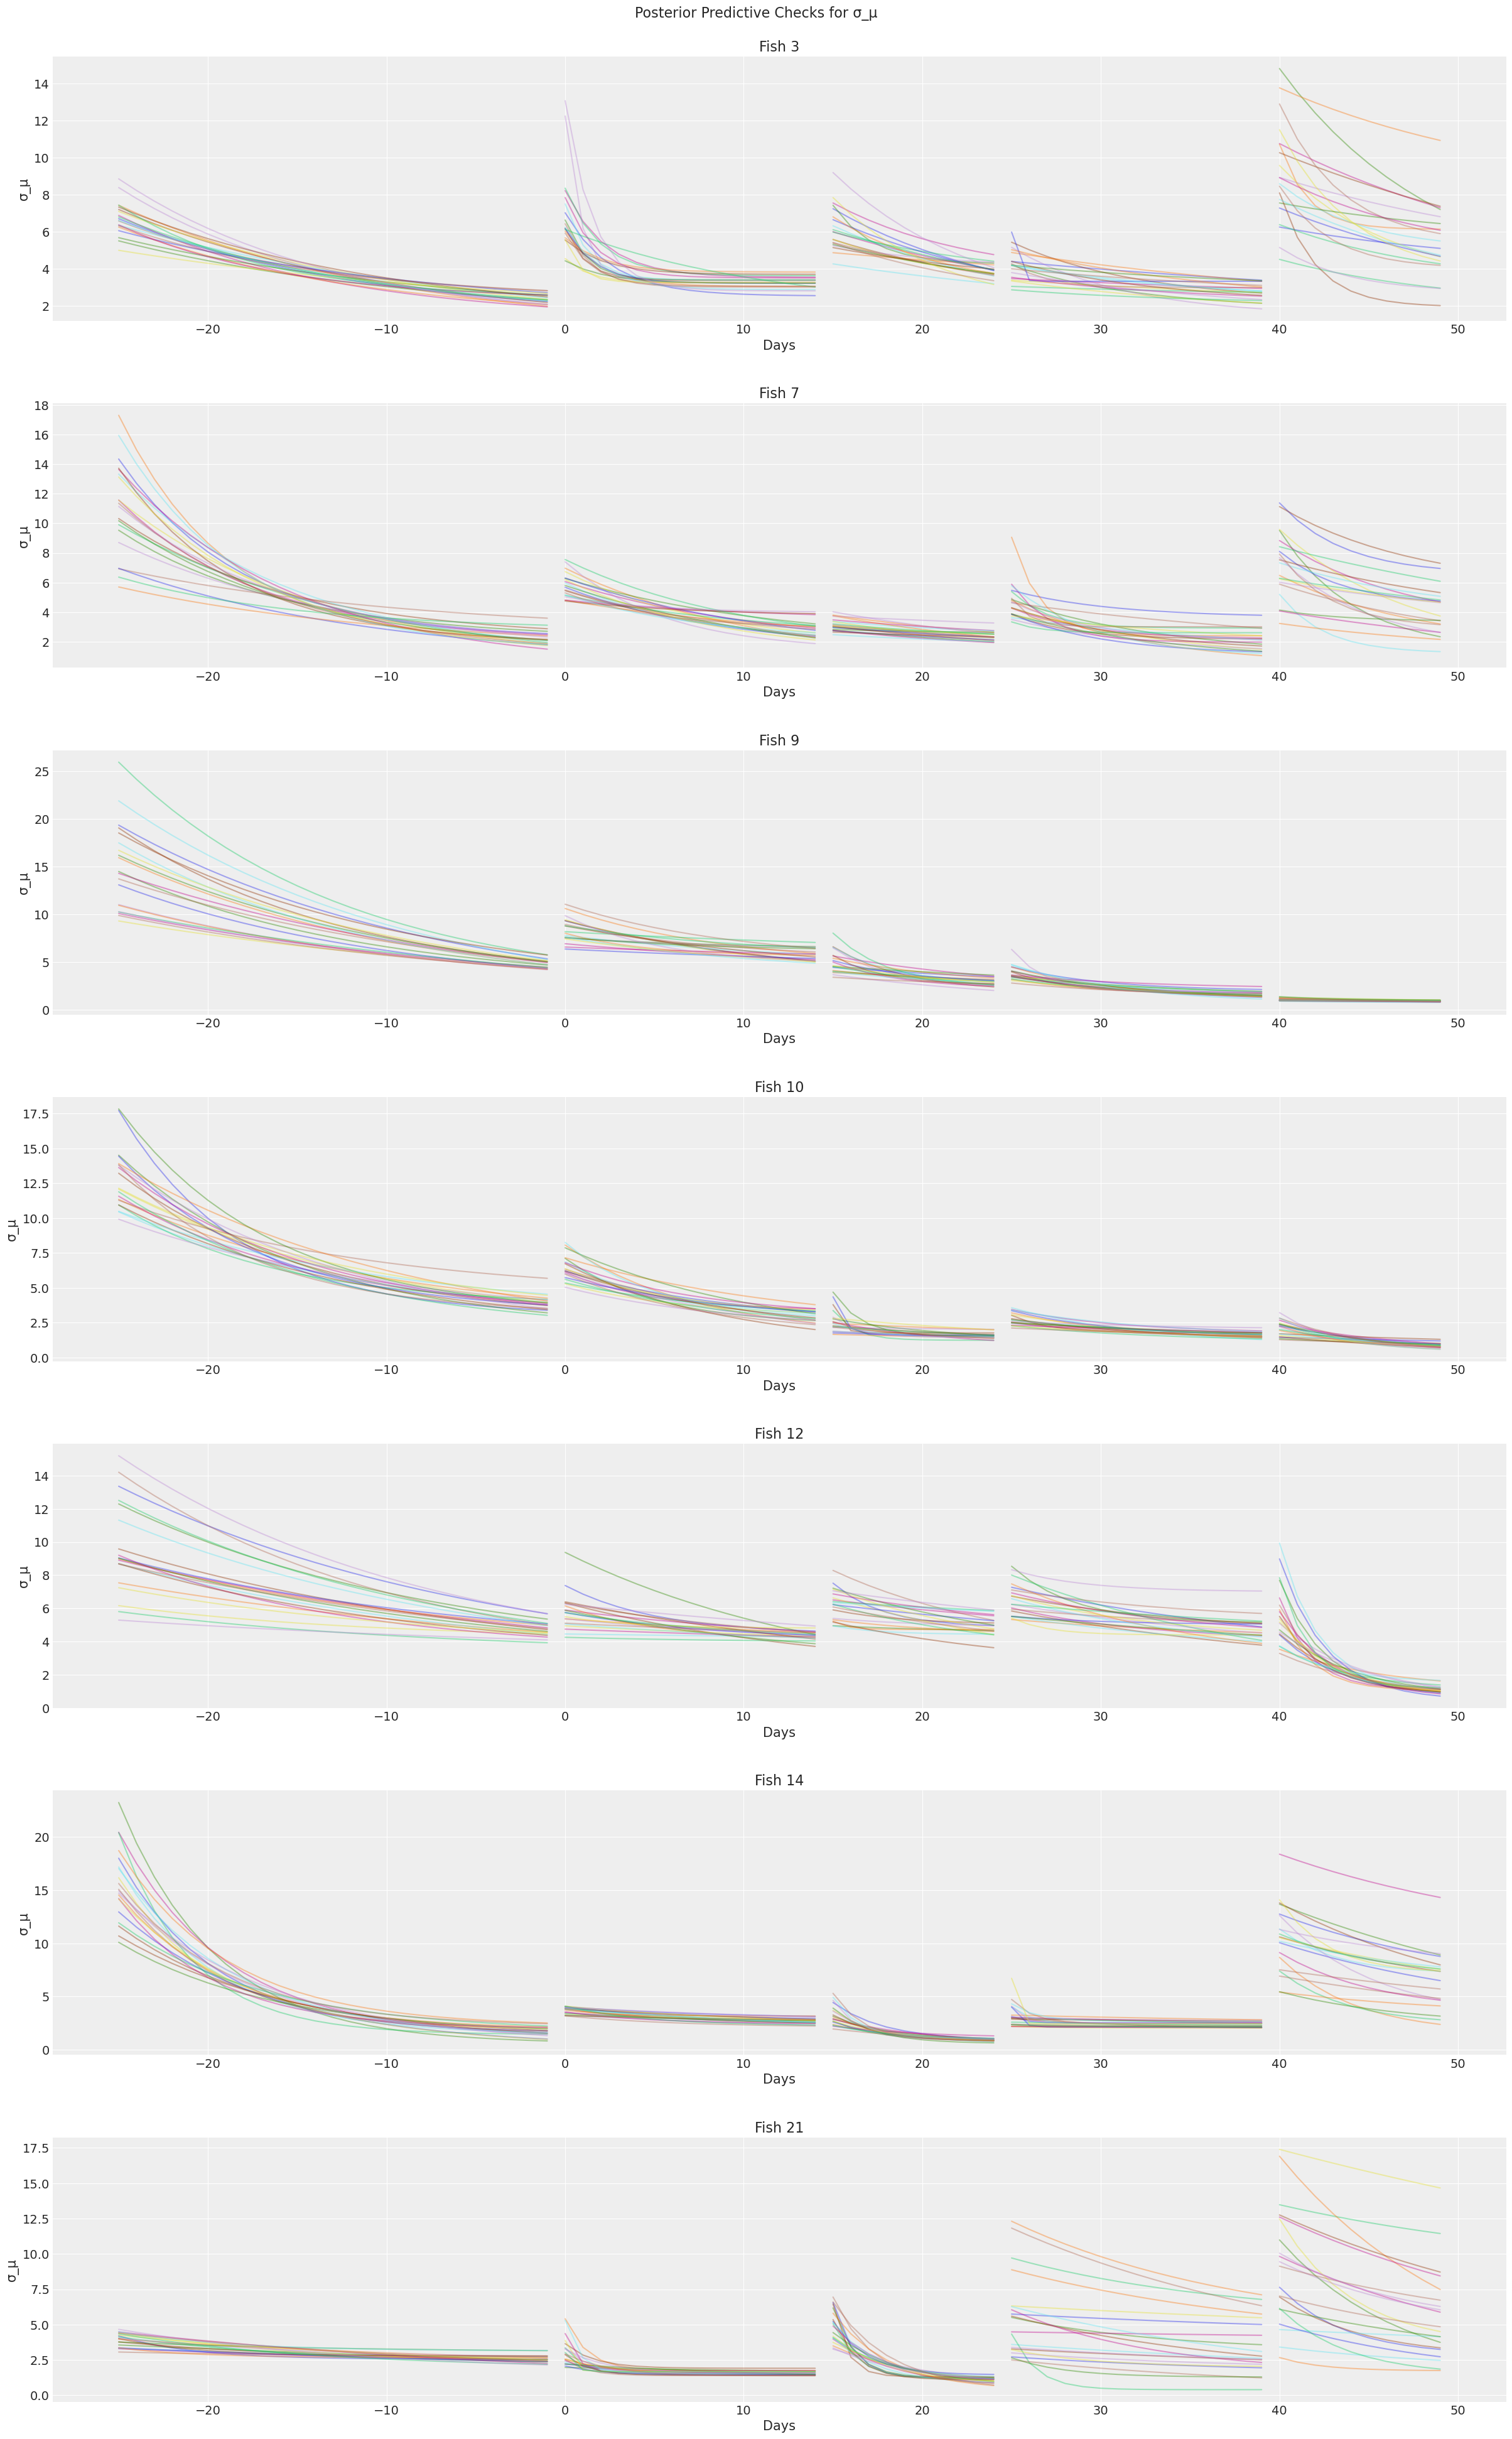

In [30]:
plot_hyperparameter_ppc_course("A_σμ", "τ_μ", "σ_μ_inf", "σ_μ")

<Axes: title={'center': 'y'}>

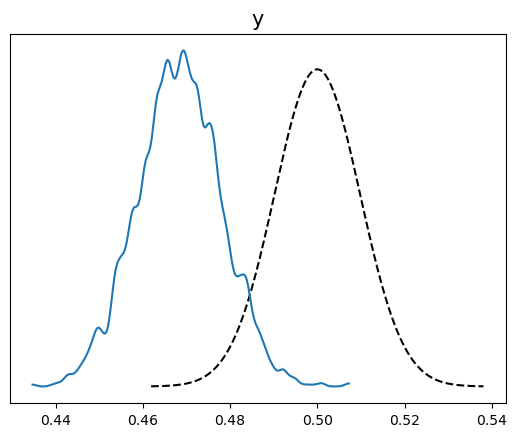

In [171]:
az.plot_bpv(id_yds_numpyro, kind="p_value")

<Axes: title={'center': 'y'}>

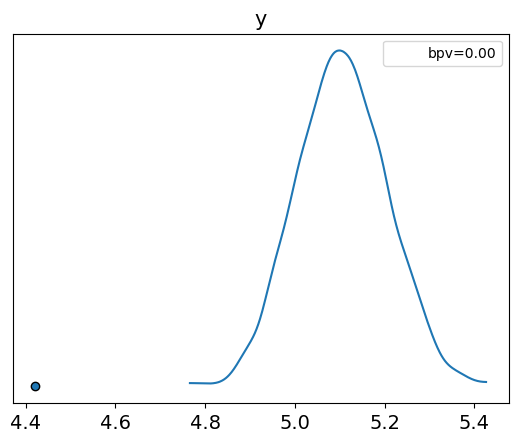

In [172]:
az.plot_bpv(id_yds_numpyro, kind="t_stat", t_stat=lambda x:np.percentile(x, q=50, axis=-1))

In [31]:


# # Define color mapping for trial phases
# phase_colors = {
#     'Baseline': 'yellow',
#     'Rotation': 'red',
#     'Washout': 'green',
#     'ReRotation': 'blue'
# }

# Define the trial phase ranges for each fish
fish_trial_phases = {
    'Fish 10': {
        'Baseline': (1, 149),
        'Rotation': (150, 239),
        'Washout': (240, 299),
        'ReRotation': (300, 388),
        'ReWashout' : (389,448)
    },
    'Fish 12': {
        'Baseline': (449, 597),
        'Rotation': (598, 687),
        'Washout': (688, 747),
        'ReRotation': (748, 837),
        'ReWashout' : (838,897)
    },
    'Fish 14': {
        'Baseline': (898, 998),
        'Rotation': (999, 1089),
        'Washout': (1090, 1148),
        'ReRotation': (1149, 1226)
    },
    'Fish 21': {
        'Baseline': (1227, 1394),
        'Rotation': (1395,1484),
        'Washout': (1485, 1544),
        'ReRotation': (1545, 1550)
    },
    'Fish 3': {
        'Baseline': (1551,1704),
        'Rotation': (1705,1794),
        'Washout': (1795, 1854),
        'ReRotation': (1855, 1902)
    },
    'Fish 7': {
        'Baseline': (1903, 1974),
        'Rotation': (1975, 2064),
        'Washout': (2065, 2124),
        'ReRotation': (2125, 2160)
    },
        'Fish 9': {
        'Baseline': (2161, 2302),
        'Rotation': (2303, 2392),
        'Washout': (2393, 2452),
        'ReRotation': (2453, 2542),
        'ReWashout' : (2543,2602)
    },


}

# # Plotting side-by-side for each fish and trial phase
# fig, axes = plt.subplots(nrows=len(fish_trial_phases), ncols=1, figsize=(12, 8 * len(fish_trial_phases)))

# for i, (fish_name, trial_phases) in enumerate(fish_trial_phases.items()):
#     ax = axes[i]
    
#     for phase_name, (start_idx, end_idx) in trial_phases.items():
#         # Plot posterior predictive data for the current trial phase with the same color
#         draw_idx = 0  # Choose a specific draw index to plot (adjust as needed)
#         num_draws_to_plot = 100
#         for draw_idx in range(num_draws_to_plot):
#             ax.scatter(range(start_idx, end_idx + 1), ppc.y[1, draw_idx, start_idx - 1:end_idx], 
#                 label=f'{fish_name} - {phase_name} Posterior Predictive (Draw {draw_idx + 1})', 
#                 color=phase_colors[phase_name], alpha=0.1)
            
#             ax.scatter(range(start_idx, end_idx + 1), posterior.μ_μ[1, draw_idx, start_idx - 1:end_idx], 
#                 label=f'{fish_name} - {phase_name} Posterior μ_μ (Draw {draw_idx + 1})', 
#                 color=phase_colors[phase_name], alpha=0.5)
#             # Plot observed data for the current trial phase with specified color
#         #ax.plot(range(start_idx, end_idx + 1), obd.y[start_idx - 1:end_idx], 
#               #  label=f'{fish_name} - {phase_name} (Observed)', color=phase_colors[phase_name])
#         ax.scatter(range(start_idx, end_idx + 1), obd.y[start_idx - 1:end_idx], 
#                 label=f'{fish_name} - {phase_name} (Observed)', color = 'black' )
        
#     ax.set_xlabel('Trial')
#     ax.set_ylabel('Yds')
#     ax.set_title(fish_name)
#     # ax.legend()

# plt.tight_layout()
# plt.show()


In [32]:
# Assuming 'posterior.μ_μ' is your xarray DataArray with dimensions [chain, draw, data]
# and that it has 1387 data points (or any other number, but for the sake of divisibility we assume a correct truncation)

# Ensure data points can be grouped into sets of 6
num_trials = posterior.μ_μ.shape[2]
num_days = num_trials // 6  # floor division to ignore any remainder trials that do not complete a day
trials_per_day = 6

# Truncate the last few trials if they don't make up a full day
truncated_data = posterior.μ_μ[:, :, :num_days * 6]

# Assign a new coordinate that groups every 6 trials into one day
truncated_data.coords['day'] = ('data', np.repeat(np.arange(num_days), trials_per_day))

# Group by the new 'day' coordinate and calculate the mean
daily_μ_μ = truncated_data.groupby('day').mean('data')

# daily_μ_μ now has dimensions [chain, draw, day] where 'day' represents the aggregated mean of every 6 trials


In [33]:
def get_fish_and_stage(day_index, fish_trial_phases, trials_per_day=6):
    # Convert day index to 1-based trial index
    trial_index = day_index * trials_per_day + 1
    
    # Iterate through each fish and their phases to find where the trial_index falls
    for fish, phases in fish_trial_phases.items():
        for stage, (start, end) in phases.items():
            if start <= trial_index <= end:
                return fish, stage
    
    return None, None  # Return None if no matching fish or stage is found


In [34]:
# Determine the number of days (based on the 'day' dimension)
num_days = daily_μ_μ.sizes['day']

# Create lists to hold the 'fish' and 'stage' labels for each day
fish_labels = []
stage_labels = []

# Loop over each day index to determine the corresponding fish and stage
for day_index in range(num_days):
    # Get the full fish name and stage name for the current day index
    fish, stage = get_fish_and_stage(day_index, fish_trial_phases)
    
    # Append the full fish and stage names to the labels lists
    fish_labels.append(fish)
    stage_labels.append(stage)

# Convert the lists to numpy arrays
fish_labels = np.array(fish_labels)
stage_labels = np.array(stage_labels)

# Add 'fish' and 'stage' as coordinates to the 'day' dimension
daily_μ_μ.coords['fish'] = ('day', fish_labels)
daily_μ_μ.coords['stage'] = ('day', stage_labels)

# Now 'daily_μ_μ' has additional coordinates 'fish' and 'stage' associated with each day

In [35]:
μ_μ_plot = az.summary(posterior, var_names=['μ_μ'], hdi_prob=0.94)  # Adjust hdi_prob as needed (e.g., 0.95 for 94% HDI)

In [36]:
σ_μ_plot = az.summary(posterior, var_names=['σ_μ'], hdi_prob=0.94)  # Adjust hdi_prob as needed (e.g., 0.95 for 94% HDI)

In [37]:
y_ppc_plot = az.summary(ppc, var_names=['y'], hdi_prob=0.94)

In [38]:
y_obd_plot = obd.y.to_dataframe(name="y")

In [39]:
# Define fish_trial_phases dictionary
fish_trial_phases = {
    '10': {
        'Baseline': (0, 148),
        'Rotation': (149, 238),
        'Washout': (239, 298),
        'ReRotation': (299, 387),
        'ReWashout' : (388,447)
    },
    '12': {
        'Baseline': (448, 596),
        'Rotation': (597, 686),
        'Washout': (687, 746),
        'ReRotation': (747, 836),
        'ReWashout' : (837,896)
    },
    '14': {
        'Baseline': (897, 997),
        'Rotation': (998, 1088),
        'Washout': (1089, 1147),
        'ReRotation': (1148, 1225)
    },
    '21': {
        'Baseline': (1226, 1393),
        'Rotation': (1394,1483),
        'Washout': (1484, 1543),
        'ReRotation': (1544, 1549)
    },
    '3': {
        'Baseline': (1550,1703),
        'Rotation': (1704,1793),
        'Washout': (1794, 1853),
        'ReRotation': (1854, 1901)
    },
    '7': {
        'Baseline': (1902, 1973),
        'Rotation': (1974, 2063),
        'Washout': (2064, 2123),
        'ReRotation': (2124, 2159)
    },
    '9': {
        'Baseline': (2160, 2301),
        'Rotation': (2302, 2391),
        'Washout': (2392, 2451),
        'ReRotation': (2452, 2541),
        'ReWashout' : (2542,2601)
    },


}



# Function to determine trial phase based on row index
def get_trial_phase(index):
    for fish, phases in fish_trial_phases.items():
        for phase, (start, end) in phases.items():
            if start <= index <= end:
                return fish, phase, index - start + 1
    # Return default values (e.g., NaN) if no trial phase is found
    return None, None, None

# Apply function to create new columns 'fish', 'stage', 'day'
y_obd_plot['index'] = y_obd_plot.index  # Create a new column 'index' to work with the index
y_obd_plot['fish'], y_obd_plot['stage'], y_obd_plot['day'] = zip(*y_obd_plot['index'].map(get_trial_phase))

# Drop the 'index' column (optional)
y_obd_plot.drop(columns=['index'], inplace=True)




In [40]:
# Map day values such that each 6-day cycle is treated as 1 day
y_obd_plot['day'] = np.ceil(y_obd_plot['day'] / 6)

In [41]:


y_obd_plot['fish'] = pd.to_numeric(y_obd_plot['fish'], errors='coerce')
y_obd_plot['day'] = pd.to_numeric(y_obd_plot['day'], errors='coerce')

# Initialize plotday column with NaN
y_obd_plot['plotday'] = None
# Drop the 'index' column (optional)
# Iterate through each row to calculate plotday based on 'fish' and 'day'
current_fish = None
current_day = None
current_plotday = 0

for index, row in y_obd_plot.iterrows():
    if row['fish'] != current_fish:
        # New fish encountered, reset plotday to 1
        current_fish = row['fish']
        current_day = row['day']
        current_plotday = 1
    elif row['day'] != current_day:
        # Same fish but different day, increment plotday
        current_day = row['day']
        current_plotday += 1
    
    # Update plotday for the current row
    y_obd_plot.at[index, 'plotday'] = current_plotday

# Convert plotday column to numeric
y_obd_plot['plotday'] = pd.to_numeric(y_obd_plot['plotday'], errors='coerce')





In [42]:
# Rename columns in each DataFrame
μ_μ_plot_renamed = μ_μ_plot.rename(columns={'mean': 'μ_μ_y', 'hdi_3%': 'μ_μ_hdi_3%','hdi_97%': 'μ_μ_hdi_97%'})
σ_μ_plot_renamed = σ_μ_plot.rename(columns={'mean': 'σ_μ_y', 'hdi_3%': 'σ_μ_hdi_3%','hdi_97%': 'σ_μ_hdi_97%'})

y_ppc_plot_renamed = y_ppc_plot.rename(columns={'mean': 'ppc_y', 'hdi_3%': 'ppc_hdi_3%','hdi_97%': 'ppc_hdi_97%'})

In [43]:
μ_μ_plot_renamed = μ_μ_plot_renamed.reset_index(drop=True) 
σ_μ_plot_renamed = σ_μ_plot_renamed.reset_index(drop=True) 

y_ppc_plot_renamed = y_ppc_plot_renamed.reset_index(drop=True) 

In [44]:
ppcplot_df = pd.concat([y_obd_plot, μ_μ_plot_renamed[['μ_μ_y','μ_μ_hdi_3%','μ_μ_hdi_97%']], σ_μ_plot_renamed[['σ_μ_y','σ_μ_hdi_3%','σ_μ_hdi_97%']], y_ppc_plot_renamed[['ppc_y','ppc_hdi_3%','ppc_hdi_97%']]], axis=1)

In [45]:

ppcplot_df['fish'] = pd.to_numeric(y_obd_plot['fish'], errors='coerce')
ppcplot_df['day'] = pd.to_numeric(y_obd_plot['day'], errors='coerce')

In [46]:
# Define a list of stages in the correct order
stages = ['Baseline', 'Rotation', 'Washout', 'ReRotation','ReWashout']

stages_BWR= ['Baseline', 'Rotation', 'Washout']

stages_RReR= ['Rotation', 'ReRotation']

stages_ReRReW= [ 'ReRotation', 'ReWashout']
stages_RW = ['Rotation', 'Washout']

# Define color mapping for trial phases
# phase_colors = {
#     'Baseline': 'green',
#     'Rotation': 'red',
#     'Washout': 'green',
#     'ReRotation': 'blue',
#     'ReWashout':'green',
# }

phase_colors = {
    'Baseline': '#F0E442',  # Yellow
    'Rotation': '#CC79A7',   # Reddish Purple
    'Washout': '#F0E442',  # Yellow
    'ReRotation': '#56B4E9',  # Sky Blue
    'ReWashout':   '#E69F00',  # Orange
}
phase_colors_BWR = {
    'Baseline': '#F0E442',  # Yellow
    'Rotation': '#CC79A7',   # Reddish Purple
    'Washout': '#F0E442',  # Yellow
}




# Convert 'stage' column to categorical type with specified order
ppcplot_df['stage'] = pd.Categorical(ppcplot_df['stage'], categories=stages, ordered=True)
ppcplot_df_day = []




In [47]:
# Group by 'fish', 'stage', and 'day' columns, calculate mean, median and standard deviation of 'y' for each group
ppcplot_df_day = ppcplot_df.groupby(['fish', 'stage', 'day']).agg(
    mean_y=('y', 'mean'),
    median_y=('y', 'median'),
    std_y=('y', 'std'),
    mean_μ_μ_y=('μ_μ_y', 'mean'),
    median_μ_μ_y=('μ_μ_y', 'median'),
    mean_μ_μ_hdi_3=('μ_μ_hdi_3%', 'mean'),
    median_μ_μ_hdi_3=('μ_μ_hdi_3%', 'median'),
    mean_μ_μ_hdi_97=('μ_μ_hdi_97%', 'mean'),
    median_μ_μ_hdi_97=('μ_μ_hdi_97%', 'median'),
    mean_σ_μ_y=('σ_μ_y', 'mean'),
    median_σ_μ_y=('σ_μ_y', 'median'),
    mean_σ_μ_hdi_3=('σ_μ_hdi_3%', 'mean'),
    median_σ_μ_hdi_3=('σ_μ_hdi_3%', 'median'),
    mean_σ_μ_hdi_97=('σ_μ_hdi_97%', 'mean'),
    median_σ_μ_hdi_97=('σ_μ_hdi_97%', 'median'),
    mean_ppc_y=('ppc_y', 'mean'),
    median_ppc_y=('ppc_y', 'median'),
    mean_ppc_hdi_3=('ppc_hdi_3%', 'mean'),
    median_ppc_hdi_3=('ppc_hdi_3%', 'median'),
    mean_ppc_hdi_97=('ppc_hdi_97%', 'mean'),
    median_ppc_hdi_97=('ppc_hdi_97%', 'median')
).reset_index()
# Define conditions to set 'plotday' to NaN where 'mean_y' is NaN
condition = pd.isna(ppcplot_df_day['mean_y'])

# Set 'plotday' to NaN where 'mean_y' is NaN
ppcplot_df_day.loc[condition, 'plotday'] = None

# Calculate 'plotday' based on change in 'day' within the same 'fish' group where 'mean_y' is not NaN
ppcplot_df_day.loc[~condition, 'plotday'] = (
    ppcplot_df_day.loc[~condition].groupby('fish').cumcount()
    + (ppcplot_df_day.loc[~condition, 'day'] != ppcplot_df_day.loc[~condition, 'day'].shift()).astype(int)
)
ppcplot_df_day = ppcplot_df_day[pd.notna(ppcplot_df_day['mean_y'])]
ppcplot_df_day['plotday'] = pd.to_numeric(ppcplot_df_day['plotday'], errors='coerce')



C:\Users\86153\AppData\Local\Temp\ipykernel_50528\2637234913.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ppcplot_df_day = ppcplot_df.groupby(['fish', 'stage', 'day']).agg(


In [48]:
ppcplot_df_day

fish       stage   day    mean_y  median_y     std_y  mean_μ_μ_y  \
0       3    Baseline   1.0  5.984189  6.185947  2.666818       6.778   
1       3    Baseline   2.0  8.610452  8.864064  3.674913       6.514   
2       3    Baseline   3.0  8.901377  9.624114  3.530026       6.269   
3       3    Baseline   4.0  5.969739  5.587978  2.812760       6.040   
4       3    Baseline   5.0  9.083486  5.438410  7.391888       5.827   
..    ...         ...   ...       ...       ...       ...         ...   
902    21     Washout   7.0  3.261261  2.811544  1.269178       2.890   
903    21     Washout   8.0  4.025111  2.725043  2.740775       2.866   
904    21     Washout   9.0  2.694873  2.594388  0.421051       2.848   
905    21     Washout  10.0  2.849960  2.816508  0.413541       2.835   
924    21  ReRotation   1.0  5.551241  5.161210  2.490001       4.816   

     median_μ_μ_y  mean_μ_μ_hdi_3  median_μ_μ_hdi_3  ...  median_σ_μ_hdi_3  \
0           6.778           5.081             5.081  ...             4.995   
1           6.514           5.019             5.019  ...             4.725   
2           6.269           4.919             4.919  ...             4.584   
3           6.040           4.813             4.813  ...             4.481   
4           5.827           4.723             4.723  ...             4.302   
..            ...             ...               ...  ...               ...   
902         2.890           2.487             2.487  ...             1.056   
903         2.866           2.479             2.479  ...             0.965   
904         2.848           2.465             2.465  ...             0.826   
905         2.835           2.418             2.418  ...             0.764   
924         4.816           1.848             1.848  ...             1.846   

     mean_σ_μ_hdi_97  median_σ_μ_hdi_97  mean_ppc_y  median_ppc_y  \
0              8.786              8.786   10.985833       10.9800   
1              8.063              8.063   10.465333       10.4965   
2              7.521              7.521    9.983000        9.9620   
3              7.059              7.059    9.496500        9.4560   
4              6.566              6.566    9.126500        9.1430   
..               ...                ...         ...           ...   
902            1.757              1.757    3.465167        3.4650   
903            1.697              1.697    3.383667        3.3770   
904            1.645              1.645    3.315167        3.3110   
905            1.673              1.673    3.276167        3.2755   
924            9.046              9.046    8.092000        8.0910   

     mean_ppc_hdi_3  median_ppc_hdi_3  mean_ppc_hdi_97  median_ppc_hdi_97  \
0          0.766500            0.7725        23.491333            23.3955   
1          0.823000            0.8360        22.399333            22.4900   
2          0.819500            0.8240        21.224167            21.2760   
3          0.938333            1.0440        19.946500            19.9380   
4          0.898167            0.8695        19.286333            19.2105   
..              ...               ...              ...                ...   
902        1.015333            1.0130         6.043333             6.0570   
903        1.098833            1.1235         5.923167             5.9570   
904        1.125500            1.1210         5.711667             5.7160   
905        1.071000            1.0730         5.569333             5.5860   
924        0.250000            0.2420        18.187667            18.2515   

     plotday  
0          1  
1          2  
2          3  
3          4  
4          5  
..       ...  
902       50  
903       51  
904       52  
905       53  
924       54  

[436 rows x 25 columns]

In [49]:
# # Function to fit gamma distribution and return the shape and rate parameters
# def fit_gamma(data):
#     shape, loc, scale = stats.gamma.fit(data, floc=0)
#     rate = 1 / scale  # Inverse of scale to get the rate
#     return shape, rate

# # Initialize lists to store the shape and rate parameters
# gamma_shape = []
# gamma_rate = []
# gamma_mode = []
# # Iterate over each group to fit the gamma distribution and store the parameters
# for name, group in ppcplot_df.groupby(['fish', 'stage', 'day']):
#     shape, rate = fit_gamma(group['y'])
#     gamma_shape.append(shape)
#     gamma_rate.append(rate)
#         # Calculate the mode
#     if shape >= 1:
#         mode = (shape - 1) / rate
#     else:
#         mode = 0
#     gamma_mode.append(mode)
    

In [50]:
# # Get the size of the list
# size_of_list = len(gamma_mode)

# # Print the size of the list
# print(f"The size of the list is: {size_of_list}")


In [51]:
# ppcplot_df_day['y_gamma'] = gamma_mode

In [52]:
def gamma_median(m, s):
    v = s**2
    ra = (m + np.sqrt(m**2 + 4*v)) / (2*v)
    sh = 1+m*ra
    return stats.gamma.ppf(0.5, a=sh, scale=1/ra)

## Compute the median of the gamma distribution

In [53]:
# Compute the median of the gamma distribution
μ_hdi_3_gamma_medians = xr.apply_ufunc(
    gamma_median,
    ppcplot_df_day['median_μ_μ_hdi_3'],
    ppcplot_df_day['median_σ_μ_hdi_3'],
    input_core_dims=[[], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

In [54]:
# Compute the median of the gamma distribution
μ_hdi_97_gamma_medians = xr.apply_ufunc(
    gamma_median,
    ppcplot_df_day['median_μ_μ_hdi_97'],
    ppcplot_df_day['median_σ_μ_hdi_97'],
    input_core_dims=[[], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

In [55]:
# Compute the median of the gamma distribution
μ_hdi_3_gamma_means = xr.apply_ufunc(
    gamma_median,
    ppcplot_df_day['mean_μ_μ_hdi_3'],
    ppcplot_df_day['mean_σ_μ_hdi_3'],
    input_core_dims=[[], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]

)
# Compute the median of the gamma distribution
μ_hdi_97_gamma_means = xr.apply_ufunc(
    gamma_median,
    ppcplot_df_day['mean_μ_μ_hdi_97'],
    ppcplot_df_day['mean_σ_μ_hdi_97'],
    input_core_dims=[[], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

In [56]:
# Compute the median of the gamma distribution
y_gamma_means = xr.apply_ufunc(
    gamma_median,
    ppcplot_df_day['mean_y'],
    ppcplot_df_day['std_y'],
    input_core_dims=[[], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

# Compute the median of the gamma distribution
y_gamma_medians = xr.apply_ufunc(
    gamma_median,
    ppcplot_df_day['median_y'],
    ppcplot_df_day['std_y'],
    input_core_dims=[[], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)



In [57]:
# Initialize an empty list to store the variable names and values
y_gamma_means_val = []

# Iterate through each data variable in the Dataset
for var in y_gamma_means.data_vars:
    value = y_gamma_means[var].values.item()
    y_gamma_means_val.append((value))


In [58]:
# Initialize an empty list to store the variable names and values
y_gamma_medians_val = []

# Iterate through each data variable in the Dataset
for var in y_gamma_medians.data_vars:
    value = y_gamma_medians[var].values.item()
    y_gamma_medians_val.append((value))

In [59]:
# Initialize an empty list to store the variable names and values
μ_hdi_97_gamma_medians_val = []

# Iterate through each data variable in the Dataset
for var in μ_hdi_97_gamma_medians.data_vars:
    value = μ_hdi_97_gamma_medians[var].values.item()
    μ_hdi_97_gamma_medians_val.append((value))


In [60]:
# Initialize an empty list to store the variable names and values
μ_hdi_3_gamma_medians_val = []

# Iterate through each data variable in the Dataset
for var in μ_hdi_3_gamma_medians.data_vars:
    value = μ_hdi_3_gamma_medians[var].values.item()
    μ_hdi_3_gamma_medians_val.append((value))


In [61]:
# Initialize an empty list to store the variable names and values
μ_hdi_97_gamma_means_val = []

# Iterate through each data variable in the Dataset
for var in μ_hdi_97_gamma_means.data_vars:
    value = μ_hdi_97_gamma_means[var].values.item()
    μ_hdi_97_gamma_means_val.append((value))

    # Initialize an empty list to store the variable names and values
μ_hdi_3_gamma_means_val = []

# Iterate through each data variable in the Dataset
for var in μ_hdi_3_gamma_means.data_vars:
    value = μ_hdi_3_gamma_means[var].values.item()
    μ_hdi_3_gamma_means_val.append((value))

In [62]:
median_df = []
# Create a DataFrame from the lists
median_df = pd.DataFrame({
    'μ_hdi_3_gamma_medians': μ_hdi_3_gamma_medians_val,
    'μ_hdi_97_gamma_medians': μ_hdi_97_gamma_medians_val,

    'μ_hdi_3_gamma_means': μ_hdi_3_gamma_means_val,
    'μ_hdi_97_gamma_means': μ_hdi_97_gamma_means_val,

    'y_gamma_means': y_gamma_means_val,
    'y_gamma_medians': y_gamma_medians_val,
})

In [63]:
# Reset indices if they are not aligned
ppcplot_df_day = ppcplot_df_day.reset_index(drop=True)
median_df = median_df.reset_index(drop=True)
combined_df = []
combined_df = pd.concat([ppcplot_df_day, median_df], axis=1)
ppcplot_df_day = combined_df


In [64]:
ppcplot_df_day.to_csv('disppcplot.csv',index=False)

In [65]:
y_obd_plot.to_csv('disy_obdplot.csv', index=False)

# Plots

## learning rates of each fish

In [66]:
ppcplot_df_day = pd.read_csv('disppcplot.csv')

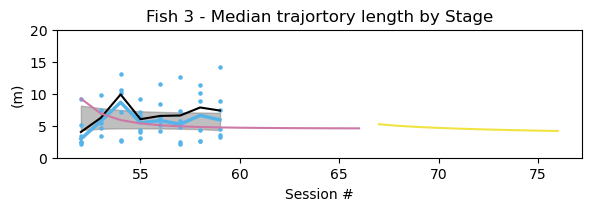

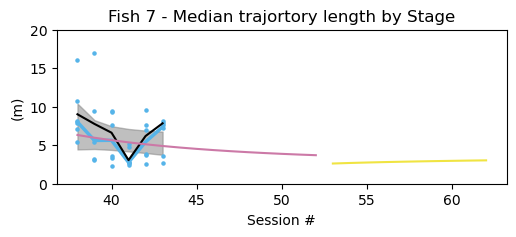

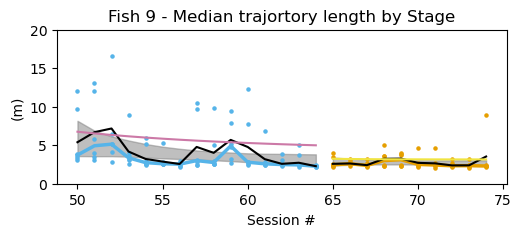

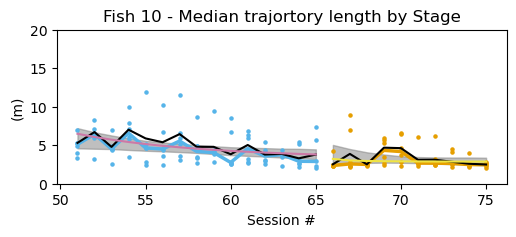

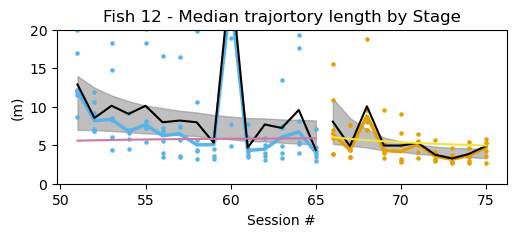

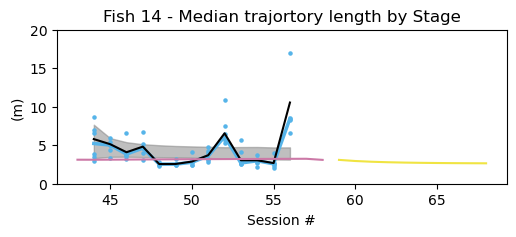

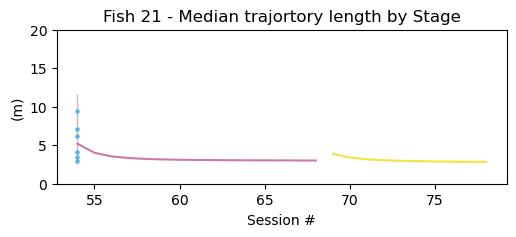

In [67]:
# Iterate over each unique combination of fish and stage to create plots
for fish in ppcplot_df_day['fish'].unique():
    plt.figure(figsize=(5.8, 2))  # Set figure size
    plt.style.use('default')
    for i, stage in enumerate(stages_ReRReW):
# Filter data for the current fish and stage
        data_filter = ppcplot_df_day[(ppcplot_df_day['fish'] == fish) & (ppcplot_df_day['stage'] == stage)]
        data_filter2 = y_obd_plot[(y_obd_plot['fish'] == fish) & (y_obd_plot['stage'] == stage)]
        # Plot mean_y against plotday for the current stage
        plt.plot(data_filter['plotday'], data_filter['median_y'], label=f'Median Y - {stage}', color=phase_colors[stage], linewidth=2.5)
        # plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_y'], label=f'Median μ_μ_y - {stage}',color='black')
        plt.plot(data_filter['plotday'], data_filter['y_gamma_medians'], label=f'y_gamma_medians - {stage}', color='black')
       # plt.plot(data_filter['plotday'], data_filter['median_y'], label=f'Median Y - {stage}', color='black')
                 # Plot mean_y against plotday for the current stage
        # plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_hdi_3'] ,label=f'mean_μ_μ_hdi_3 - {stage}', color=phase_colors[stage], alpha=0.5,)
        # plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_hdi_97'] ,label=f'mean_μ_μ_hdi_97 - {stage}', color=phase_colors[stage], alpha=0.5,)
        
    #    plt.fill_between(data_filter['plotday'], data_filter['mean_μ_hdi_3'], data_filter['mean_μ_hdi_97'],color=phase_colors[stage], alpha=0.5, label=f'HDI μ - {stage}')
         # Plot HDI (mean_μ_μ_hdi_3% to mean_μ_μ_hdi_97%) as shaded region
        plt.fill_between(data_filter['plotday'], data_filter['μ_hdi_3_gamma_medians'], data_filter['μ_hdi_97_gamma_medians'],color='grey', alpha=0.5, label=f'HDI μ_μ - {stage}')
        # plt.plot(data_filter['plotday'], data_filter['mean_ppc_hdi_3'] ,label=f'mean_ppc_hdi_3 - {stage}', color=phase_colors[stage], alpha=0.3,)
        # plt.plot(data_filter['plotday'], data_filter['mean_ppc_hdi_97'] ,label=f'mean_ppc_hdi_97 - {stage}', color=phase_colors[stage], alpha=0.3,)    

            # Plot PPC HDI (mean_ppc_hdi_3% to mean_ppc_hdi_97%) as shaded region
        # plt.fill_between(data_filter['plotday'], data_filter['mean_ppc_hdi_3'], data_filter['mean_ppc_hdi_97'],
        #                     color=phase_colors[stage], alpha=0.1, label=f'HDI PPC - {stage}')
        plt.scatter(data_filter2['plotday'],data_filter2['y'],color=phase_colors[stage],s =5)
    for i, stage in enumerate(stages_RW):
        data_filter3 = ppcplot_df_day[(ppcplot_df_day['fish'] == fish) & (ppcplot_df_day['stage'] == stage)]
        plt.plot(data_filter3['plotday']+25, data_filter3['median_μ_μ_y'], label=f'Median μ_μ_y - {stage}',color=phase_colors[stage])
    plt.xlabel('Session #')  # Set x-axis label
    plt.ylabel('(m)')   # Set y-axis label
    plt.title(f'Fish {fish} - Median trajortory length by Stage')  # Set plot title
    # plt.legend( bbox_to_anchor=(1, 1))
       # Set fixed data ranges for both axes
    plt.ylim((0,20))
    plt.grid(False)  # Show grid
    Exampelplotfolder = os.path.join(plotfolder,'example/')
    plt.savefig(os.path.join(Exampelplotfolder, f'{fish}Figure5D.png'), bbox_inches='tight', dpi=600)


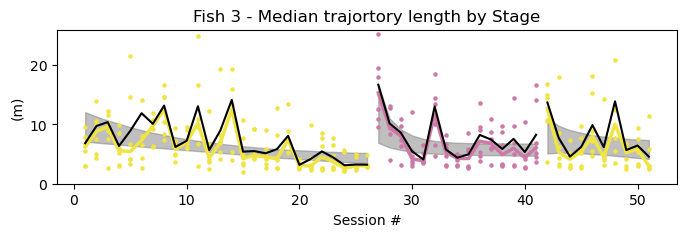

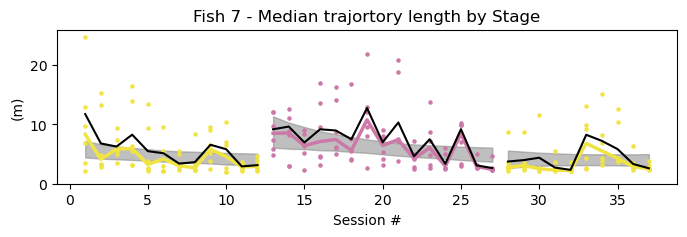

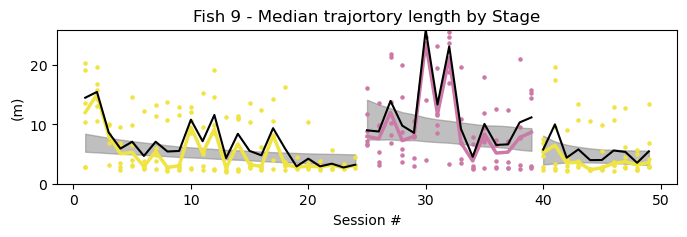

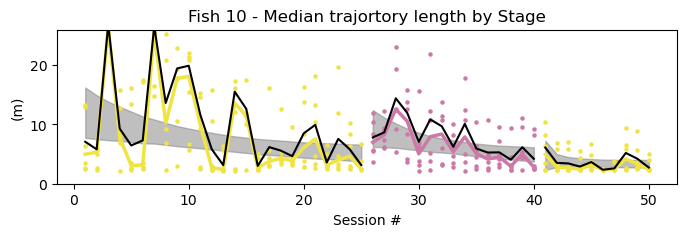

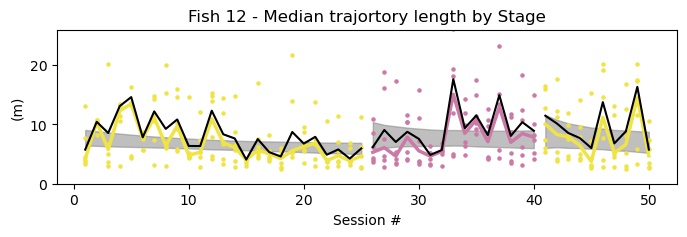

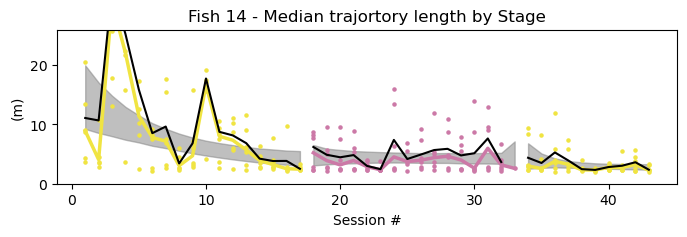

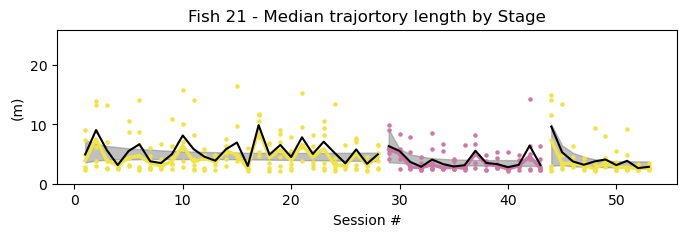

In [68]:
# Iterate over each unique combination of fish and stage to create plots
for fish in ppcplot_df_day['fish'].unique():
    plt.figure(figsize=(8, 2))  # Set figure size
    plt.style.use('default')
    for i, stage in enumerate(stages_BWR):
# Filter data for the current fish and stage
        data_filter = ppcplot_df_day[(ppcplot_df_day['fish'] == fish) & (ppcplot_df_day['stage'] == stage)]
        data_filter2 = y_obd_plot[(y_obd_plot['fish'] == fish) & (y_obd_plot['stage'] == stage)]
        # Plot mean_y against plotday for the current stage
        plt.plot(data_filter['plotday'], data_filter['median_y'], label=f'Median Y - {stage}', color=phase_colors[stage], linewidth=2.5)
        plt.plot(data_filter['plotday'], data_filter['y_gamma_medians'], label=f'y_gamma_medians - {stage}', color='black')
       # plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_y'], label=f'Mean μ_μ_y - {stage}',color='black')
       # plt.plot(data_filter['plotday'], data_filter['median_y'], label=f'Median Y - {stage}', color='black')
                 # Plot mean_y against plotday for the current stage
        # plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_hdi_3'] ,label=f'mean_μ_μ_hdi_3 - {stage}', color=phase_colors[stage], alpha=0.5,)
        # plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_hdi_97'] ,label=f'mean_μ_μ_hdi_97 - {stage}', color=phase_colors[stage], alpha=0.5,)
        
    #    plt.fill_between(data_filter['plotday'], data_filter['mean_μ_hdi_3'], data_filter['mean_μ_hdi_97'],color=phase_colors[stage], alpha=0.5, label=f'HDI μ - {stage}')
         # Plot HDI (mean_μ_μ_hdi_3% to mean_μ_μ_hdi_97%) as shaded region
        #plt.fill_between(data_filter['plotday'], data_filter['mean_μ_μ_hdi_3'], data_filter['mean_μ_μ_hdi_97'],color='grey', alpha=0.5, label=f'HDI μ_μ - {stage}')
        plt.fill_between(data_filter['plotday'], data_filter['μ_hdi_3_gamma_means'], data_filter['μ_hdi_97_gamma_means'],color='grey', alpha=0.5, label=f'HDI μ_μ - {stage}')
        # plt.plot(data_filter['plotday'], data_filter['mean_ppc_hdi_3'] ,label=f'mean_ppc_hdi_3 - {stage}', color=phase_colors[stage], alpha=0.3,)
        # plt.plot(data_filter['plotday'], data_filter['mean_ppc_hdi_97'] ,label=f'mean_ppc_hdi_97 - {stage}', color=phase_colors[stage], alpha=0.3,)    

            # Plot PPC HDI (mean_ppc_hdi_3% to mean_ppc_hdi_97%) as shaded region
        # plt.fill_between(data_filter['plotday'], data_filter['mean_ppc_hdi_3'], data_filter['mean_ppc_hdi_97'],
        #                     color=phase_colors[stage], alpha=0.1, label=f'HDI PPC - {stage}')
        plt.scatter(data_filter2['plotday'],data_filter2['y'],color=phase_colors[stage],s =5)
    
    plt.xlabel('Session #')  # Set x-axis label
    plt.ylabel('(m)')   # Set y-axis label
    plt.title(f'Fish {fish} - Median trajortory length by Stage')  # Set plot title
    # plt.legend( bbox_to_anchor=(1, 1))
       # Set fixed data ranges for both axes
    plt.ylim((0,26))
    plt.grid(False)  # Show grid
    # Save the plot to a file
    Exampelplotfolder = os.path.join(plotfolder,'example/')
    plt.savefig(os.path.join(Exampelplotfolder, f'{fish}Figure3D.png'), bbox_inches='tight', dpi=600)


In [69]:
# # Iterate over each unique combination of fish and stage to create plots
# for fish in ppcplot_df_day['fish'].unique():
#     plt.figure(figsize=(14, 4.8))  # Set figure size
#     plt.style.use('default')
#     for i, stage in enumerate(stages):
# # Filter data for the current fish and stage
#         data_filter = ppcplot_df_day[(ppcplot_df_day['fish'] == fish) & (ppcplot_df_day['stage'] == stage)]
#         data_filter2 = y_obd_plot[(y_obd_plot['fish'] == fish) & (y_obd_plot['stage'] == stage)]
#         # Plot mean_y against plotday for the current stage
#       #  plt.plot(data_filter['plotday'], data_filter['mean_y'], label=f'Mean Y - {stage}',color=phase_colors[stage])
#         plt.plot(data_filter['plotday'], data_filter['y_gamma_means'], label=f'y_gamma_medians - {stage}', color='black')
#                  # Plot mean_y against plotday for the current stage
#         # plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_hdi_3'] ,label=f'mean_μ_μ_hdi_3 - {stage}', color=phase_colors[stage], alpha=0.5,)
#         # plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_hdi_97'] ,label=f'mean_μ_μ_hdi_97 - {stage}', color=phase_colors[stage], alpha=0.5,)
#      #   plt.fill_between(data_filter['plotday'], data_filter['μ_hdi_3_gamma_medians'], data_filter['μ_hdi_97_gamma_medians'],color=phase_colors[stage], alpha=0.5, label=f'HDI μ - {stage}')
#       #  plt.fill_between(data_filter['plotday'], data_filter['median_μ_hdi_3'], data_filter['median_μ_hdi_97'],color=phase_colors[stage], alpha=0.5, label=f'HDI μ - {stage}')
#          # Plot HDI (mean_μ_μ_hdi_3% to mean_μ_μ_hdi_97%) as shaded region
#         plt.fill_between(data_filter['plotday'], data_filter['median_μ_μ_hdi_3'], data_filter['median_μ_μ_hdi_97'],color=phase_colors[stage], alpha=1, label=f'HDI μ_μ - {stage}')
#         # plt.plot(data_filter['plotday'], data_filter['mean_ppc_hdi_3'] ,label=f'mean_ppc_hdi_3 - {stage}', color=phase_colors[stage], alpha=0.3,)
#         # plt.plot(data_filter['plotday'], data_filter['mean_ppc_hdi_97'] ,label=f'mean_ppc_hdi_97 - {stage}', color=phase_colors[stage], alpha=0.3,)    

#             # Plot PPC HDI (mean_ppc_hdi_3% to mean_ppc_hdi_97%) as shaded region
#         plt.fill_between(data_filter['plotday'], data_filter['median_ppc_hdi_3'], data_filter['median_ppc_hdi_97'],
#                             color=phase_colors[stage], alpha=0.1, label=f'HDI PPC - {stage}')
#         plt.scatter(data_filter2['plotday'],data_filter2['y'],color= 'black',s =1)
    
#     plt.xlabel('Plot Day')  # Set x-axis label
#     plt.ylabel('Median Distance(m)')   # Set y-axis label
#     plt.title(f'Fish {fish} - Median Distance by Stage')  # Set plot title
#    # plt.legend( bbox_to_anchor=(1, 1))
#        # Set fixed data ranges for both axes
#     plt.ylim((0,25))
#     plt.grid(True)  # Show grid
#     plt.show()  # Display the plot


In [70]:
# # Iterate over each unique combination of fish and stage to create plots
# for fish in ppcplot_df_day['fish'].unique():
#     plt.figure(figsize=(14, 4.8))  # Set figure size
#     plt.style.use('default')
#     for i, stage in enumerate(stages):
# # Filter data for the current fish and stage
#         data_filter = ppcplot_df_day[(ppcplot_df_day['fish'] == fish) & (ppcplot_df_day['stage'] == stage)]
#         data_filter2 = y_obd_plot[(y_obd_plot['fish'] == fish) & (y_obd_plot['stage'] == stage)]
#         # Plot mean_y against plotday for the current stage
#        # plt.plot(data_filter['plotday'], data_filter['mean_y'], label=f'Mean Y - {stage}', color='black')
#         plt.plot(data_filter['plotday'], (data_filter['mean_μ_μ_hdi_3']+data_filter['mean_μ_μ_hdi_97'])/2, label=f'y_gamma_means - {stage}',color='black')
#         plt.plot(data_filter['plotday'], data_filter['y_gamma'], label=f'y_means - {stage}', color=phase_colors[stage], linewidth=2.5)
#                  # Plot mean_y against plotday for the current stage
#         # plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_hdi_3'] ,label=f'mean_μ_μ_hdi_3 - {stage}', color=phase_colors[stage], alpha=0.5,)
#         # plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_hdi_97'] ,label=f'mean_μ_μ_hdi_97 - {stage}', color=phase_colors[stage], alpha=0.5,)
       
#     #    plt.fill_between(data_filter['plotday'], data_filter['μ_hdi_3_gamma_means'], data_filter['μ_hdi_97_gamma_means'],color=phase_colors[stage], alpha=0.5, label=f'HDI μ - {stage}')
#         #plt.fill_between(data_filter['plotday'], data_filter['mean_μ_hdi_3'], data_filter['mean_μ_hdi_97'],color=phase_colors[stage], alpha=0.5, label=f'HDI μ - {stage}')
#          # Plot HDI (mean_μ_μ_hdi_3% to mean_μ_μ_hdi_97%) as shaded region
#         plt.fill_between(data_filter['plotday'], data_filter['mean_μ_μ_hdi_3'], data_filter['mean_μ_μ_hdi_97'],color='grey', alpha=0.3, label=f'HDI μ_μ - {stage}')
#         # plt.plot(data_filter['plotday'], data_filter['mean_ppc_hdi_3'] ,label=f'mean_ppc_hdi_3 - {stage}', color=phase_colors[stage], alpha=0.3,)
#         # plt.plot(data_filter['plotday'], data_filter['mean_ppc_hdi_97'] ,label=f'mean_ppc_hdi_97 - {stage}', color=phase_colors[stage], alpha=0.3,)    

#             # Plot PPC HDI (mean_ppc_hdi_3% to mean_ppc_hdi_97%) as shaded region
#         # plt.fill_between(data_filter['plotday'], data_filter['mean_ppc_hdi_3'], data_filter['mean_ppc_hdi_97'],
#         #                     color=phase_colors[stage], alpha=0.1, label=f'HDI PPC - {stage}')
#         plt.scatter(data_filter2['plotday'],data_filter2['y'],color=phase_colors[stage],s =2.4)
    
#     plt.xlabel('Plot Day')  # Set x-axis label
#     plt.ylabel('Mean Distance(m)')   # Set y-axis label
#     plt.title(f'Fish {fish} - Mean Distance by Stage')  # Set plot title
#   #  plt.legend( bbox_to_anchor=(1, 1))
#        # Set fixed data ranges for both axes
#     plt.ylim((0,25))
#     plt.grid(False)  # Show grid
#     plt.show()  # Display the plot


In [71]:
# # Iterate over each unique combination of fish and stage to create plots
# for fish in ppcplot_df_day['fish'].unique():
#     plt.figure(figsize=(14, 4.8))  # Set figure size
    
#     for i, stage in enumerate(stages):
# # Filter data for the current fish and stage
#         data_filter = ppcplot_df_day[(ppcplot_df_day['fish'] == fish) & (ppcplot_df_day['stage'] == stage)]
#         data_filter2 = y_obd_plot[(y_obd_plot['fish'] == fish) & (y_obd_plot['stage'] == stage)]
#         # Plot mean_y against plotday for the current stage
#        # plt.plot(data_filter['plotday'], data_filter['mean_y'], label=f'Mean Y - {stage}', color='black')
#         plt.plot(data_filter['plotday'], data_filter['mean_y'], label=f'Mean Y - {stage}', color='black')
#         plt.plot(data_filter['plotday'], data_filter['y_gamma'], label=f'y_gamma_means - {stage}', color=phase_colors[stage])
#                  # Plot mean_y against plotday for the current stage
#         # plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_hdi_3'] ,label=f'mean_μ_μ_hdi_3 - {stage}', color=phase_colors[stage], alpha=0.5,)
#         # plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_hdi_97'] ,label=f'mean_μ_μ_hdi_97 - {stage}', color=phase_colors[stage], alpha=0.5,)
   
#         plt.fill_between(data_filter['plotday'], data_filter['μ_hdi_3_gamma_means'], data_filter['μ_hdi_97_gamma_means'],color=phase_colors[stage], alpha=0.5, label=f'HDI μ - {stage}')
#         #plt.fill_between(data_filter['plotday'], data_filter['mean_μ_hdi_3'], data_filter['mean_μ_hdi_97'],color=phase_colors[stage], alpha=0.5, label=f'HDI μ - {stage}')
#          # Plot HDI (mean_μ_μ_hdi_3% to mean_μ_μ_hdi_97%) as shaded region
#       # plt.fill_between(data_filter['plotday'], data_filter['mean_μ_μ_hdi_3'], data_filter['mean_μ_μ_hdi_97'],color=phase_colors[stage], alpha=1, label=f'HDI μ_μ - {stage}')
#         # plt.plot(data_filter['plotday'], data_filter['mean_ppc_hdi_3'] ,label=f'mean_ppc_hdi_3 - {stage}', color=phase_colors[stage], alpha=0.3,)
#         # plt.plot(data_filter['plotday'], data_filter['mean_ppc_hdi_97'] ,label=f'mean_ppc_hdi_97 - {stage}', color=phase_colors[stage], alpha=0.3,)    

#             # Plot PPC HDI (mean_ppc_hdi_3% to mean_ppc_hdi_97%) as shaded region
#         plt.fill_between(data_filter['plotday'], data_filter['mean_ppc_hdi_3'], data_filter['mean_ppc_hdi_97'],
#                             color=phase_colors[stage], alpha=0.1, label=f'HDI PPC - {stage}')
#         plt.scatter(data_filter2['plotday'],data_filter2['y'],color= 'black',s =1)
    
#     plt.xlabel('Plot Day')  # Set x-axis label
#     plt.ylabel('Mean Distance(m)')   # Set y-axis label
#     plt.title(f'Fish {fish} - Mean Distance by Stage')  # Set plot title
#   #  plt.legend( bbox_to_anchor=(1, 1))
#        # Set fixed data ranges for both axes
#     plt.ylim((0,25))
#     plt.grid(True)  # Show grid
#     plt.show()  # Display the plot


array([[<Axes: title={'center': 'A_μμ\n3'}>,
        <Axes: title={'center': 'A_μμ\n7'}>,
        <Axes: title={'center': 'A_μμ\n9'}>],
       [<Axes: title={'center': 'A_μμ\n10'}>,
        <Axes: title={'center': 'A_μμ\n12'}>,
        <Axes: title={'center': 'A_μμ\n14'}>],
       [<Axes: title={'center': 'A_μμ\n21'}>, <Axes: >, <Axes: >]],
      dtype=object)

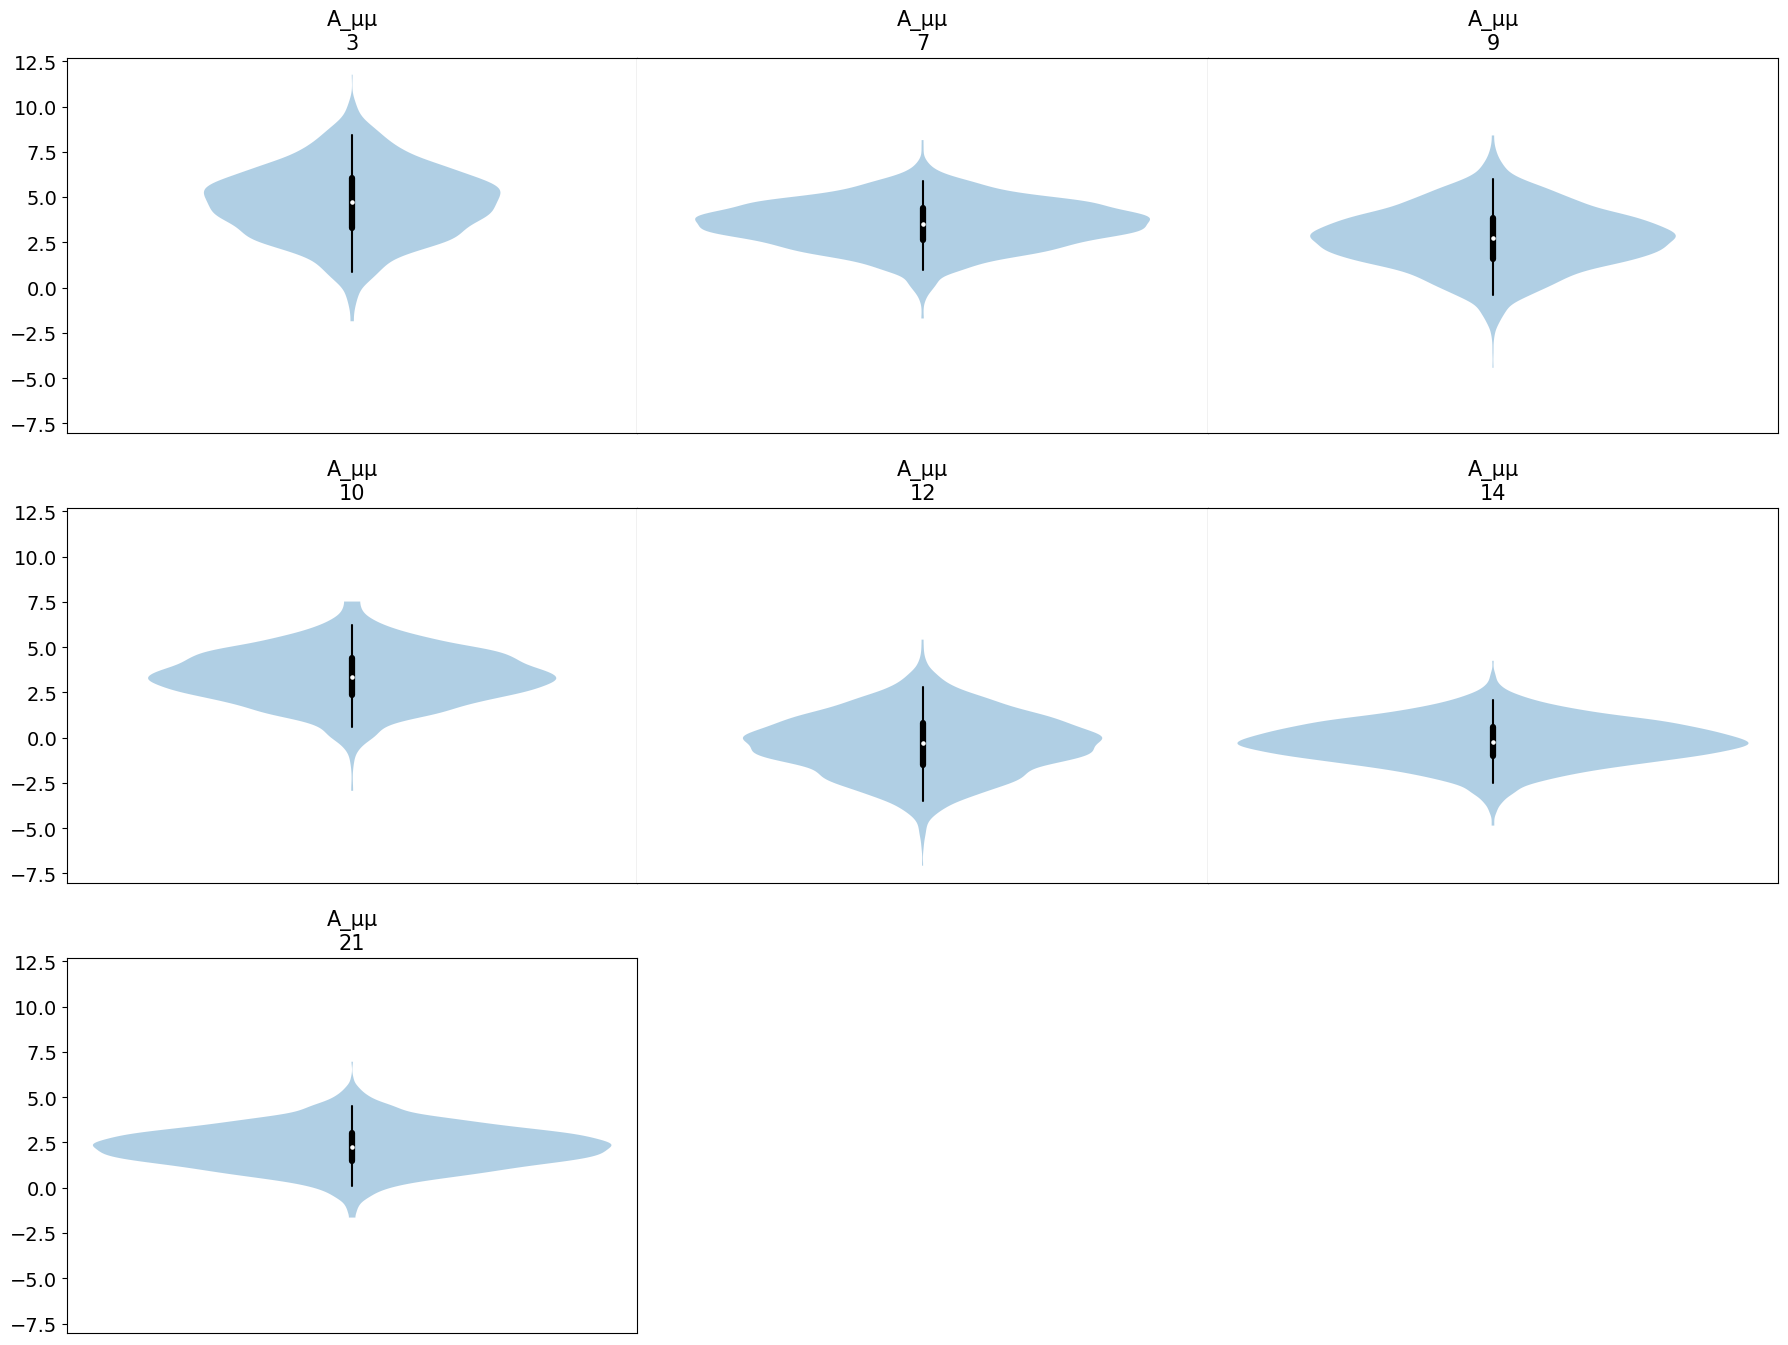

In [72]:

# Specify the variable names (parameters) you want to plot
var_names = ['A_μμ']  # Example: Replace with your desired variable names
dfr = posterior.sel({'stages':'Rotation' })
# Plot violin plot for selected variables
az.plot_violin(data=dfr, var_names=var_names)



array([[<Axes: title={'center': 'A_μμ\n3'}>,
        <Axes: title={'center': 'A_μμ\n7'}>,
        <Axes: title={'center': 'A_μμ\n9'}>],
       [<Axes: title={'center': 'A_μμ\n10'}>,
        <Axes: title={'center': 'A_μμ\n12'}>,
        <Axes: title={'center': 'A_μμ\n14'}>],
       [<Axes: title={'center': 'A_μμ\n21'}>, <Axes: >, <Axes: >]],
      dtype=object)

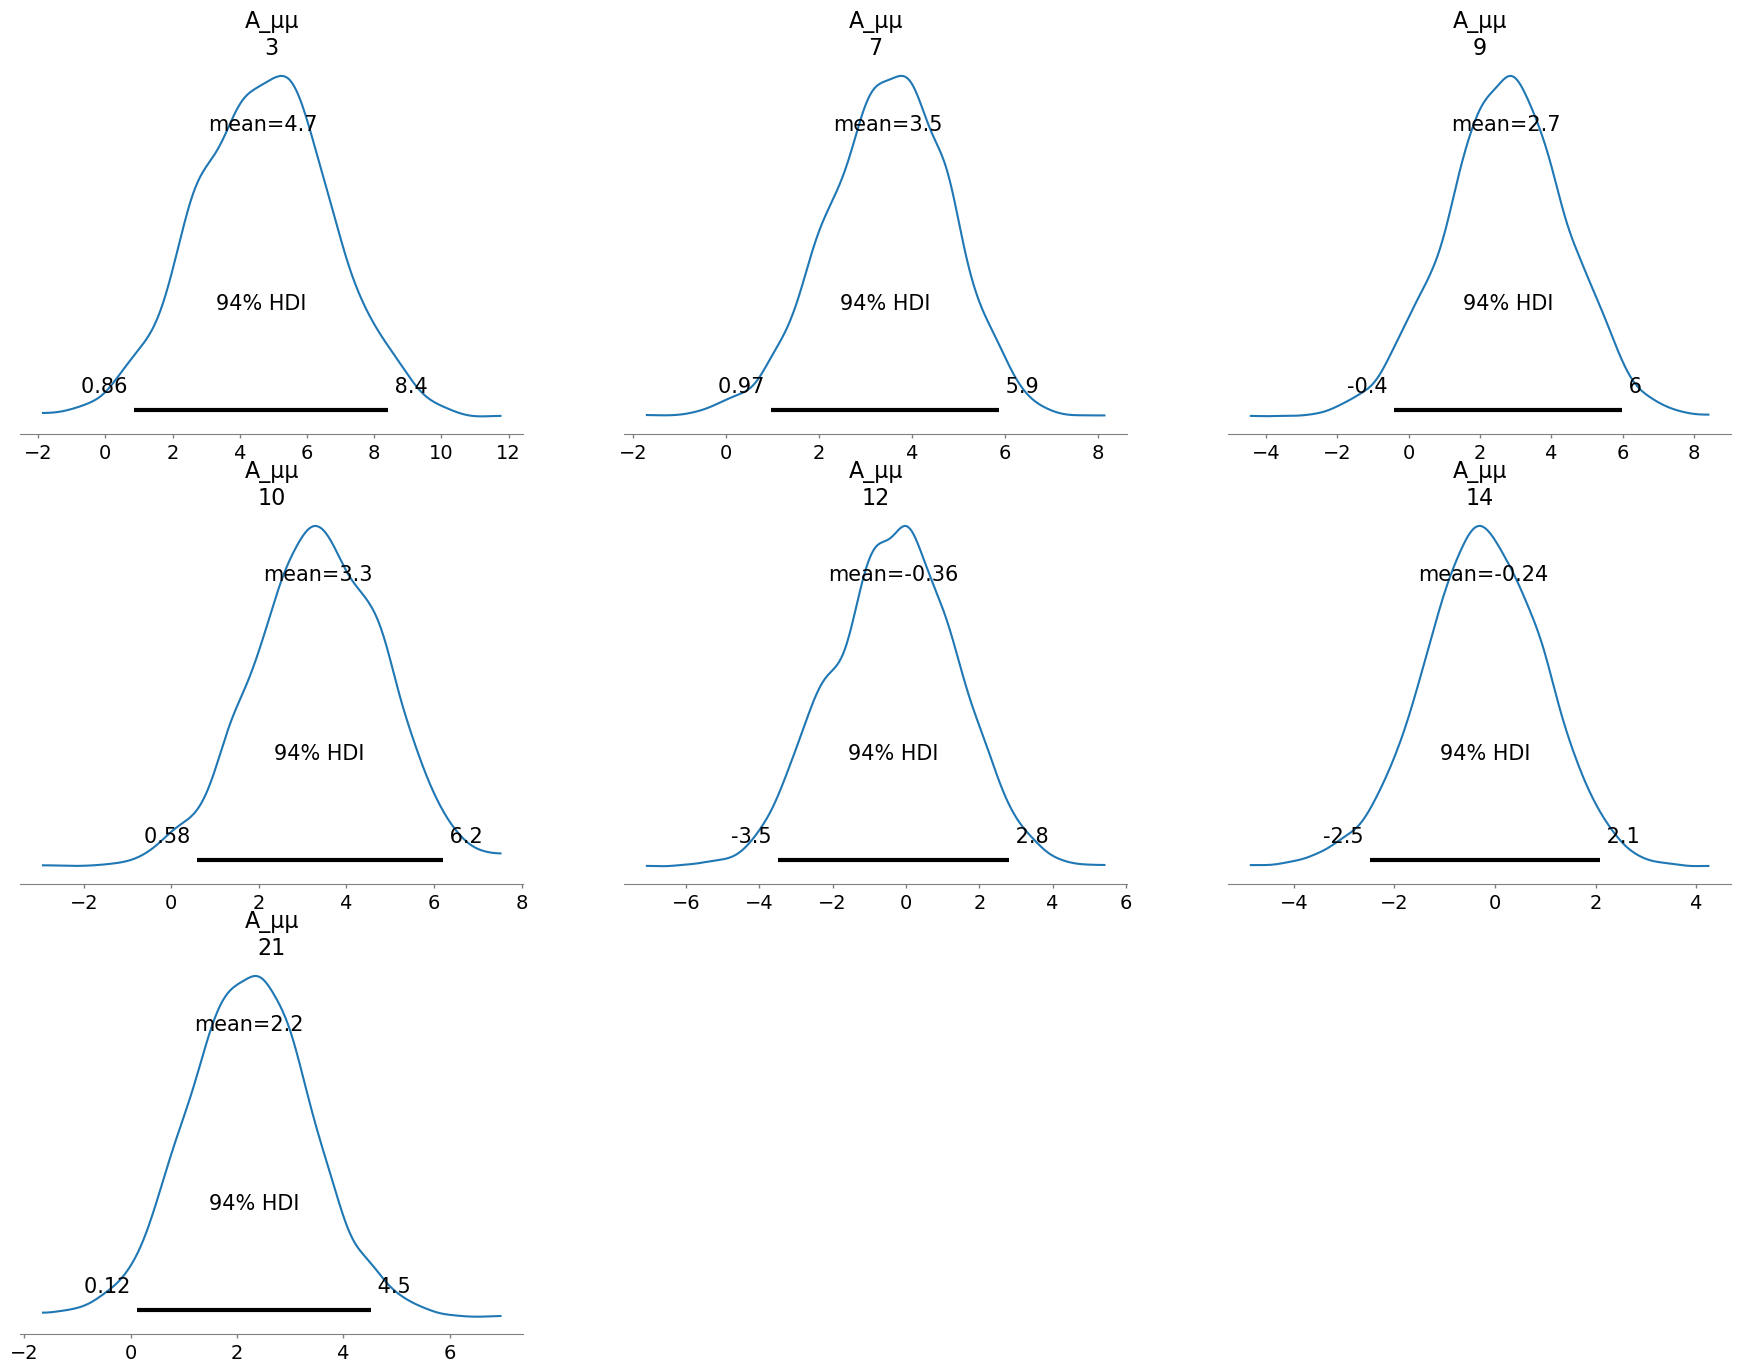

In [73]:
az.plot_posterior(posterior, var_names=['A_μμ'], coords={'stages': 'Rotation'})

array([[<Axes: title={'center': 'A_μμ\n3'}>,
        <Axes: title={'center': 'A_μμ\n7'}>,
        <Axes: title={'center': 'A_μμ\n9'}>],
       [<Axes: title={'center': 'A_μμ\n10'}>,
        <Axes: title={'center': 'A_μμ\n12'}>,
        <Axes: title={'center': 'A_μμ\n14'}>],
       [<Axes: title={'center': 'A_μμ\n21'}>, <Axes: >, <Axes: >]],
      dtype=object)

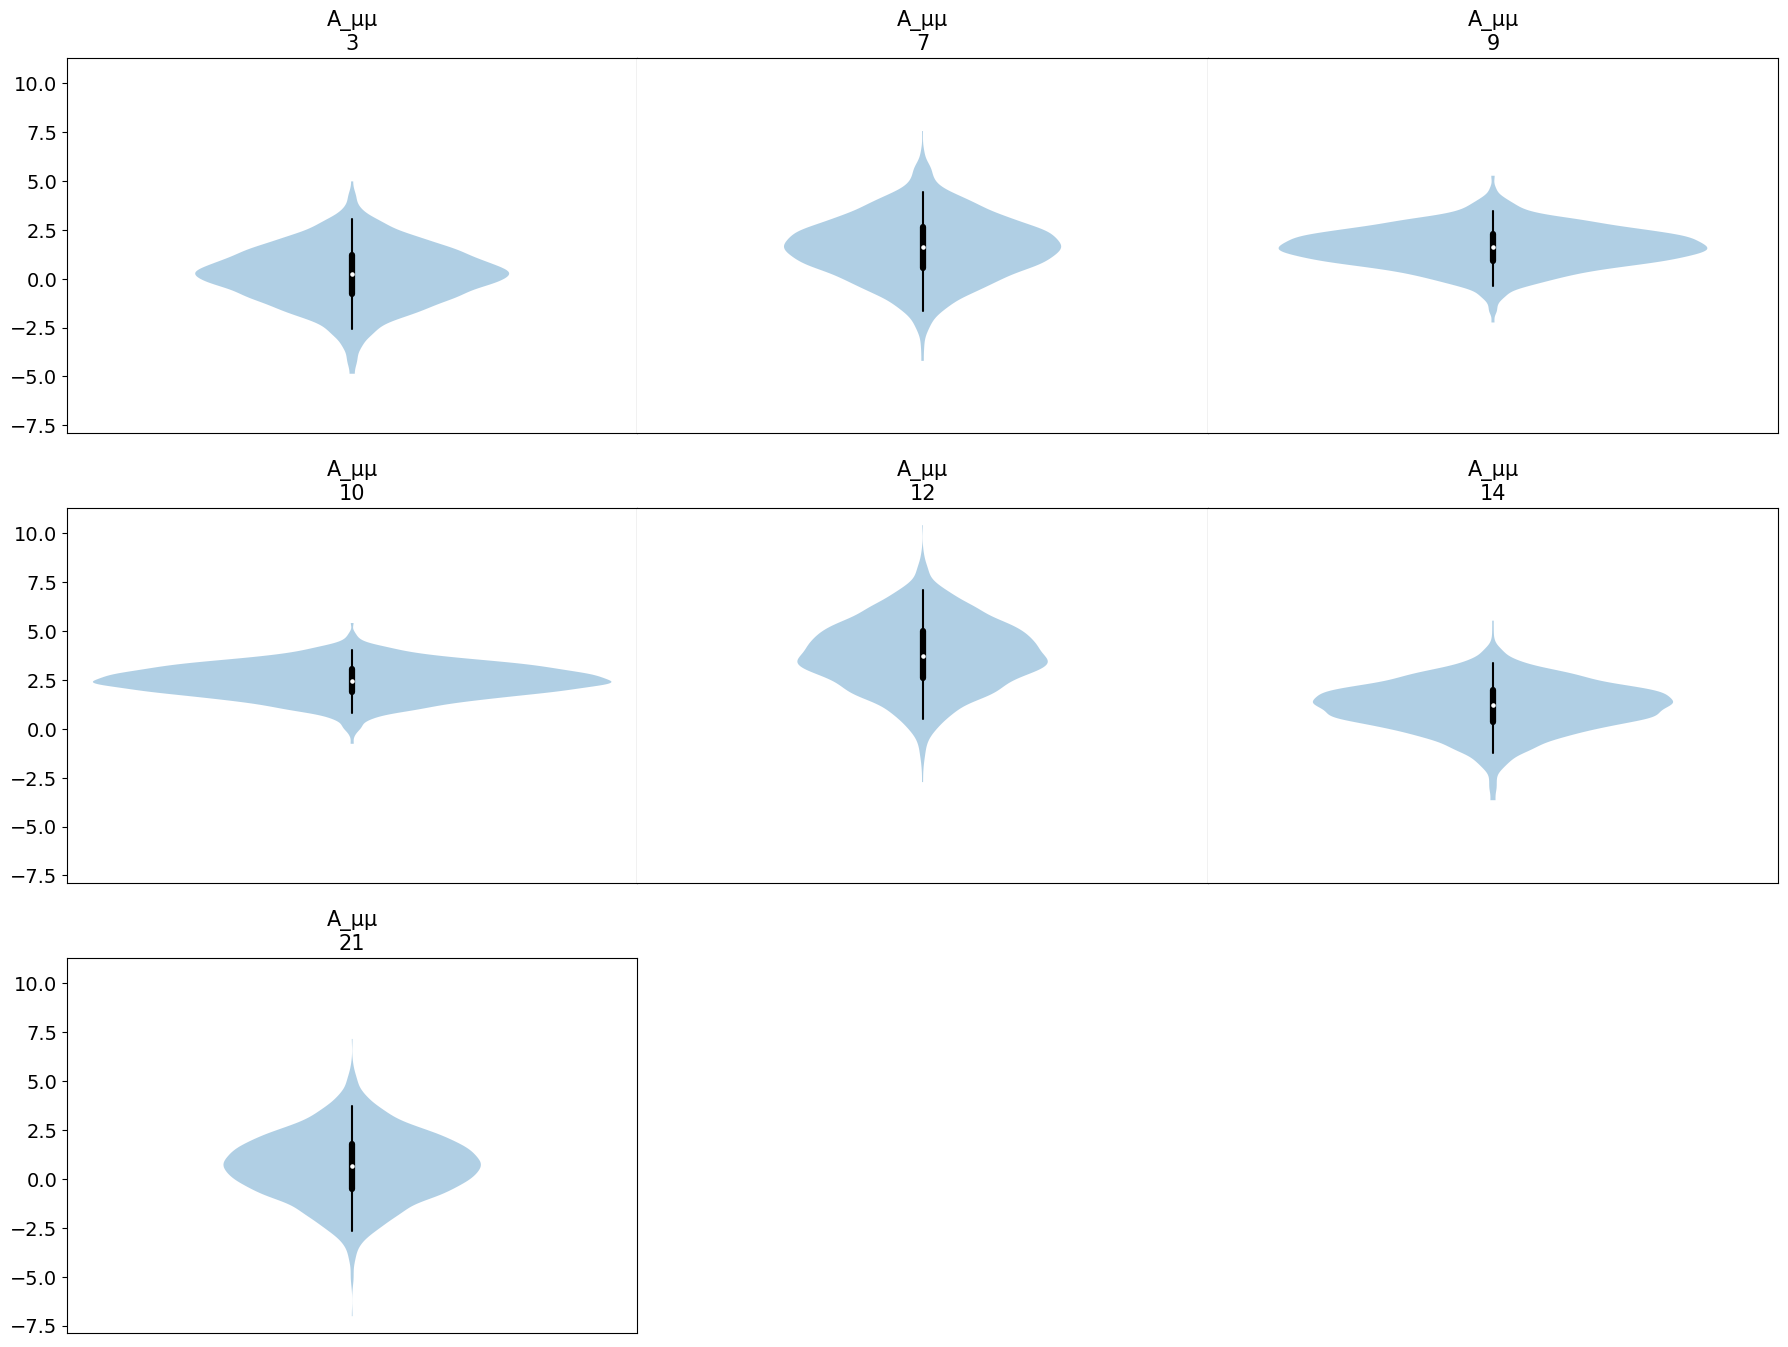

In [74]:

# Specify the variable names (parameters) you want to plot
var_names = ['A_μμ']  # Example: Replace with your desired variable names
dfrr = posterior.sel({'stages':'ReRotation' })
# Plot violin plot for selected variables
az.plot_violin(data=dfrr, var_names=var_names)



In [75]:
μ_A_μμ_across = dfrr.A_μμ.mean(dim='fish')

c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.05, 'μ_Aμμ across fish')

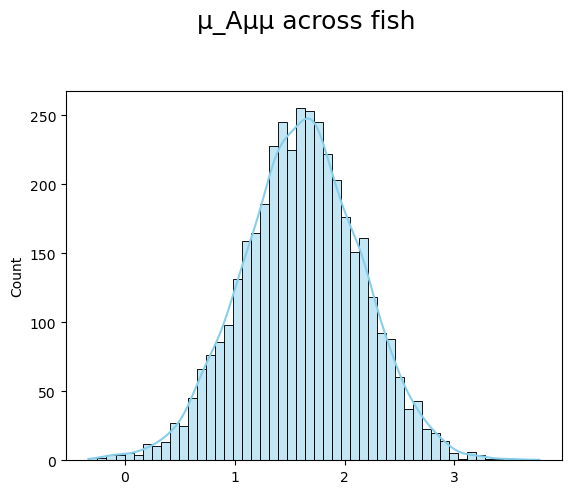

In [76]:
# Flatten the data array to a 1-dimensional numpy array
μ_Aμμ_Rdata = μ_A_μμ_across.values.flatten()
sns.histplot(μ_Aμμ_Rdata, bins=50, kde=True, color='skyblue')
plt.suptitle('μ_Aμμ across fish', fontsize=18, y=1.05)  # Adjust fontsize and y position as needed

In [77]:
# LR = posterior.A_μμ * posterior.τ_μ

# dfrr = LR.sel({'stages':'ReRotation' })
# # Plot violin plot for selected variables
# az.plot_violin(data=dfrr)
# # Set a larger title for the plot
# # Set a larger title above the plot

# plt.suptitle('Learning Rate', fontsize=16, y=1.05)  # Adjust fontsize and y position as needed
# plt.ylim((-100,100))


In [78]:
#az.plot_trace(posterior, var_names=['μ_Aμμ '], coords={'stages': 'Rotation'});

In [79]:

# #az.plot_trace(LR, coords={'stages': 'Rotation'});
# az.plot_posterior(LR, coords={'stages': 'Rotation'})
# # Set a larger title above the plot
# plt.suptitle('Learning Rate', fontsize=28, y=1.05)  # Adjust fontsize and y position as needed


In [80]:
# LR_R = LR.sel({'stages':'Rotation' })

In [81]:
# # Flatten the data array to a 1-dimensional numpy array
# flattened_data = LR_R.values.flatten()
# sns.histplot(flattened_data, bins=50, kde=True, color='skyblue')
# plt.suptitle('Learning rates across fish', fontsize=18, y=1.05)  # Adjust fontsize and y position as needed

In [82]:
σ_μ_inf_B = az.summary(id_yds_numpyro, var_names=['σ_μ_inf'], coords={'stages': ['Baseline']})
σ_μ_inf_W = az.summary(id_yds_numpyro, var_names=['σ_μ_inf'], coords={'stages': ['Washout']})
A_μμ_R = az.summary(id_yds_numpyro, var_names=['A_μμ'], coords={'stages': ['Rotation']})
A_μμ_ReR = az.summary(id_yds_numpyro, var_names=['A_μμ'], coords={'stages': ['ReRotation']})
τ_μ_ReR = az.summary(id_yds_numpyro, var_names=['τ_μ'], coords={'stages': ['ReRotation']})
τ_μ_R = az.summary(id_yds_numpyro, var_names=['τ_μ'], coords={'stages': ['Rotation']})
μ_μ_inf_R = az.summary(id_yds_numpyro, var_names=['μ_μ_inf'], coords={'stages': ['Rotation']})
μ_μ_inf_ReR = az.summary(id_yds_numpyro, var_names=['μ_μ_inf'], coords={'stages': ['ReRotation']})


In [83]:
τ_μ_ReR = τ_μ_ReR.rename(columns={'sd': 'τ_μ_ReR_sd', 'mean': 'τ_μ_ReR_mean'})
τ_μ_R = τ_μ_R.rename(columns={'sd': 'τ_μ_R_sd', 'mean': 'τ_μ_R_mean'})
μ_μ_inf_R = μ_μ_inf_R.rename(columns={'sd': 'μ_μ_inf_R_sd', 'mean': 'μ_μ_inf_R_mean'})
μ_μ_inf_ReR = μ_μ_inf_ReR.rename(columns={'sd': 'μ_μ_inf_ReR_sd', 'mean': 'μ_μ_inf_ReR_mean'})
σ_μ_inf_B_sd = σ_μ_inf_B.rename(columns={'sd': 'σ_μ_inf_B_sd', 'mean': 'σ_μ_inf_B_mean'})
σ_μ_inf_W_sd = σ_μ_inf_W.rename(columns={'sd': 'σ_μ_inf_W_sd', 'mean': 'σ_μ_inf_W_mean'})
A_μμ_R_mean = A_μμ_R.rename(columns={'sd': 'A_μμ_R_sd', 'mean': 'A_μμ_R_mean'})
A_μμ_ReR_mean = A_μμ_ReR.rename(columns={'sd': 'A_μμ_ReR_sd', 'mean': 'A_μμ_ReR_mean'})


In [84]:
σ_μ_inf_B_sd = σ_μ_inf_B_sd.reset_index(drop=True) 
σ_μ_inf_W_sd = σ_μ_inf_W_sd.reset_index(drop=True) 
A_μμ_R_mean = A_μμ_R_mean.reset_index(drop=True) 
A_μμ_ReR_mean = A_μμ_ReR_mean.reset_index(drop=True) 
τ_μ_ReR = τ_μ_ReR.reset_index(drop=True) 
τ_μ_R = τ_μ_R.reset_index(drop=True) 
μ_μ_inf_R = μ_μ_inf_R.reset_index(drop=True) 
μ_μ_inf_ReR = μ_μ_inf_ReR.reset_index(drop=True) 

In [85]:
figure6plot_df=[]

In [86]:
figure6plot_df = pd.concat([σ_μ_inf_B_sd[['σ_μ_inf_B_sd','σ_μ_inf_B_mean']],A_μμ_R_mean[['A_μμ_R_sd','A_μμ_R_mean']],σ_μ_inf_W_sd[['σ_μ_inf_W_sd','σ_μ_inf_W_mean']],A_μμ_ReR_mean[['A_μμ_ReR_sd','A_μμ_ReR_mean']],τ_μ_ReR[['τ_μ_ReR_mean','τ_μ_ReR_sd']],τ_μ_R[['τ_μ_R_mean','τ_μ_R_sd']],μ_μ_inf_ReR[['μ_μ_inf_ReR_mean','μ_μ_inf_ReR_sd']],μ_μ_inf_R[['μ_μ_inf_R_mean','μ_μ_inf_R_sd']]], axis=1)
figure6plot_df['fish'] =['3','7','9','10','12','14','21']



In [87]:
Learn = (-1)*posterior.A_μμ / posterior.τ_μ
LearnReR = Learn.sel({'stages':'ReRotation' })
LearnReR = az.summary(LearnReR)
LearnR = Learn.sel({'stages':'Rotation' })
LearnR = az.summary(LearnR)

### Learning rate distribution of Rotation

c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.05, 'Learning rate across fish')

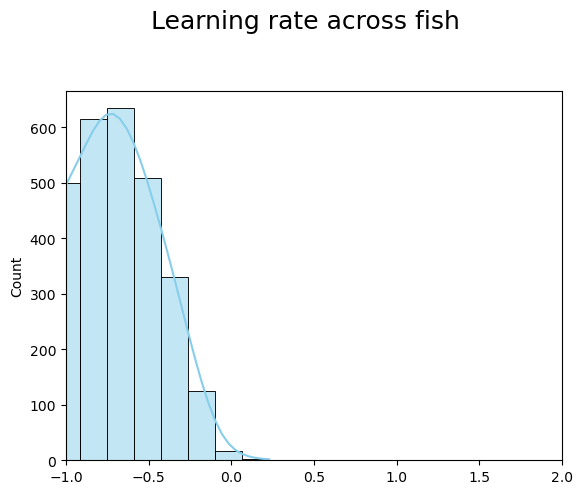

In [88]:
LR =(-1)*posterior.A_μμ / posterior.τ_μ
LR_R = LR.sel({'stages':'Rotation' })
LR_R_across = LR_R.mean(dim='fish')
LR_R_across = LR_R_across.values.flatten()
sns.histplot(LR_R_across, bins=50, kde=True, color='skyblue')
plt.xlim(-1,2)
plt.suptitle('Learning rate across fish', fontsize=18, y=1.05)  # Adjust fontsize and y position as needed

In [89]:
LR_across = LR.mean(dim='fish')
ALengthLR = az.summary(LR_across)
ALengthLR.to_csv('ALengthLR.csv')
ELengthLR = az.summary(LR)
ELengthLR.to_csv('ELengthLR.csv')

c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.05, 'Learning rates across Washout fish')

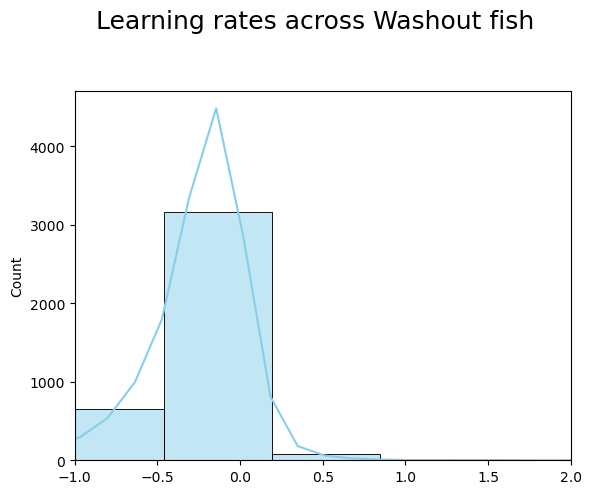

In [90]:

LR_W = LR.sel({'stages':'Washout' })
LR_W_across = LR_W.mean(dim='fish')
LR_W_across = LR_W_across.values.flatten()
sns.histplot(LR_W_across, bins=50, kde=True, color='skyblue')
plt.xlim(-1,2)
plt.suptitle('Learning rates across Washout fish', fontsize=18, y=1.05)  # Adjust fontsize and y position as needed

c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.05, 'Learning rate across Rerotation fish')

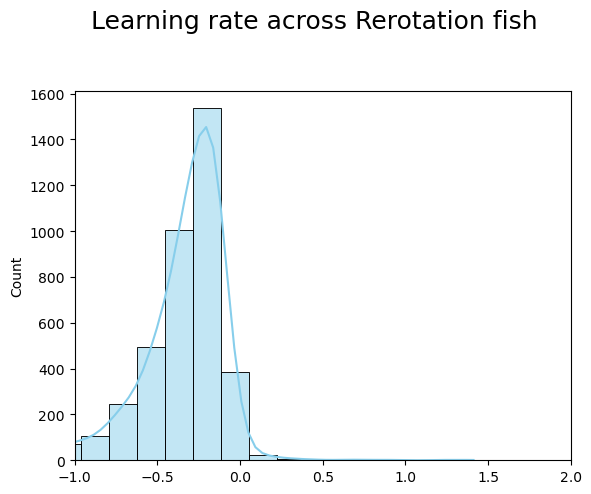

In [91]:

LR_ReR = LR.sel({'stages':'ReRotation' })
# Flatten the data array to a 1-dimensional numpy array
LR_ReR_across = LR_ReR.mean(dim='fish')
LR_ReR_across = LR_ReR_across.values.flatten()
sns.histplot(LR_ReR_across, bins=50, kde=True, color='skyblue')
plt.xlim(-1,2)
plt.suptitle('Learning rate across Rerotation fish', fontsize=18, y=1.05)  # Adjust fontsize and y position as needed # Adjust fontsize and y position as needed

In [92]:
LearnReR = LearnReR.rename(columns={'sd': 'Learn_ReR_sd', 'mean': 'Learn_ReR_mean'})
LearnReR = LearnReR.reset_index(drop=True) 
LearnR = LearnR.rename(columns={'sd': 'Learn_R_sd', 'mean': 'Learn_R_mean'})
LearnR = LearnR.reset_index(drop=True) 

In [93]:
figure7plot_df= []

figure7plot_df =pd.concat([LearnReR[['Learn_ReR_sd','Learn_ReR_mean']],LearnR[['Learn_R_sd','Learn_R_mean']]],axis = 1)

In [94]:
figure7plot_df['fish'] =['3','7','9','10','12','14','21']

In [95]:
figure7plot_df =pd.concat([figure7plot_df,figure6plot_df[['σ_μ_inf_W_sd','σ_μ_inf_B_sd']]],axis =1 )

In [96]:
# Assuming LR_R is your xarray.DataArray
# Flatten the DataArray and convert to a pandas DataFrame
df_R = LR_R.to_dataframe(name='LR').reset_index()
df_ReR = LR_ReR.to_dataframe(name='LR').reset_index()
# Assuming 'fish' is one of the dimensions and 'LR_Rdata' is the flattened data
# Select only 'LR_Rdata' and 'fish' columns
df_R = df_R[['LR', 'fish']]
df_R['session'] = 'Rotation'
df_ReR = df_ReR[['LR', 'fish']]
df_ReR['session'] = 'ReRotation'
df_vioLR = pd.concat([df_R[['LR', 'fish','session']],df_ReR[['LR','session','fish']]])
# Display the dataframe
print(df_vioLR)

             LR  fish     session
0     -0.762929     3    Rotation
1     -0.261609     7    Rotation
2     -0.049786     9    Rotation
3     -0.428861    10    Rotation
4     -0.007056    12    Rotation
...         ...   ...         ...
27995 -0.224585     9  ReRotation
27996 -0.212933    10  ReRotation
27997 -0.121739    12  ReRotation
27998 -4.233024    14  ReRotation
27999 -0.027321    21  ReRotation

[56000 rows x 3 columns]


In [97]:
# Assuming LR_R is your xarray.DataArray
# Flatten the DataArray and convert to a pandas DataFrame
df_R = LR_R.to_dataframe(name='LR_R').reset_index()
df_ReR = LR_ReR.to_dataframe(name='LR_ReR').reset_index()
# Assuming 'fish' is one of the dimensions and 'LR_Rdata' is the flattened data
# Select only 'LR_Rdata' and 'fish' columns
df_R = df_R[['LR_R', 'fish']]
df_R['session'] = 'Rotation'
df_ReR = df_ReR[['LR_ReR', 'fish']]
df_ReR['session'] = 'ReRotation'
df_kdeLR = pd.concat([df_R[['LR_R', 'fish','session']],df_ReR[['LR_ReR','session']]],axis =1)
# Display the dataframe
print(df_kdeLR)

           LR_R  fish   session    LR_ReR     session
0     -0.762929     3  Rotation -0.082759  ReRotation
1     -0.261609     7  Rotation -0.727636  ReRotation
2     -0.049786     9  Rotation -0.455966  ReRotation
3     -0.428861    10  Rotation -0.447936  ReRotation
4     -0.007056    12  Rotation -0.631701  ReRotation
...         ...   ...       ...       ...         ...
27995 -0.141744     9  Rotation -0.224585  ReRotation
27996 -0.405378    10  Rotation -0.212933  ReRotation
27997  0.044498    12  Rotation -0.121739  ReRotation
27998  0.050436    14  Rotation -4.233024  ReRotation
27999 -0.204920    21  Rotation -0.027321  ReRotation

[28000 rows x 5 columns]


In [98]:
LRReRmm = figure7plot_df['Learn_ReR_mean'].mean()
LRRmm = figure7plot_df['Learn_R_mean'].mean()

LR_arosfish  = LR.mean(dim= 'fish')
LR_A=LR_arosfish.to_dataframe(name='LR_A').reset_index()

(-3.0, 3.0)

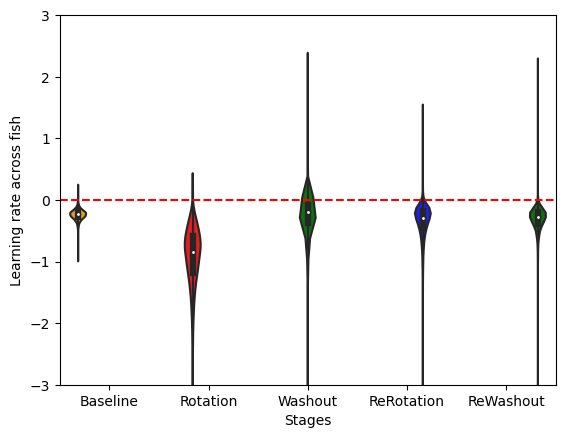

In [99]:
palette_colors = [ "orange",'red',"green",'blue','green']
sns.violinplot(data=LR_A, y="LR_A", x="stages",hue='stages',palette=palette_colors)

plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Stages')
plt.ylabel('Learning rate across fish')
plt.legend().set_visible(False)
plt.ylim(-3, 3)

In [100]:

LR_R_arosfish  = LR_R.mean(dim= 'fish')
LR_ReR_arosfish = LR_ReR.mean(dim= 'fish')
LR_R_A=LR_R_arosfish.to_dataframe(name='LR_R_A').reset_index()
LR_ReR_A=LR_ReR_arosfish.to_dataframe(name='LR_ReR_A').reset_index()

df_kdeLR_A = pd.concat([LR_R_A['LR_R_A'],LR_ReR_A['LR_ReR_A']],axis=1)
figure7plot_df =pd.concat([figure7plot_df,figure6plot_df[['σ_μ_inf_W_sd','σ_μ_inf_W_mean','σ_μ_inf_B_sd','σ_μ_inf_B_mean']]],axis =1 )

c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


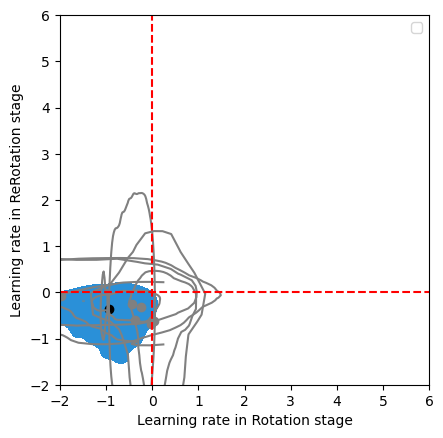

In [101]:

# Create the plot
fig, ax = plt.subplots()

# KDE plot
sns.kdeplot(
    data=df_kdeLR_A, x="LR_R_A", y="LR_ReR_A", fill=True, ax=ax, weights = 0.94,levels =2
)

# Assuming LR_R and LR_ReR are xarray.DataArray objects with a dimension 'fish'
fish_ids = LR_R.fish.values  # Get the fish IDs


for fish in fish_ids:
    ax = az.plot_kde(
        LR_R.sel(fish=fish),
        LR_ReR.sel(fish=fish),
        hdi_probs=[0.001,0.94],  # 1, 2 and 3 sigma contours
        contourf_kwargs={"cmap": 'BuPu_r', "alpha": 0.1},
        label=f'Fish {fish}'
    )
    plt.scatter(LR_R.sel(fish=fish).mean(),LR_ReR.sel(fish=fish).mean(),c='grey')
# Scatter plot
plt.scatter(x=LRRmm, y=LRReRmm,c='black')

# Set aspect ratio, limits, labels, and lines
ax.set_aspect("equal")
plt.axhline(y=0, color='red', linestyle='--')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlim(-2, 6)
plt.ylim(-2, 6)
plt.xlabel('Learning rate in Rotation stage')
plt.ylabel('Learning rate in ReRotation stage')
plt.legend()
plt.show()

c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


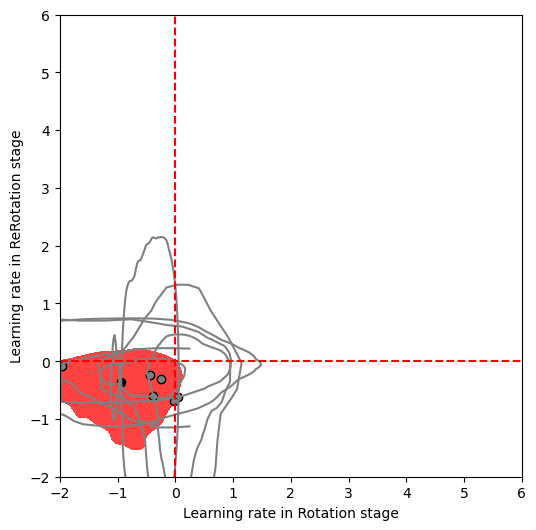

In [102]:
# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust the size of the figure

# KDE plot
sns.kdeplot(
    data=df_kdeLR_A, x="LR_R_A", y="LR_ReR_A", fill=True,color='red', ax=ax, levels=2, alpha=1
)

# Assuming LR_R and LR_ReR are xarray.DataArray objects with a dimension 'fish'
fish_ids = LR_R.fish.values  # Get the fish IDs

# Iterate over each fish and plot their KDE
for fish in fish_ids:
    ax = az.plot_kde(
        LR_R.sel(fish=fish),
        LR_ReR.sel(fish=fish),
        hdi_probs=[0.001, 0.94],  # 1 and 2 sigma contours
        contourf_kwargs={"cmap": 'BuPu_r', "alpha": 0.05},  # Make contours lighter
        ax=ax,
        plot_kwargs={"alpha": 0.1}  # Make lines lighter
    )
    # Scatter plot for mean points
    plt.scatter(LR_R.sel(fish=fish).mean(), LR_ReR.sel(fish=fish).mean(), c='grey', edgecolor='black')

# Scatter plot for overall means
plt.scatter(x=LRRmm, y=LRReRmm, c='black')

# Set aspect ratio, limits, labels, and lines
ax.set_aspect("equal")
plt.axhline(y=0, color='red', linestyle='--')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlim(-2, 6)
plt.ylim(-2, 6)
plt.xlabel('Learning rate in Rotation stage')
plt.ylabel('Learning rate in ReRotation stage')



plt.show()

c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


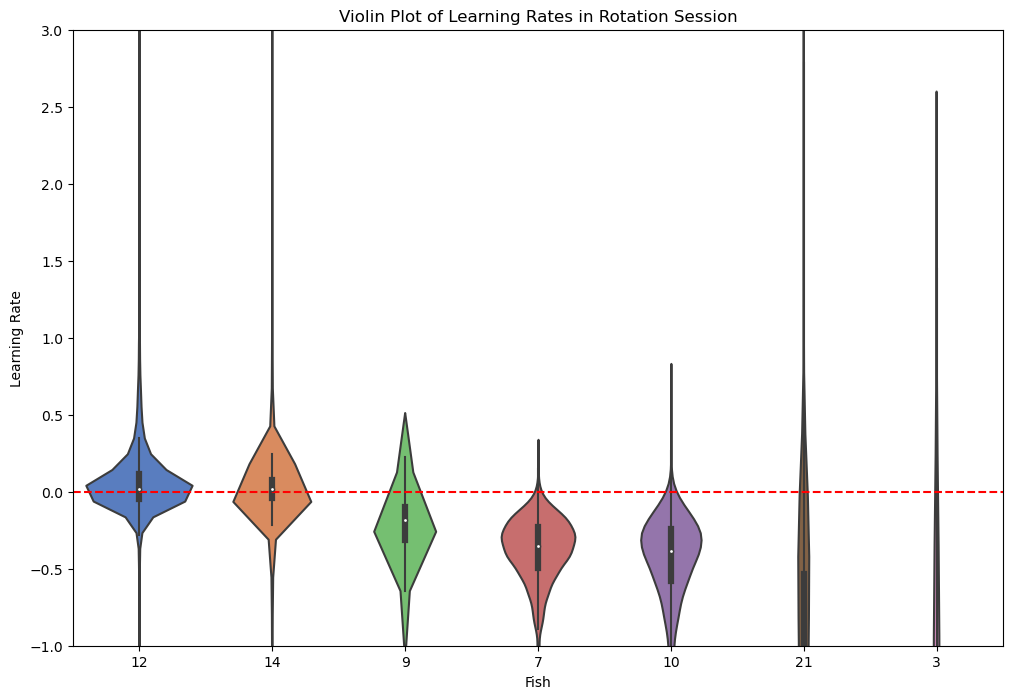

Mean learning rates for each fish in 'Rotation' session:
fish
12    0.049921
14   -0.025299
9    -0.245231
7    -0.381522
10   -0.446030
21   -1.967266
3    -3.591119
Name: LR, dtype: float64


In [103]:
# Calculate the mean learning rate for each fish in the "Rotation" session
rotation_means = df_vioLR[df_vioLR['session'] == 'Rotation'].groupby('fish')['LR'].mean()

# Sort fish by mean learning rate in "Rotation" session in descending order
sorted_fish = rotation_means.sort_values(ascending=False).index

# Reorder the DataFrame according to the sorted fish
df_vioLR['fish'] = pd.Categorical(df_vioLR['fish'], categories=sorted_fish, ordered=True)
df_vioLR = df_vioLR.sort_values('fish')

# Plot the violin plot for the "Rotation" session
df_rotation = df_vioLR[df_vioLR['session'] == 'Rotation']

plt.figure(figsize=(12, 8))
sns.violinplot(data=df_rotation, x="fish", y="LR", palette="muted")

plt.xlabel('Fish')
plt.ylabel('Learning Rate')
plt.ylim(-1,3)
plt.title('Violin Plot of Learning Rates in Rotation Session')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Print the means for verification
print("Mean learning rates for each fish in 'Rotation' session:")
print(rotation_means.sort_values(ascending=False))

In [104]:
SD = posterior.A_σμ
SD_R = SD.sel({'stages':'Rotation' })
SD_R_across = SD_R.mean(dim='fish')
SD_R_across = SD_R_across.values.flatten()
SD_ReR = SD.sel({'stages':'ReRotation' })
# Flatten the data array to a 1-dimensional numpy array
SD_ReR_across = SD_ReR.mean(dim='fish')
SD_ReR_across = SD_ReR_across.values.flatten()

In [105]:
# Assuming LR_R is your xarray.DataArray
# Flatten the DataArray and convert to a pandas DataFrame
df_R = SD_R.to_dataframe(name='SD').reset_index()
df_ReR = SD_ReR.to_dataframe(name='SD').reset_index()
# Assuming 'fish' is one of the dimensions and 'LR_Rdata' is the flattened data
# Select only 'LR_Rdata' and 'fish' columns
df_R = df_R[['SD', 'fish']]
df_R['session'] = 'Rotation'
df_ReR = df_ReR[['SD', 'fish']]
df_ReR['session'] = 'ReRotation'
df_vioSD = pd.concat([df_R[['SD', 'fish','session']],df_ReR[['SD','session','fish']]])


In [106]:
BP = posterior.μ_μ_inf
BP_R = BP.sel({'stages':'Rotation' })
BP_R_across = BP_R.mean(dim='fish')
BP_R_across = BP_R_across.values.flatten()
BP_ReR = BP.sel({'stages':'ReRotation' })
# Flatten the data array to a 1-dimensional numpy array
BP_ReR_across = BP_ReR.mean(dim='fish')
BP_ReR_across = BP_ReR_across.values.flatten()

In [107]:
BP_across = BP.mean(dim='fish')
ALengthBP = az.summary(BP_across)
ALengthBP.to_csv('ALengthAP.csv')
ELengthBP = az.summary(BP)
ELengthBP.to_csv('ELengthAP.csv')

In [108]:
# Assuming LR_R is your xarray.DataArray
# Flatten the DataArray and convert to a pandas DataFrame
df_R = BP_R.to_dataframe(name='BP').reset_index()
df_ReR = BP_ReR.to_dataframe(name='BP').reset_index()
# Assuming 'fish' is one of the dimensions and 'LR_Rdata' is the flattened data
# Select only 'LR_Rdata' and 'fish' columns
df_R = df_R[['BP', 'fish']]
df_R['session'] = 'Rotation'
df_ReR = df_ReR[['BP', 'fish']]
df_ReR['session'] = 'ReRotation'
df_vioBP = pd.concat([df_R[['BP', 'fish','session']],df_ReR[['BP','session','fish']]])


#  For the final version plots

In [109]:
# ppcplot_df_day.to_csv("D:/FOVmodel/finalplotversion/dis_model_df.csv", index=False)

### Learning rate Figure 7

In [110]:
LR_F = LR.mean(dim="fish")
LR_FR = LR_F.sel(stages=LR['stages'].isin(['Rotation', 'ReRotation']))
df_LR_FR = LR_FR.to_dataframe(name='LR_FR').reset_index()

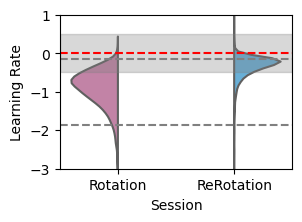

In [111]:

# Define the bounds of the ROPE
rope_min = 0.5
rope_max = -0.5
color = {'session':{"Rotation": '#CC79A7', "ReRotation": '#56B4E9'}}
# Set the plotting style
plt.style.use('default')
# Plot the violin plots for each session
plt.figure(figsize=(3, 2))

sns.violinplot(data=df_LR_FR, x="stages", y="LR_FR", hue="stages", split=True, palette=color['session'], inner=None)
# Add ROPE
plt.axhspan(rope_min, rope_max, color='grey', alpha=0.3, label='ROPE')
plt.axhline(y=ALengthLR.loc['x[Rotation]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ALengthLR.loc['x[Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.title('Violin Plot of Learning Rates Across Sessions')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Session')
plt.ylabel('Learning Rate')
plt.ylim(-3, 1)
#plt.legend( bbox_to_anchor=(1.5, 1))
plt.legend().set_visible(False)
plt.savefig(os.path.join(plotfolder, f'Figure7F1.png'), bbox_inches='tight', dpi=600)

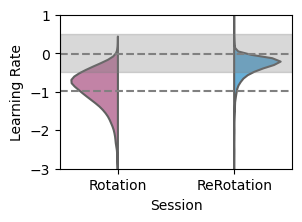

In [112]:

# Plot the violin plots for each session
plt.figure(figsize=(3, 2))
sns.violinplot(data=df_LR_FR, x="stages", y="LR_FR", hue="stages", split=True, palette=color['session'], inner=None)
# Add ROPE
plt.axhspan(rope_min, rope_max, color='grey', alpha=0.3, label='ROPE')
plt.axhline(y=ALengthLR.loc['x[ReRotation]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ALengthLR.loc['x[ReRotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Session')
plt.ylabel('Learning Rate')
plt.ylim(-3, 1)
plt.legend().set_visible(False)
plt.savefig(os.path.join(plotfolder, f'Figure7F2.png'), bbox_inches='tight', dpi=600)

### Asymptotic performance Figure 7

In [113]:
BP = posterior.μ_μ_inf
BP_R = BP.sel({'stages':'Rotation' })
BP_R_across = BP_R.mean(dim='fish')
BP_R_across = BP_R_across.values.flatten()
BP_ReR = BP.sel({'stages':'ReRotation' })
# Flatten the data array to a 1-dimensional numpy array
BP_ReR_across = BP_ReR.mean(dim='fish')
BP_ReR_across = BP_ReR_across.values.flatten()

In [114]:
BP_F = BP.mean(dim="fish")
BP_FR = BP_F.sel(stages=BP['stages'].isin(['Rotation', 'ReRotation']))
df_FR = BP_FR.to_dataframe(name='BP_FR').reset_index()

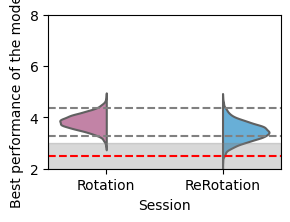

In [115]:

# Define the bounds of the ROPE
rope_min = 0.5
rope_max = -0.5
color = {'session':{"Rotation": '#CC79A7', "ReRotation": '#56B4E9'}}
plt.figure(figsize=(3, 2))
sns.violinplot(data=df_FR , x="stages", y="BP_FR", hue="stages", split=True, palette=color['session'], inner=None)
# Add ROPE
plt.axhspan(rope_min+2.5, rope_max+2.5, color='grey', alpha=0.3, label='ROPE')

plt.axhline(y=ALengthBP.loc['μ_μ_inf[Rotation]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ALengthBP.loc['μ_μ_inf[Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ALengthBP.loc['μ_μ_inf[ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ALengthBP.loc['μ_μ_inf[ReRotation]','hdi_97%'], color='grey', linestyle='--')

plt.xlabel('Session')

plt.ylim(2, 8)
plt.ylabel('Best performance of the modelfit')
#plt.legend( bbox_to_anchor=(1.5, 1))
#plt.title('Best performance Across Sessions')
plt.axhline(y=2.5, color='red', linestyle='--')
plt.legend().set_visible(False)
plt.savefig(os.path.join(plotfolder, f'Figure7E3.png'), bbox_inches='tight', dpi=600)

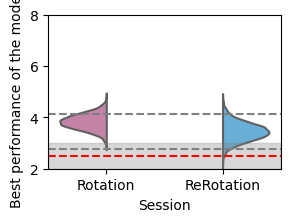

In [116]:

# Define the bounds of the ROPE
rope_min = 0.5
rope_max = -0.5
color = {'session':{"Rotation": '#CC79A7', "ReRotation": '#56B4E9'}}
plt.figure(figsize=(3, 2))
sns.violinplot(data=df_FR , x="stages", y="BP_FR", hue="stages", split=True, palette=color['session'], inner=None)
# Add ROPE
plt.axhspan(rope_min+2.5, rope_max+2.5, color='grey', alpha=0.3, label='ROPE')

# plt.axhline(y=ALengthBP.loc['μ_μ_inf[Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ALengthBP.loc['μ_μ_inf[Rotation]','hdi_97%'], color='grey', linestyle='--')
plt.axhline(y=ALengthBP.loc['μ_μ_inf[ReRotation]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ALengthBP.loc['μ_μ_inf[ReRotation]','hdi_97%'], color='grey', linestyle='--')

plt.xlabel('Session')

plt.ylim(2 ,8)
plt.ylabel('Best performance of the modelfit')
#plt.legend( bbox_to_anchor=(1.5, 1))
#plt.title('Best performance Across Sessions')
plt.axhline(y=2.5, color='red', linestyle='--')
plt.legend().set_visible(False)
plt.savefig(os.path.join(plotfolder, f'Figure7E4.png'), bbox_inches='tight', dpi=600)

In [117]:
BP_SR = BP.sel(stages=BP['stages'].isin(['Rotation', 'ReRotation']))
df_BP_SR = BP_SR.to_dataframe(name='BP_SR').reset_index()

c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


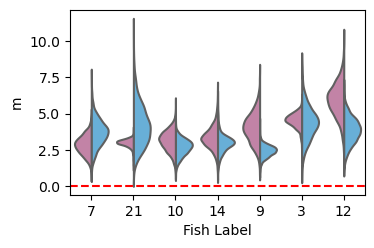

In [118]:
# Calculate the mean learning rate for each fish in the "Rotation" session
BP_SR_medians = df_BP_SR[df_BP_SR ['stages'] == 'Rotation'].groupby('fish')['BP_SR'].median()

# Sort fish by mean learning rate in "Rotation" session in descending order
sorted_BP_SR_median = BP_SR_medians.sort_values(ascending=True).index

# Reorder the DataFrame according to the sorted fish
df_BP_SR ['fish'] = pd.Categorical(df_BP_SR ['fish'], categories=sorted_BP_SR_median, ordered=True)
df_BP_SR   =df_BP_SR.sort_values('fish')
#  Create a categorical type for the 'stages' column
df_BP_SR ['stages'] = pd.Categorical(df_BP_SR ['stages'], categories=['Rotation', 'ReRotation'], ordered=True)
# Sort the DataFrame by 'stages' and then by 'fish'
df_BP_SR  = df_BP_SR .sort_values(by=['stages', 'fish'])
color = {'session':{"Rotation": '#CC79A7', "ReRotation": '#56B4E9'}}
plt.figure(figsize=(3.8, 2.4))
sns.violinplot(data=df_BP_SR , x="fish", y="BP_SR", hue="stages", split=True, palette=color['session'], inner=None, order=sorted_BP_SR_median, scale='width')

# plt.ylim(-3.8, 2.4)
plt.xlabel('Fish Label' )
plt.ylabel('m')
plt.axhline(y=0, color='red', linestyle='--')


# Add legend
plt.legend().set_visible(False)
# plt.legend( bbox_to_anchor=(1.5, 1))
#plt.title('Violin Plot of Learning Rates with HDI Intervals')
# plt.grid(False)
plt.show()

### Figure 7 initial error

In [119]:
IE = posterior.A_μμ + posterior.μ_μ_inf
IE_F = IE.mean(dim="fish")
IE_FR = IE_F.sel(stages=BP['stages'].isin(['Rotation', 'ReRotation']))
df_IE_FR = IE_FR.to_dataframe(name='IE_FR').reset_index()


In [120]:
ALengthIE = az.summary(IE_F)
ALengthIE.to_csv('ALengthIE.csv')
ELengthIE = az.summary(BP)
ELengthIE.to_csv('ELengthIE.csv')

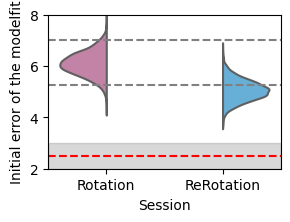

In [121]:

# Define the bounds of the ROPE
rope_min = 0.5
rope_max = -0.5
color = {'session':{"Rotation": '#CC79A7', "ReRotation": '#56B4E9'}}
plt.figure(figsize=(3, 2))
sns.violinplot(data=df_IE_FR , x="stages", y="IE_FR", hue="stages", split=True, palette=color['session'], inner=None)
# Add ROPE
plt.axhspan(rope_min+2.5, rope_max+2.5, color='grey', alpha=0.3, label='ROPE')

plt.axhline(y=ALengthIE.loc['x[Rotation]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ALengthIE.loc['x[Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ALengthBP.loc['x[ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ALengthBP.loc['x[ReRotation]','hdi_97%'], color='grey', linestyle='--')

plt.xlabel('Session')
plt.ylim(2, 8)
plt.ylabel('Initial error of the modelfit')
#plt.legend( bbox_to_anchor=(1.5, 1))
#plt.title('Best performance Across Sessions')
plt.axhline(y=2.5, color='red', linestyle='--')
plt.legend().set_visible(False)
plt.savefig(os.path.join(plotfolder, f'Figure7E1.png'), bbox_inches='tight', dpi=600)

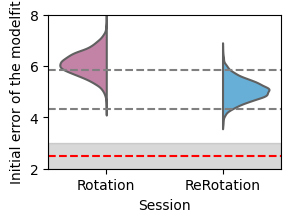

In [122]:

# Define the bounds of the ROPE
rope_min = 0.5
rope_max = -0.5
color = {'session':{"Rotation": '#CC79A7', "ReRotation": '#56B4E9'}}
plt.figure(figsize=(3, 2))
sns.violinplot(data=df_IE_FR , x="stages", y="IE_FR", hue="stages", split=True, palette=color['session'], inner=None)
# Add ROPE
plt.axhspan(rope_min+2.5, rope_max+2.5, color='grey', alpha=0.3, label='ROPE')

# plt.axhline(y=ALengthBP.loc['x[Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ALengthBP.loc['x[Rotation]','hdi_97%'], color='grey', linestyle='--')
plt.axhline(y=ALengthIE.loc['x[ReRotation]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ALengthIE.loc['x[ReRotation]','hdi_97%'], color='grey', linestyle='--')

plt.xlabel('Session')
plt.ylim(2, 8)
plt.ylabel('Initial error of the modelfit')
# plt.legend( bbox_to_anchor=(1.5, 1))
#plt.title('Best performance Across Sessions')
plt.axhline(y=2.5, color='red', linestyle='--')
plt.legend().set_visible(False)
plt.savefig(os.path.join(plotfolder, f'Figure7E2.png'), bbox_inches='tight', dpi=600)

In [123]:
IE = posterior.A_μμ + posterior.μ_μ_inf
IE_SR = IE.sel(stages=IE['stages'].isin(['Rotation', 'ReRotation']))
df_IE_SR = IE_SR.to_dataframe(name='IE_SR').reset_index()


c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


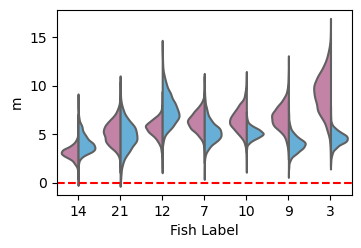

In [124]:
# Calculate the mean learning rate for each fish in the "Rotation" session
IE_SR_medians = df_IE_SR[df_IE_SR ['stages'] == 'Rotation'].groupby('fish')['IE_SR'].median()

# Sort fish by mean learning rate in "Rotation" session in descending order
sorted_IE_SR_median = IE_SR_medians.sort_values(ascending=True).index

# Reorder the DataFrame according to the sorted fish
df_IE_SR ['fish'] = pd.Categorical(df_IE_SR ['fish'], categories=sorted_IE_SR_median, ordered=True)
df_IE_SR   =df_IE_SR.sort_values('fish')
#  Create a categorical type for the 'stages' column
df_IE_SR ['stages'] = pd.Categorical(df_IE_SR ['stages'], categories=['Rotation', 'ReRotation'], ordered=True)
# Sort the DataFrame by 'stages' and then by 'fish'
df_IE_SR  = df_IE_SR .sort_values(by=['stages', 'fish'])

plt.figure(figsize=(3.8, 2.4))
sns.violinplot(data=df_IE_SR , x="fish", y="IE_SR", hue="stages", split=True, palette=color['session'], inner=None, order=sorted_IE_SR_median, scale='width')

# plt.ylim(-3.8, 2.4)
plt.xlabel('Fish Label' )
plt.ylabel('m')
plt.axhline(y=0, color='red', linestyle='--')

# Add legend
plt.legend().set_visible(False)
# plt.legend( bbox_to_anchor=(1.5, 1))
#plt.title('Violin Plot of Learning Rates with HDI Intervals')
# plt.grid(False)
plt.show()

## Figure 8 negative correlation

In [125]:
rotation_data = LR.sel(stages='Rotation')
rerotation_data = LR.sel(stages='ReRotation')

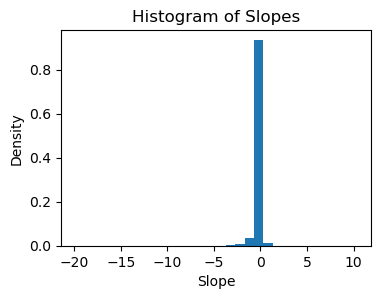

C:\Users\86153\AppData\Local\Temp\ipykernel_50528\3891220057.py:41: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_regression_lines = az.hdi(regression_lines, hdi_prob=0.94)


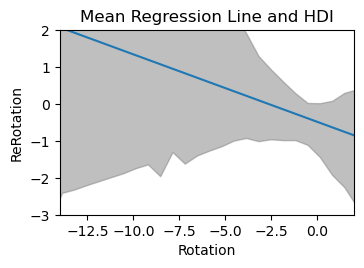

In [126]:
# Initialize lists to store the regression parameters
slopes = []
intercepts = []

# Perform linear regression for each (chain, draw)
for chain in range(rotation_data.shape[0]):
    for draw in range(rotation_data.shape[1]):
        x = rotation_data[chain, draw, :].values
        y = rerotation_data[chain, draw, :].values
        slope, intercept = np.polyfit(x, y, 1)
        slopes.append(slope)
        intercepts.append(intercept)

# Convert slopes and intercepts to arrays
slopes = np.array(slopes)
intercepts = np.array(intercepts)

# Plot histogram of slopes
plt.figure(figsize=(4, 2.8))
plt.hist(slopes, bins=30, density=True)
plt.xlabel('Slope')
plt.ylabel('Density')
plt.title('Histogram of Slopes')
plt.show()


# Plot mean regression line and HDI
x_vals = np.linspace(rotation_data.values.min(), rotation_data.values.max(), 100)

# Compute regression lines
regression_lines = []
for i in range(len(slopes)):
    regression_lines.append(intercepts[i] + slopes[i] * x_vals)

regression_lines = np.array(regression_lines)

# Mean regression line
mean_regression_line = regression_lines.mean(axis=0)

# HDI of regression lines
hdi_regression_lines = az.hdi(regression_lines, hdi_prob=0.94)

plt.figure(figsize=(3.8, 2.4))
plt.plot(x_vals, mean_regression_line, label='Mean Regression Line')
plt.fill_between(x_vals, hdi_regression_lines[:, 0], hdi_regression_lines[:, 1], color='gray', alpha=0.5, label='94% HDI')
plt.xlabel('Rotation')
plt.ylabel('ReRotation')
plt.ylim(-3,2)
plt.xlim(-14,2)
plt.title('Mean Regression Line and HDI')
plt.legend().set_visible(False)
plt.savefig(os.path.join(plotfolder, f'Figure8C2.png'), bbox_inches='tight', dpi=600)

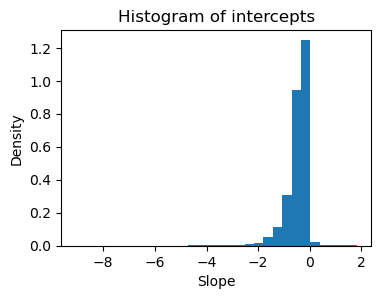

In [127]:
# Plot histogram of intercepts
plt.figure(figsize=(4, 2.8))
plt.hist(intercepts, bins=30, density=True)
plt.xlabel('Slope')
plt.ylabel('Density')
plt.title('Histogram of intercepts')
plt.show()

In [128]:
az.summary(slopes)

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x -0.183  0.538  -0.712    0.246       0.01    0.007    2330.0    1831.0   

   r_hat  
x    NaN

## Figure8 learning rate for each fish

In [129]:
LR_SR = LR.sel(stages=LR['stages'].isin(['Rotation', 'ReRotation']))
df_LR_SR = LR_SR.to_dataframe(name='LR_SR').reset_index()



c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


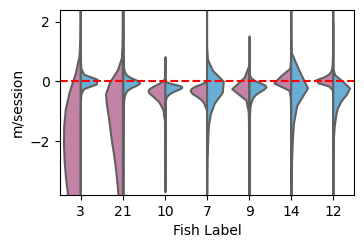

In [130]:
# Calculate the mean learning rate for each fish in the "Rotation" session
LR_SR_medians = df_LR_SR [df_LR_SR ['stages'] == 'Rotation'].groupby('fish')['LR_SR'].median()

# Sort fish by mean learning rate in "Rotation" session in descending order
sorted_LR_SR_median = LR_SR_medians.sort_values(ascending=True).index

# Reorder the DataFrame according to the sorted fish
df_LR_SR ['fish'] = pd.Categorical(df_LR_SR ['fish'], categories=sorted_LR_SR_median, ordered=True)
df_LR_SR  = df_LR_SR.sort_values('fish')
#  Create a categorical type for the 'stages' column
df_LR_SR['stages'] = pd.Categorical(df_LR_SR['stages'], categories=['Rotation', 'ReRotation'], ordered=True)
# Sort the DataFrame by 'stages' and then by 'fish'
df_LR_SR = df_LR_SR.sort_values(by=['stages', 'fish'])

plt.figure(figsize=(3.8, 2.4))
sns.violinplot(data=df_LR_SR, x="fish", y="LR_SR", hue="stages", split=True, palette=color['session'], inner=None, order=sorted_LR_SR_median, scale='width')

plt.ylim(-3.8, 2.4)
plt.xlabel('Fish Label' )
plt.ylabel('m/session')
plt.axhline(y=0, color='red', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[3, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[3, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[21, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[21, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[9, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[9, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[7, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[7, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[10, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[10, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[12, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[12, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[14, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[14, Rotation]','hdi_97%'], color='grey', linestyle='--')

# Add legend
plt.legend().set_visible(False)
# plt.legend( bbox_to_anchor=(1.5, 1))
#plt.title('Violin Plot of Learning Rates with HDI Intervals')
# plt.grid(False)
plt.show()


C:\Users\86153\AppData\Local\Temp\ipykernel_50528\647926069.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  LR_SR_medians = df_LR_SR [df_LR_SR ['stages'] == 'Rotation'].groupby('fish')['LR_SR'].median()
c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


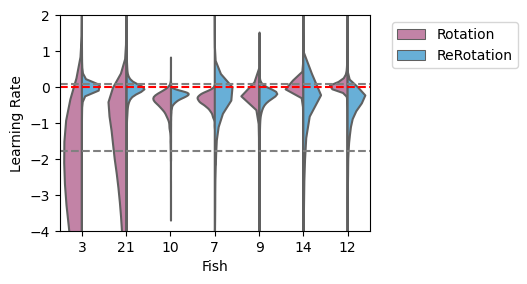

In [131]:
# Calculate the mean learning rate for each fish in the "Rotation" session
LR_SR_medians = df_LR_SR [df_LR_SR ['stages'] == 'Rotation'].groupby('fish')['LR_SR'].median()

# Sort fish by mean learning rate in "Rotation" session in descending order
sorted_LR_SR_median = LR_SR_medians.sort_values(ascending=True).index

# Reorder the DataFrame according to the sorted fish
df_LR_SR ['fish'] = pd.Categorical(df_LR_SR ['fish'], categories=sorted_LR_SR_median, ordered=True)
df_LR_SR  = df_LR_SR.sort_values('fish')

plt.figure(figsize=(4, 2.8))
sns.violinplot(data=df_LR_SR, x="fish", y="LR_SR", hue="stages", split=True, palette=color['session'], inner=None, order=sorted_LR_SR_median, scale='width')

plt.ylim(-4, 2)
plt.xlabel('Fish')
plt.ylabel('Learning Rate')
plt.axhline(y=0, color='red', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[3, ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[3, ReRotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[21, ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[21, ReRotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[9, ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[9, ReRotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[7, ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[7, ReRotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[10, ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[10, ReRotation]','hdi_97%'], color='grey', linestyle='--')
plt.axhline(y=ELengthLR.loc['x[12, ReRotation]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ELengthLR.loc['x[12, ReRotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[14, ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[14, ReRotation]','hdi_97%'], color='grey', linestyle='--')

# Add legend
# plt.legend().set_visible(False)
plt.legend( bbox_to_anchor=(1.5, 1))
#plt.title('Violin Plot of Learning Rates with HDI Intervals')
# plt.grid(False)
plt.show()


## Figure2

In [132]:
selected_data = posterior.μ_μ.isel(data=[150,151,152,153,154,155,
                                          598, 599, 600, 601, 602, 603,
                                          999, 1000, 1001, 1002, 1003, 1004,
                                          1395,1396,1397,1398,1399,1400,
                                          1705,1706,1707,1708,1709,1710,
                                          1975,1976,1977,1978,1979,1980,
                                          2303,2304,2305,2306,2307,2308
                                          ])


In [133]:
hdi_fish = selected_data.mean(dim = 'data') 
az.summary(hdi_fish)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ_μ  5.995  0.434   5.139    6.777      0.007    0.005    3929.0    3360.0   

     r_hat  
μ_μ    1.0

In [134]:
ALengthIE

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
x[Baseline]    6.001  0.569   4.933    7.063      0.009    0.006    4405.0   
x[Rotation]    6.101  0.466   5.261    7.006      0.007    0.005    3874.0   
x[Washout]     3.907  0.370   3.213    4.594      0.006    0.004    3355.0   
x[ReRotation]  5.065  0.412   4.315    5.850      0.007    0.005    3639.0   
x[ReWashout]   6.240  0.951   4.499    8.066      0.016    0.011    3472.0   

               ess_tail  r_hat  
x[Baseline]      2661.0    1.0  
x[Rotation]      3286.0    1.0  
x[Washout]       2842.0    1.0  
x[ReRotation]    3202.0    1.0  
x[ReWashout]     2835.0    1.0

In [135]:
R_start_indices = [150, 598, 999, 1395, 1705, 1975, 2303]
num_sessions = 15
num_trials_per_fish = 6  # Number of trials per fish for each session

# Generate indices for each session
R_μ_μ_indices = [
    [start + j for start in R_start_indices for j in range(i * num_trials_per_fish, (i + 1) * num_trials_per_fish)]
    for i in range(num_sessions)
]

In [136]:
# Extract data and concatenate along a new dimension
R_μ_μ = xr.concat([posterior.μ_μ.isel(data=idx) for idx in R_μ_μ_indices], dim='sessions')

# Assign stage labels, if desired
R_μ_μ = R_μ_μ.assign_coords(sessions=[f'R{i+1}' for i in range(num_sessions)])

In [137]:
hdi_fish = R_μ_μ.mean(dim = 'data') 
az.summary(hdi_fish)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
μ_μ[R1]   5.995  0.434   5.139    6.777      0.007    0.005    3929.0   
μ_μ[R2]   5.409  0.305   4.840    5.999      0.005    0.003    4572.0   
μ_μ[R3]   5.100  0.251   4.627    5.584      0.004    0.002    5169.0   
μ_μ[R4]   4.903  0.218   4.511    5.339      0.003    0.002    5126.0   
μ_μ[R5]   4.761  0.196   4.390    5.131      0.003    0.002    5005.0   
μ_μ[R6]   4.652  0.182   4.307    4.996      0.003    0.002    4882.0   
μ_μ[R7]   4.562  0.174   4.236    4.891      0.003    0.002    4815.0   
μ_μ[R8]   4.488  0.169   4.161    4.801      0.002    0.002    4770.0   
μ_μ[R9]   4.423  0.168   4.104    4.741      0.002    0.002    4728.0   
μ_μ[R10]  4.368  0.169   4.043    4.680      0.002    0.002    4700.0   
μ_μ[R11]  4.319  0.171   3.991    4.636      0.003    0.002    4684.0   
μ_μ[R12]  4.275  0.174   3.943    4.596      0.003    0.002    4659.0   
μ_μ[R13]  4.236  0.178   3.894    4.561      0.003    0.002    4607.0   
μ_μ[R14]  4.202  0.182   3.857    4.541      0.003    0.002    4578.0   
μ_μ[R15]  4.131  0.167   3.823    4.454      0.002    0.002    4544.0   

          ess_tail  r_hat  
μ_μ[R1]     3360.0    1.0  
μ_μ[R2]     3466.0    1.0  
μ_μ[R3]     3462.0    1.0  
μ_μ[R4]     3408.0    1.0  
μ_μ[R5]     3418.0    1.0  
μ_μ[R6]     3484.0    1.0  
μ_μ[R7]     3479.0    1.0  
μ_μ[R8]     3508.0    1.0  
μ_μ[R9]     3650.0    1.0  
μ_μ[R10]    3700.0    1.0  
μ_μ[R11]    3876.0    1.0  
μ_μ[R12]    3929.0    1.0  
μ_μ[R13]    3800.0    1.0  
μ_μ[R14]    3688.0    1.0  
μ_μ[R15]    3531.0    1.0

In [138]:
posterior_μ_μ = posterior["μ_μ"]
day_ = id_yds_numpyro.constant_data["day_"]
stage_ = id_yds_numpyro.constant_data["stage_"]
fish_ = id_yds_numpyro.constant_data["fish_"]
# Assign all coordinates
posterior_μ_μ_with_coords = posterior_μ_μ.assign_coords(day_=day_, stage_=stage_, fish_=fish_)

In [139]:
# Extract coordinates
day_ = posterior_μ_μ_with_coords.coords['day_'].values
stage_ = posterior_μ_μ_with_coords.coords['stage_'].values

# Initialize index lists
B_indices = [[] for _ in range(25)]  # For day_ = 0 to 24, stage_ = 0
R_indices = [[] for _ in range(15)]  # For day_ = 0 to 14, stage_ = 1
W_indices = [[] for _ in range(10)]  # For day_ = 0 to 9, stage_ = 2
ReR_indices = [[] for _ in range(15)]  # For day_ = 0 to 14, stage_ = 3
ReW_indices = [[] for _ in range(10)]  # For day_ = 0 to 9, stage_ = 4
# Iterate over all indices
for i in range(len(day_)):
    d = day_[i]
    s = stage_[i]
    
    # Check conditions and append indices to the corresponding lists
    if s == 0 and 0 <= d < 25:
        B_indices[d].append(i)
    elif s == 1 and 0 <= d < 15:
        R_indices[d].append(i)
    elif s == 2 and 0 <= d < 10:
        W_indices[d].append(i)
    elif s == 3 and 0 <= d < 15:
        ReR_indices[d].append(i)
    elif s == 4 and 0 <= d < 10:
        ReW_indices[d].append(i)



In [140]:
real_gamma_medians_mean_list = []

# Prepare containers for means, medians, and HDI summaries
for stage, indices_list, days_range in zip(
    ['Baseline', 'Rotation', 'Washout', 'ReRotation', 'ReWashout'], 
    [B_indices, R_indices, W_indices, ReR_indices, ReW_indices],
    [25, 15, 10, 15, 10]
):
    for d in range(days_range):
        indices = indices_list[d]
        if indices:
            # Extract data for the current day
            μ_μ_d = posterior.μ_μ.isel(data=indices)
            σ_μ_d = posterior.σ_μ.isel(data=indices)

            real_gamma_medians = xr.apply_ufunc(
                gamma_median,
                μ_μ_d ,
                σ_μ_d ,
                input_core_dims=[[], []],
                output_core_dims=[[]],
                vectorize=True,
                dask='parallelized',
                output_dtypes=[float]
            )
            # real_gamma_medians_mean = real_gamma_medians.mean(dim='data')
            # real_gamma_summary = az.summary(real_gamma_medians_mean)
            real_gamma_medians_median = real_gamma_medians.median(dim='data')
            real_gamma_median_summary = az.summary(real_gamma_medians_median)


                # Compute the median of the gamma distribution

            real_gamma_medians_mean_list.append({
                'Stage': stage,
                'Day': d,
                # 'HDI_Lower': real_gamma_summary['hdi_3%'].values,
                # 'HDI_Upper': real_gamma_summary['hdi_97%'].values,
                # 'Mean': real_gamma_summary['mean'].values,
                'Median': real_gamma_median_summary['mean'].values,
                'HDI_Lower_median': real_gamma_median_summary['hdi_3%'].values,
                'HDI_Upper_median': real_gamma_median_summary['hdi_97%'].values,


            })

real_gamma_medians_mean_df = pd.DataFrame(real_gamma_medians_mean_list)


In [141]:
# Function to safely convert strings with list-like values to numeric
def safe_convert(value):
    try:
        # Handle lists in strings
        if isinstance(value, str) and value.startswith('[') and value.endswith(']'):
            value = value.strip('[]')
            value = float(value.split(',')[0].strip())
        else:
            value = float(value)
        return value
    except ValueError:
        return float('nan')
# Apply conversion to each column
real_gamma_medians_mean_df['HDI_Lower_median'] = real_gamma_medians_mean_df['HDI_Lower_median'].apply(safe_convert)
real_gamma_medians_mean_df['HDI_Upper_median'] = real_gamma_medians_mean_df['HDI_Upper_median'].apply(safe_convert)
real_gamma_medians_mean_df['Median'] = real_gamma_medians_mean_df['Median'].apply(safe_convert)
num_rows = len(real_gamma_medians_mean_df)
real_gamma_medians_mean_df['PlotDay'] = range(-25, -25 + num_rows)

C:\Users\86153\AppData\Local\Temp\ipykernel_50528\887256311.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = float(value)


In [142]:
# Initialize empty lists to store data
mean_list = []
hdi_list = []

# Prepare containers for means, medians, and HDI summaries
for stage, indices_list, days_range in zip(
    ['Baseline', 'Rotation', 'Washout', 'ReRotation', 'ReWashout'], 
    [B_indices, R_indices, W_indices, ReR_indices, ReW_indices],
    [25, 15, 10, 15, 10]
):
    for d in range(days_range):
        indices = indices_list[d]
        if indices:
            # Extract data for the current day
            μ_μ_d = posterior.μ_μ.isel(data=indices)
            μ_μ_d_mean = μ_μ_d.mean(dim='data')
            μ_μ_d_median = μ_μ_d.median(dim='data')  # Compute median
            μ_μ_d_median_v = μ_μ_d_median.quantile(0.5, dim=['chain', 'draw'])

            σ_μ_d = posterior.σ_μ.isel(data=indices)
            σ_μ_d_mean = σ_μ_d.mean(dim='data')
            σ_μ_d_median = σ_μ_d.median(dim='data')  # Compute median
            σ_μ_d_median_v = μ_μ_d_median.quantile(0.5, dim=['chain', 'draw'])

            # Compute HDI
            hdi_summary = az.summary(μ_μ_d_mean)
            σ_hdi_summary = az.summary(σ_μ_d_mean)

            
            
            # Append means, medians, and HDI summaries
            mean_list.append({
                'Stage': stage,
                'Day': d,
                'Mean': μ_μ_d_mean.values,
                'Median': μ_μ_d_median_v.values,  # Add median
            })
            hdi_list.append({
                'Stage': stage,
                'Day': d,
                'HDI_Lower': hdi_summary['hdi_3%'].values,
                'HDI_Upper': hdi_summary['hdi_97%'].values,
                'Mean': hdi_summary['mean'].values,
                'Median': μ_μ_d_median_v.values,  # Add median
                'σ_Mean': σ_hdi_summary['mean'].values,
                'σ_Median': σ_μ_d_median_v.values,  # Add σ median
                'σ_HDI_Lower': σ_hdi_summary['hdi_3%'].values,
                'σ_HDI_Upper': σ_hdi_summary['hdi_97%'].values,
            })

# Create DataFrames
mean_df = pd.DataFrame(mean_list)
hdi_df = pd.DataFrame(hdi_list)


In [143]:


# Apply conversion to each column
hdi_df['HDI_Lower'] = hdi_df['HDI_Lower'].apply(safe_convert)
hdi_df['HDI_Upper'] = hdi_df['HDI_Upper'].apply(safe_convert)
hdi_df['Mean'] = hdi_df['Mean'].apply(safe_convert)
hdi_df['Median'] = hdi_df['Median'].apply(safe_convert)
hdi_df['σ_HDI_Lower'] = hdi_df['σ_HDI_Lower'].apply(safe_convert)
hdi_df['σ_HDI_Upper'] = hdi_df['σ_HDI_Upper'].apply(safe_convert)
hdi_df['σ_Mean'] = hdi_df['σ_Mean'].apply(safe_convert)
hdi_df['σ_Median'] = hdi_df['σ_Median'].apply(safe_convert)




# Assuming hdi_df is your DataFrame
num_rows = len(hdi_df)

# Create the 'PlotDay' column with values from -25 to 49
hdi_df['PlotDay'] = range(-25, -25 + num_rows)

C:\Users\86153\AppData\Local\Temp\ipykernel_50528\887256311.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = float(value)


## Gamma HDI

In [144]:
# Compute the median of the gamma distribution
μ_hdi_lower_gamma_means = xr.apply_ufunc(
    gamma_median,
    hdi_df['HDI_Lower'],
    hdi_df['σ_HDI_Lower'],
    input_core_dims=[[], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)
# Compute the median of the gamma distribution
μ_hdi_upper_gamma_means = xr.apply_ufunc(
    gamma_median,
    hdi_df['HDI_Upper'],
    hdi_df['σ_HDI_Upper'],
    input_core_dims=[[], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)
# Compute the median of the gamma distribution
meany_gamma_means = xr.apply_ufunc(
    gamma_median,
    hdi_df['Mean'],
    hdi_df['σ_Mean'],
    input_core_dims=[[], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)
    # Compute the median of the gamma distribution
mediany_gamma_means = xr.apply_ufunc(
    gamma_median,
    hdi_df['Median'],
    hdi_df['σ_Median'],
    input_core_dims=[[], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

In [145]:
# Initialize an empty list to store the variable names and values
meany_gamma_means_val = []

# Iterate through each data variable in the Dataset
for var in meany_gamma_means.data_vars:
    value = meany_gamma_means[var].values.item()
    meany_gamma_means_val.append((value))

# Initialize an empty list to store the variable names and values
mediany_gamma_means_val = []

# Iterate through each data variable in the Dataset
for var in mediany_gamma_means.data_vars:
    value = mediany_gamma_means[var].values.item()
    mediany_gamma_means_val.append((value))


# Initialize an empty list to store the variable names and values
μ_hdi_upper_gamma_means_val = []

# Iterate through each data variable in the Dataset
for var in μ_hdi_upper_gamma_means.data_vars:
    value = μ_hdi_upper_gamma_means[var].values.item()
    μ_hdi_upper_gamma_means_val.append((value))

    # Initialize an empty list to store the variable names and values
μ_hdi_lower_gamma_means_val = []

# Iterate through each data variable in the Dataset
for var in μ_hdi_lower_gamma_means.data_vars:
    value = μ_hdi_lower_gamma_means[var].values.item()
    μ_hdi_lower_gamma_means_val.append((value))

mean_hdi_df = []
# Create a DataFrame from the lists
mean_hdi_df = pd.DataFrame({
    'μ_hdi_lower_gamma_means': μ_hdi_lower_gamma_means_val,
    'μ_hdi_upper_gamma_means': μ_hdi_upper_gamma_means_val,

    'y_gamma_means': meany_gamma_means_val,
    'y_gamma_medians': mediany_gamma_means_val,
})



In [146]:
# Reset indices if they are not aligned
hdi_df = hdi_df.reset_index(drop=True)
mean_hdi_df = mean_hdi_df.reset_index(drop=True)
combined_df = []
combined_df = pd.concat([hdi_df, mean_hdi_df], axis=1)
hdi_df = combined_df


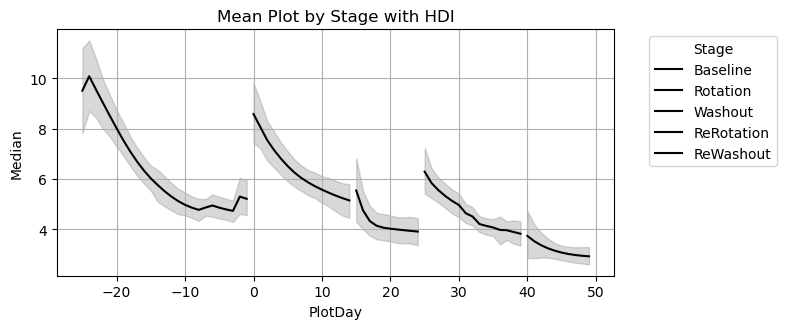

In [147]:
# Get unique stages
stages = hdi_df['Stage'].unique()

# Create a plot for each stage
plt.figure(figsize=(8, 3.4))
plt.style.use('default')
for stage in stages:
    # Filter data for the current stage
    stage_data = real_gamma_medians_mean_df[real_gamma_medians_mean_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Median'], 
             label=stage, color='black')  # Default to black if stage not in color map
    
    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower_median'], 
                     stage_data['HDI_Upper_median'],
                     color='grey',  # Use the same color as the line
                     alpha=0.3, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)

# Add labels and title
plt.xlabel('PlotDay')
plt.ylabel('Median')
plt.title('Mean Plot by Stage with HDI')
plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.grid(True)

# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

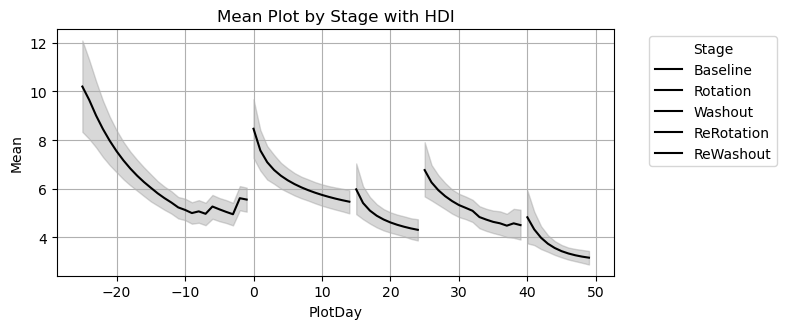

In [148]:
# Get unique stages
stages = hdi_df['Stage'].unique()

# Create a plot for each stage
plt.figure(figsize=(8, 3.4))
plt.style.use('default')
for stage in stages:
    # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['y_gamma_means'], 
             label=stage, color='black')  # Default to black if stage not in color map
    
    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['μ_hdi_lower_gamma_means'], 
                     stage_data['μ_hdi_upper_gamma_means'],
                     color='grey',  # Use the same color as the line
                     alpha=0.3, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)

# Add labels and title
plt.xlabel('PlotDay')
plt.ylabel('Mean')
plt.title('Mean Plot by Stage with HDI')
plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.grid(True)

# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

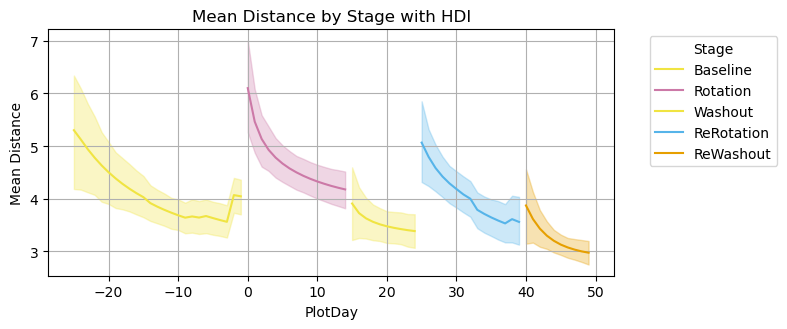

In [149]:
# Get unique stages
stages = hdi_df['Stage'].unique()
# Create a plot for each stage
plt.figure(figsize=(8, 3.4))
for stage in stages:
    # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Mean'], 
             label=stage, color=phase_colors.get(stage, 'black'))  # Default to black if stage not in color map
    
    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color=phase_colors.get(stage, 'black'),  # Use the same color as the line
                     alpha=0.3, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)

# Add labels and title
plt.xlabel('PlotDay')
plt.ylabel('Mean Distance')
plt.title('Mean Distance by Stage with HDI')
plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.grid(True)

# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

## Figure 3

In [150]:
median_df = []
# Calculate median for each combination of stage, fish, and plotday

# Define stages in the desired order
stages_All = ['Baseline', 'Rotation', 'Washout', 'ReRotation', 'ReWashout']

# Sample DataFrame (replace with your actual DataFrame)
median_df = y_obd_plot.groupby(['fish', 'stage', 'day', 'plotday'])['y'].median().reset_index()

# Convert 'stage' column to a categorical type with the specified order
median_df['stage'] = pd.Categorical(median_df['stage'], categories=stages_All, ordered=True)

# Sort the DataFrame based on 'fish', 'stage', 'day', and 'plotday'
median_df = median_df.sort_values(by=['fish', 'stage', 'day', 'plotday']).reset_index(drop=True)


In [151]:
# Initialize the 'PlotDay' column with NaN values
median_df['PlotDay'] = pd.NA
def assign_plotday(df):
    if df.empty:
        return df
    
    # Find the index of the first 'Rotation' stage
    rotation_indices = df[df['stage'] == 'Rotation'].index
    
    if not rotation_indices.empty:
        # Get the index of the first occurrence of 'Rotation' for the current fish
        rotation_index = rotation_indices[0]
        
        # Set PlotDay to 0 for the first 'Rotation' day
        df.at[rotation_index, 'PlotDay'] = 0
        
        # Assign 'PlotDay' for days before the 'Rotation' stage
        for i in range(rotation_index - 1, -1, -1):
            df.at[i, 'PlotDay'] = df.at[i + 1, 'PlotDay'] - 1
        
        # Assign 'PlotDay' for days after the 'Rotation' stage
        for i in range(rotation_index + 1, len(df)):
            df.at[i, 'PlotDay'] = df.at[i - 1, 'PlotDay'] + 1
                
    return df

# Apply the function to each fish's data
median_df = median_df.groupby('fish').apply(assign_plotday).reset_index(drop=True)
# Remove rows where 'fish' is NaN
median_df = median_df.dropna(subset=['fish']).reset_index(drop=True)
# Display the updated DataFrame for verification




C:\Users\86153\AppData\Local\Temp\ipykernel_50528\2116383523.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  median_df = median_df.groupby('fish').apply(assign_plotday).reset_index(drop=True)


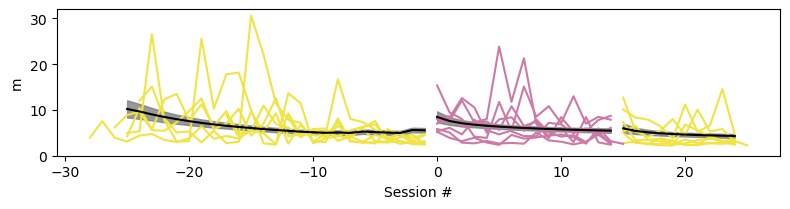

In [152]:
# Get unique stages
stages = stages_BWR

# Create a plot for each stage
plt.figure(figsize=(8, 2.2))
plt.style.use('default')
for fish in median_df['fish'].unique():
    for stage in stages:
        # Filter data for the current fish and stage
        medianEFish = median_df[(median_df['fish'] == fish) & (median_df['stage'] == stage)]
        
        # Plot the mean line for the current fish and stage
        plt.plot(medianEFish['PlotDay'], medianEFish['y'], 
                 label=stage, color=phase_colors.get(stage, 'black'),alpha=1 )  # Default to black if stage not in color map

for stage in stages:
    # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['y_gamma_means'], 
             label=stage, color='black')  # Default to black if stage not in color map

    # # Plot the HDI shading for the current stage
    # plt.fill_between(stage_data['PlotDay'], 
    #                  stage_data['HDI_Lower'], 
    #                  stage_data['HDI_Upper'],
    #                  color='grey',  # Use the same color as the line
    #                  alpha=0.5, 
    #                  label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)
    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['μ_hdi_lower_gamma_means'], 
                     stage_data['μ_hdi_upper_gamma_means'],
                     color='grey',  # Use the same color as the line
                     alpha=0.8, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)

# Add labels and title
plt.xlabel('Session #')
plt.ylabel('m')
# plt.title('Mean Plot by Stage with HDI')
# plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.ylim(0,32)  # Set fixed data range for y-axis
plt.grid(False)  # Show grid
# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig(os.path.join(plotfolder, f'Figure4C.png'), bbox_inches='tight', dpi=600)

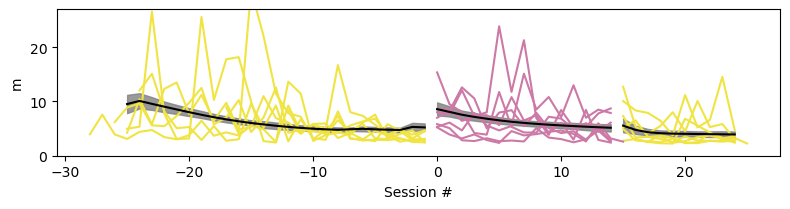

In [153]:
# Get unique stages
stages = stages_BWR

# Create a plot for each stage
plt.figure(figsize=(8, 2.2))
plt.style.use('default')
for fish in median_df['fish'].unique():
    for stage in stages:
        # Filter data for the current fish and stage
        medianEFish = median_df[(median_df['fish'] == fish) & (median_df['stage'] == stage)]
        
        # Plot the mean line for the current fish and stage
        plt.plot(medianEFish['PlotDay'], medianEFish['y'], 
                 label=stage, color=phase_colors.get(stage, 'black'),alpha=1 )  # Default to black if stage not in color map

for stage in stages:
    # Filter data for the current stage
    stage_data = real_gamma_medians_mean_df[real_gamma_medians_mean_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Median'], 
             label=stage, color='black')  # Default to black if stage not in color map
    
    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower_median'], 
                     stage_data['HDI_Upper_median'],
                     color='grey',  # Use the same color as the line
                     alpha=0.8, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)

# Add labels and title
plt.xlabel('Session #')
plt.ylabel('m')
# plt.title('Mean Plot by Stage with HDI')
# plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.ylim(0,27)  # Set fixed data range for y-axis
plt.grid(False)  # Show grid
# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig(os.path.join(plotfolder, f'Figure4C.png'), bbox_inches='tight', dpi=600)

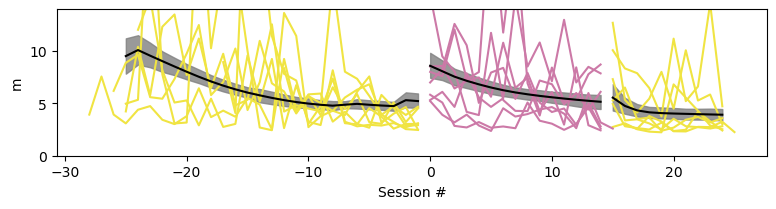

In [154]:
# Get unique stages
stages = stages_BWR

# Create a plot for each stage
plt.figure(figsize=(8, 2.2))
plt.style.use('default')
for fish in median_df['fish'].unique():
    for stage in stages:
        # Filter data for the current fish and stage
        medianEFish = median_df[(median_df['fish'] == fish) & (median_df['stage'] == stage)]
        
        # Plot the mean line for the current fish and stage
        plt.plot(medianEFish['PlotDay'], medianEFish['y'], 
                 label=stage, color=phase_colors.get(stage, 'black'),alpha=1 )  # Default to black if stage not in color map

for stage in stages:
    # Filter data for the current stage
    stage_data = real_gamma_medians_mean_df[real_gamma_medians_mean_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Median'], 
             label=stage, color='black')  # Default to black if stage not in color map
    
    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower_median'], 
                     stage_data['HDI_Upper_median'],
                     color='grey',  # Use the same color as the line
                     alpha=0.8, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)

# Add labels and title
plt.xlabel('Session #')
plt.ylabel('m')
# plt.title('Mean Plot by Stage with HDI')
# plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.ylim(0,14)  # Set fixed data range for y-axis
plt.grid(False)  # Show grid
# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig(os.path.join(plotfolder, f'Figure4Cbig.png'), bbox_inches='tight', dpi=600)

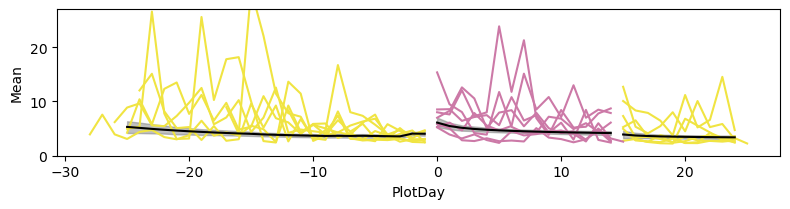

In [155]:
# Get unique stages
stages = stages_BWR

# Create a plot for each stage
plt.figure(figsize=(8, 2.2))
plt.style.use('default')
for fish in median_df['fish'].unique():
    for stage in stages:
        # Filter data for the current fish and stage
        medianEFish = median_df[(median_df['fish'] == fish) & (median_df['stage'] == stage)]
        
        # Plot the mean line for the current fish and stage
        plt.plot(medianEFish['PlotDay'], medianEFish['y'], 
                 label=stage, color=phase_colors.get(stage, 'black'),alpha=1 )  # Default to black if stage not in color map

for stage in stages:
    # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Mean'], 
             label=stage, color='black')  # Default to black if stage not in color map

    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color='grey',  # Use the same color as the line
                     alpha=0.5, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)

# Add labels and title
plt.xlabel('PlotDay')
plt.ylabel('Mean')
# plt.title('Mean Plot by Stage with HDI')
# plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.ylim(0,27)  # Set fixed data range for y-axis
plt.grid(False)  # Show grid
# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig(os.path.join(plotfolder, f'Figure2D.png'), bbox_inches='tight', dpi=600)

In [156]:
PPC_plot_df = []
PPC_plot_df = ppcplot_df_day.groupby('fish').apply(assign_plotday).reset_index(drop=True)
PPC_plot_df = PPC_plot_df.dropna(subset=['fish']).reset_index(drop=True)
PPC_plot_df = PPC_plot_df.groupby('fish').apply(assign_plotday).reset_index(drop=True)

C:\Users\86153\AppData\Local\Temp\ipykernel_50528\4090835716.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  PPC_plot_df = ppcplot_df_day.groupby('fish').apply(assign_plotday).reset_index(drop=True)
C:\Users\86153\AppData\Local\Temp\ipykernel_50528\4090835716.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  PPC_plot_df = PPC_plot_df.groupby('fish').apply(assign_plotday).reset_index(drop=True)


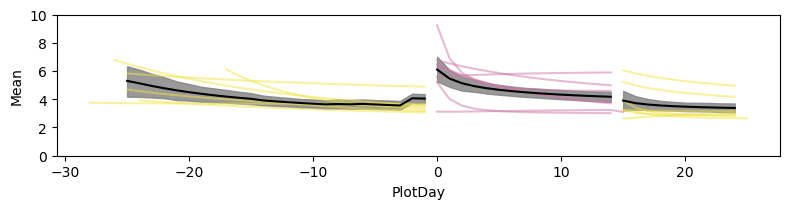

In [157]:
# Get unique stages
stages = stages_BWR

# Create a plot for each stage
plt.figure(figsize=(8, 2.2))
plt.style.use('default')
# for fish in median_df['fish'].unique():
#     for stage in stages:
#         # Filter data for the current fish and stage
#         medianEFish = median_df[(median_df['fish'] == fish) & (median_df['stage'] == stage)]
        
#         # Plot the mean line for the current fish and stage
#         plt.plot(medianEFish['PlotDay'], medianEFish['y'], 
#                  label=stage, color=phase_colors.get(stage, 'black'),alpha=0.5 )  # Default to black if stage not in color map
for fish in PPC_plot_df['fish'].unique():
    for i, stage in enumerate(stages_BWR):
        data_filter = PPC_plot_df [(PPC_plot_df['fish'] == fish) & (PPC_plot_df['stage'] == stage)]        
        plt.plot(data_filter['PlotDay'], data_filter['median_μ_μ_y'], label=f'Median μ_μ_y - {stage}', color=phase_colors.get(stage, 'black'),alpha=0.5)

for stage in stages:
    # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Mean'], 
             label=stage, color='black')  # Default to black if stage not in color map

    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color='grey',  # Use the same color as the line
                     alpha=0.8, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)

# Add labels and title
plt.xlabel('PlotDay')
plt.ylabel('Mean')
# plt.title('Mean Plot by Stage with HDI')
# plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.ylim(0,10)  # Set fixed data range for y-axis
plt.grid(False)  # Show grid
# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

## Figure 6

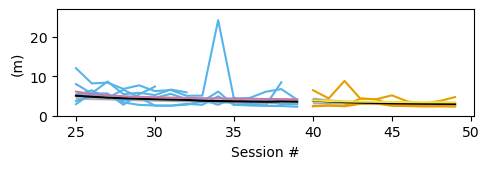

In [158]:


# Create a plot for each stage
plt.figure(figsize=(5, 1.8))
plt.style.use('default')
for fish in median_df['fish'].unique():
    for stage in stages_ReRReW:
        # Filter data for the current fish and stage
        medianEFish = median_df[(median_df['fish'] == fish) & (median_df['stage'] == stage)]
        
        # Plot the mean line for the current fish and stage
        plt.plot(medianEFish['PlotDay'], medianEFish['y'], 
                 label=stage, color=phase_colors.get(stage, 'black'),alpha=1 )  # Default to black if stage not in color map

for stage in stages_ReRReW:
    # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Mean'], 
             label=stage, color='black')  # Default to black if stage not in color map

    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color='grey',  # Use the same color as the line
                     alpha=0.5, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)
    
for stage in stages_RW:
     # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
        # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay']+25 ,stage_data['Mean'], 
             label=stage, color=phase_colors.get(stage, 'black'))  # Default to black if stage not in color map

# Add labels and title
plt.xlabel('Session #')
plt.ylabel('(m)')
# plt.title('Mean Plot by Stage with HDI')
# plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.ylim(0,27)  # Set fixed data range for y-axis
plt.grid(False)  # Show grid
# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig(os.path.join(plotfolder, f'Figure6C1.png'), bbox_inches='tight', dpi=600)

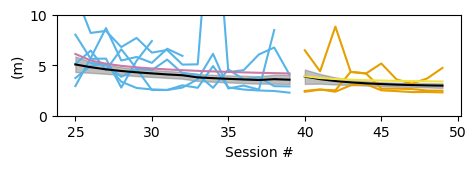

In [159]:


# Create a plot for each stage
plt.figure(figsize=(5, 1.8))
plt.style.use('default')
for fish in median_df['fish'].unique():
    for stage in stages_ReRReW:
        # Filter data for the current fish and stage
        medianEFish = median_df[(median_df['fish'] == fish) & (median_df['stage'] == stage)]
        
        # Plot the mean line for the current fish and stage
        plt.plot(medianEFish['PlotDay'], medianEFish['y'], 
                 label=stage, color=phase_colors.get(stage, 'black'),alpha=1 )  # Default to black if stage not in color map

for stage in stages_ReRReW:
    # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Mean'], 
             label=stage, color='black')  # Default to black if stage not in color map

    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color='grey',  # Use the same color as the line
                     alpha=0.5, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)
    
for stage in stages_RW:
     # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
        # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay']+25 ,stage_data['Mean'], 
             label=stage, color=phase_colors.get(stage, 'black'))  # Default to black if stage not in color map

# Add labels and title
plt.xlabel('Session #')
plt.ylabel('(m)')
# plt.title('Mean Plot by Stage with HDI')
# plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.ylim(0,10)  # Set fixed data range for y-axis
plt.grid(False)  # Show grid
# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig(os.path.join(plotfolder, f'Figure5Dbig.png'), bbox_inches='tight', dpi=600)

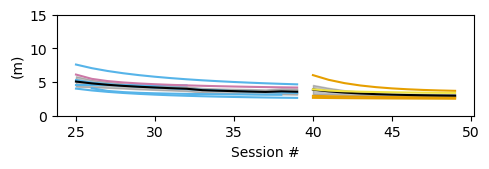

In [160]:


# Create a plot for each stage
plt.figure(figsize=(5, 1.8))
plt.style.use('default')
# for fish in median_df['fish'].unique():
#     for stage in stages_ReRReW:
#         # Filter data for the current fish and stage
#         medianEFish = median_df[(median_df['fish'] == fish) & (median_df['stage'] == stage)]
        
#         # Plot the mean line for the current fish and stage
#         plt.plot(medianEFish['PlotDay'], medianEFish['y'], 
#                  label=stage, color=phase_colors.get(stage, 'black'),alpha=1 )  # Default to black if stage not in color map
for fish in PPC_plot_df['fish'].unique():
    for i, stage in enumerate(stages_ReRReW):
        data_filter = PPC_plot_df [(PPC_plot_df['fish'] == fish) & (PPC_plot_df['stage'] == stage)]        
        plt.plot(data_filter['PlotDay'], data_filter['mean_μ_μ_y'], label=f'μ_μ_y - {stage}', color=phase_colors.get(stage, 'black'),alpha=1)
        


for stage in stages_ReRReW:
    # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Mean'], 
             label=stage, color='black')  # Default to black if stage not in color map

    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color='grey',  # Use the same color as the line
                     alpha=0.5, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)
    
for stage in stages_RW:
     # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
        # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay']+25 ,stage_data['Mean'], 
             label=stage, color=phase_colors.get(stage, 'black'))  # Default to black if stage not in color map

# Add labels and title
plt.xlabel('Session #')
plt.ylabel('(m)')
# plt.title('Mean Plot by Stage with HDI')
# plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.ylim(0,15)  # Set fixed data range for y-axis
plt.grid(False)  # Show grid
# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig(os.path.join(plotfolder, f'Figure6C2.png'), bbox_inches='tight', dpi=600)

## Figure for baseline

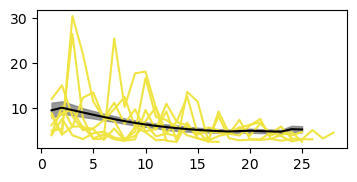

In [161]:
# Create a plot for each stage
plt.figure(figsize=(4, 1.8))
plt.style.use('default')

for fish in ppcplot_df_day['fish'].unique():
    # Filter data for the current fish and stage
    data_filter = ppcplot_df_day[(ppcplot_df_day['fish'] == fish) & (ppcplot_df_day['stage'] == 'Baseline')]
    data_filter2 = y_obd_plot[(y_obd_plot['fish'] == fish) & (y_obd_plot['stage'] == 'Baseline')]
        # Plot mean_y against plotday for the current stage
    plt.plot(data_filter['plotday'], data_filter['median_y'], label=f'Median Y - {stage}', color='#F0E442')


    # Filter data for the current stage
stage_data = real_gamma_medians_mean_df[real_gamma_medians_mean_df['Stage'] == 'Baseline']
    
    # Plot the mean line for the current stage
plt.plot(stage_data['PlotDay']+26, stage_data['Median'], 
             label=stage, color='black')  # Default to black if stage not in color map
    
    # Plot the HDI shading for the current stage
plt.fill_between(stage_data['PlotDay']+26, 
                     stage_data['HDI_Lower_median'], 
                     stage_data['HDI_Upper_median'],
                     color='grey',  # Use the same color as the line
                     alpha=0.8, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)
plt.savefig(os.path.join(plotfolder, f'Figure3Fs.png'), bbox_inches='tight', dpi=600)

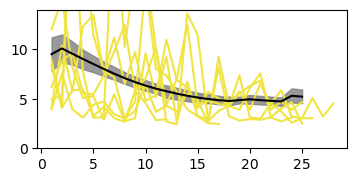

In [162]:
# Create a plot for each stage
plt.figure(figsize=(4, 1.8))
plt.style.use('default')

for fish in ppcplot_df_day['fish'].unique():
    # Filter data for the current fish and stage
    data_filter = ppcplot_df_day[(ppcplot_df_day['fish'] == fish) & (ppcplot_df_day['stage'] == 'Baseline')]
    data_filter2 = y_obd_plot[(y_obd_plot['fish'] == fish) & (y_obd_plot['stage'] == 'Baseline')]
        # Plot mean_y against plotday for the current stage
    plt.plot(data_filter['plotday'], data_filter['median_y'], label=f'Median Y - {stage}', color='#F0E442')

    # Filter data for the current stage
stage_data = hdi_df[hdi_df['Stage'] == 'Baseline']
    
    # Filter data for the current stage
stage_data = real_gamma_medians_mean_df[real_gamma_medians_mean_df['Stage'] == 'Baseline']
    
    # Plot the mean line for the current stage
plt.plot(stage_data['PlotDay']+26, stage_data['Median'], 
             label=stage, color='black')  # Default to black if stage not in color map
    
    # Plot the HDI shading for the current stage
plt.fill_between(stage_data['PlotDay']+26, 
                     stage_data['HDI_Lower_median'], 
                     stage_data['HDI_Upper_median'],
                     color='grey',  # Use the same color as the line
                     alpha=0.8, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)
plt.ylim(0,14) 
plt.savefig(os.path.join(plotfolder, f'Figure3Fb.png'), bbox_inches='tight', dpi=600)

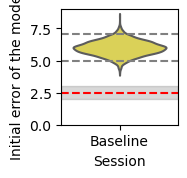

In [163]:
IE_FR_B = IE_F.sel(stages=BP['stages'].isin(['Baseline']))
df_IE_B = IE_FR_B.to_dataframe(name='IE_FR_B').reset_index()
  # Yellow
# Define the bounds of the ROPE
rope_min = 0.5
rope_max = -0.5
color = {'session':{'Baseline': '#F0E442'}}
plt.figure(figsize=(1.5, 1.5))
sns.violinplot(data=df_IE_B , x="stages", y="IE_FR_B", palette=color['session'], inner=None)
# Add ROPE
plt.axhspan(rope_min+2.5, rope_max+2.5, color='grey', alpha=0.3, label='ROPE')

plt.axhline(y=ALengthIE.loc['x[Baseline]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ALengthIE.loc['x[Baseline]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ALengthBP.loc['x[ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ALengthBP.loc['x[ReRotation]','hdi_97%'], color='grey', linestyle='--')

plt.ylim(-0, 9)
plt.xlabel('Session')

plt.ylabel('Initial error of the modelfit')
plt.legend().set_visible(False)
#plt.title('Best performance Across Sessions')
plt.axhline(y=2.5, color='red', linestyle='--')
plt.savefig(os.path.join(plotfolder, f'Figure2H.png'), bbox_inches='tight', dpi=600)

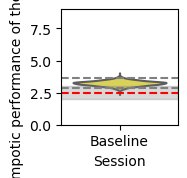

In [164]:
BP_FR_B = BP_F.sel(stages=BP['stages'].isin(['Baseline']))
df_FR_B = BP_FR_B.to_dataframe(name='BP_FR_B').reset_index()
  # Yellow

color = {'session':{'Baseline': '#F0E442'}}
plt.figure(figsize=(1.5, 1.5))
sns.violinplot(data=df_FR_B , x="stages", y="BP_FR_B", palette=color['session'], inner=None)
# Add ROPE
plt.axhspan(rope_min+2.5, rope_max+2.5, color='grey', alpha=0.3, label='ROPE')

plt.axhline(y=ALengthBP.loc['μ_μ_inf[Baseline]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ALengthBP.loc['μ_μ_inf[Baseline]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ALengthBP.loc['x[ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ALengthBP.loc['x[ReRotation]','hdi_97%'], color='grey', linestyle='--')
plt.ylim(-0, 9)
# plt.ylim(-8, 20)
plt.xlabel('Session')

plt.ylabel('Asympotic performance of the modelfit')
plt.legend().set_visible(False)
#plt.title('Best performance Across Sessions')
plt.axhline(y=2.5, color='red', linestyle='--')
plt.savefig(os.path.join(plotfolder, f'Figure2H2.png'), bbox_inches='tight', dpi=600)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


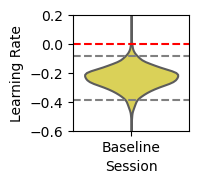

In [165]:
LR_FR_B = LR_F.sel(stages=LR['stages'].isin(['Baseline']))
df_LR_FR_B = LR_FR_B.to_dataframe(name='LR_FR_B').reset_index()# Define the bounds of the ROPE

color = {'session':{'Baseline': '#F0E442'}}
# Set the plotting style
plt.style.use('default')
# Plot the violin plots for each session
plt.figure(figsize=(1.5, 1.5))

sns.violinplot(data=df_LR_FR_B, x="stages", y="LR_FR_B", palette=color['session'], inner=None)
# Add ROPE
# plt.axhspan(rope_min, rope_max, color='grey', alpha=0.3, label='ROPE')
plt.axhline(y=ALengthLR.loc['x[Baseline]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ALengthLR.loc['x[Baseline]','hdi_97%'], color='grey', linestyle='--')
# plt.title('Violin Plot of Learning Rates Across Sessions')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Session')
plt.ylabel('Learning Rate')
plt.legend().set_visible(False)
plt.ylim(-0.6,0.2)

plt.savefig(os.path.join(plotfolder, f'Figure2I.png'), bbox_inches='tight', dpi=600)

# End

# Debug

## The difference of intial performance

Text(0.5, 1.0, 'Initial Performace difference across Fish')

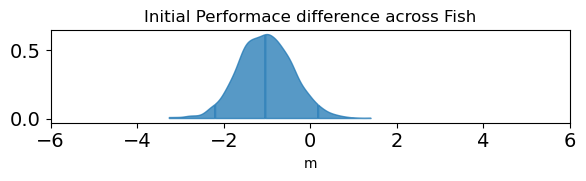

In [166]:
# Step 1: Select the data for 'ReRotation' and 'Rotation'
IE_S = IE.sel(stages='ReRotation')
IE_R = IE.sel(stages='Rotation')
dIE_SR = IE_S - IE_R
dIE_SR_F = dIE_SR.mean(dim="fish")
plt.figure(figsize=(6.7, 1.2))
az.plot_dist(dIE_SR_F, quantiles=[.03, .5, .97])
plt.xlabel('m')
plt.xlim(-6,6)
plt.title('Initial Performace difference across Fish')

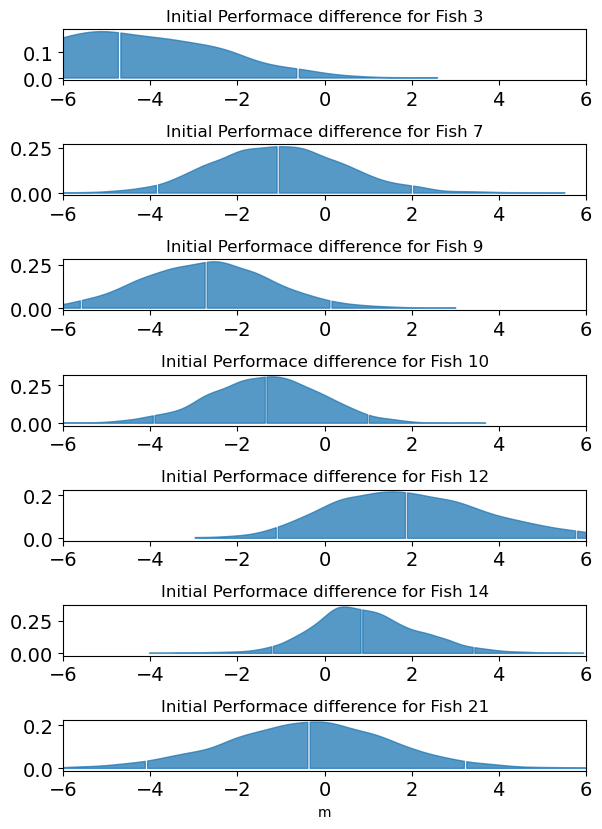

In [167]:
# Assuming dSR is your DataArray
fish_dim = dIE_SR.coords['fish']

# Create a figure with subplots for each fish
fig, axes = plt.subplots(len(fish_dim), 1, figsize=(6, len(fish_dim) * 1.2))

# If there's only one fish, axes might not be an array, so we need to handle that case
if len(fish_dim) == 1:
    axes = [axes]

# Iterate over each fish and plot its distribution
for i, fish in enumerate(fish_dim):
    az.plot_dist(dIE_SR.sel(fish=fish), quantiles=[.03, .5, .97], ax=axes[i])
    axes[i].set_title(f'Initial Performace difference for Fish {fish.item()}')
    axes[i].set_xlim(-6, 6)
plt.xlabel('m')
plt.tight_layout()
plt.show()

## difference of asymptotic performane 

Text(0.5, 1.0, 'Asymptotic Performace difference across Fish')

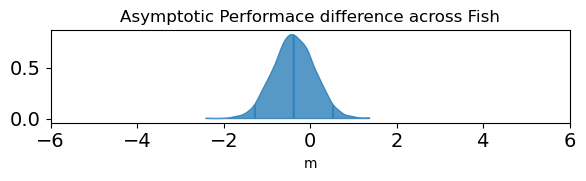

In [168]:
# Step 1: Select the data for 'ReRotation' and 'Rotation'
AP_S = BP.sel(stages='ReRotation')
AP_R = BP.sel(stages='Rotation')
dAP_SR = AP_S - AP_R
dAP_SR_F = dAP_SR.mean(dim="fish")
plt.figure(figsize=(6.7, 1.2))
az.plot_dist(dAP_SR_F, quantiles=[.03, .5, .97])
plt.xlabel('m')
plt.xlim(-6,6)
plt.title('Asymptotic Performace difference across Fish')

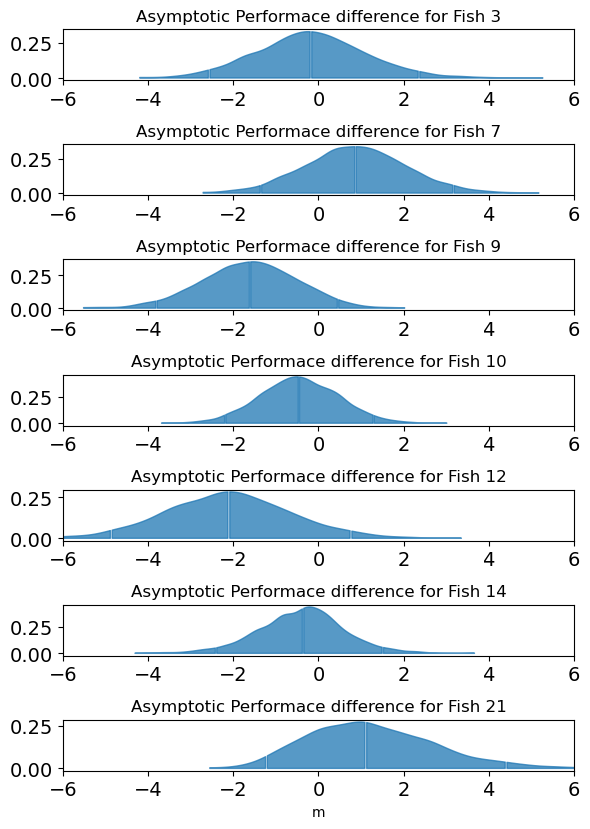

In [169]:
# Assuming dSR is your DataArray
fish_dim = dAP_SR.coords['fish']

# Create a figure with subplots for each fish
fig, axes = plt.subplots(len(fish_dim), 1, figsize=(6, len(fish_dim) * 1.2))

# If there's only one fish, axes might not be an array, so we need to handle that case
if len(fish_dim) == 1:
    axes = [axes]

# Iterate over each fish and plot its distribution
for i, fish in enumerate(fish_dim):
    az.plot_dist(dAP_SR.sel(fish=fish), quantiles=[.03, .5, .97],  ax=axes[i])

    axes[i].set_title(f'Asymptotic Performace difference for Fish {fish.item()}')
    axes[i].set_xlim(-6, 6)
plt.xlabel('m')

plt.tight_layout()
plt.show()

## Gamma fit and posterior predictive

In [170]:
ppc

<xarray.Dataset> Size: 83MB
Dimensions:  (chain: 4, draw: 1000, data: 2602)
Coordinates:
  * chain    (chain) int32 16B 0 1 2 3
  * draw     (draw) int32 4kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * data     (data) int32 10kB 0 1 2 3 4 5 6 ... 2596 2597 2598 2599 2600 2601
Data variables:
    y        (chain, draw, data) float64 83MB 4.188 6.115 12.56 ... 1.826 3.253
Attributes:
    created_at:                 2024-09-23T03:59:19.764681+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.12.0